# Импортирование необходимых библиотек

In [47]:
from sentinelhub import SHConfig
from sentinelhub import SentinelHubCatalog

import datetime
import os
import csv
from math import ceil
import math
import matplotlib.pyplot as plt
import numpy as np
from shapely.ops import unary_union
from fiona.drvsupport import supported_drivers
import geopandas as gpd
from matplotlib.path import Path
from shapely.geometry import Polygon
import earthpy.spatial as es
import earthpy.plot as ep
import numpy.ma as ma
from scipy.stats.mstats import gmean, hmean
import pandas as pd
import seaborn as sns

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
    filter_times
)

# The following is not a package. It is a file utils.py which should be in the same folder as this notebook.
from utils import plot_image

colors = ['tomato', 'navy', 'MediumSpringGreen', 'lightblue', 'orange', 'blue',
          'maroon', 'purple', 'yellow', 'olive', 'brown', 'cyan']

In [48]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
sns.set()

# Подключение к аккаунту Sentinel Hub

In [49]:
CLIENT_ID = os.getenv('CLIENT_ID')
CLIENT_SECRET = os.environ.get('CLIENT_SECRET')

config = SHConfig()

if CLIENT_ID and CLIENT_SECRET:
    config.sh_client_id = CLIENT_ID
    config.sh_client_secret = CLIENT_SECRET

if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")

In [50]:
catalog = SentinelHubCatalog(config=config)
# catalog.get_info()

# Получение координат экспериментального пастбища 

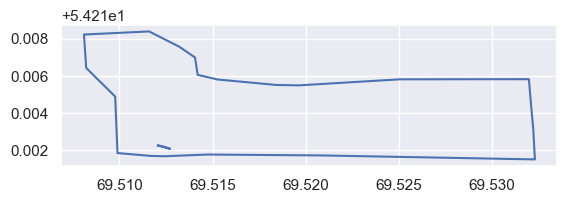

In [51]:
supported_drivers['KML'] = 'rw'
pasture_df = gpd.read_file('pasture.kml', driver='KML')

all_zagons = []
for zagon in range(len(pasture_df.index)):
    all_zagons.append(pasture_df.loc[zagon].geometry)
    
merged_zagons = unary_union(all_zagons)

gpd.GeoSeries([merged_zagons]).boundary.plot()
plt.show()

In [52]:
x_min, y_min, x_max, y_max = merged_zagons.bounds
pasture_coords_wgs84 = (x_min, y_min, x_max, y_max)

# Отправка запросов и получение снимков 

In [53]:
resolution = 10
pasture_bbox = BBox(bbox=pasture_coords_wgs84, crs=CRS.WGS84)
pasture_size = bbox_to_dimensions(pasture_bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {pasture_size} pixels")

Image shape at 10 m resolution: (157, 78) pixels


# Доступные базы данных (Спутиковые базы!!!)

In [54]:
print("Supported DataCollections:\n")
for collection in DataCollection.get_available_collections():
    print(collection)

Supported DataCollections:

DataCollection.SENTINEL2_L1C
DataCollection.SENTINEL2_L2A
DataCollection.SENTINEL1
DataCollection.SENTINEL1_IW
DataCollection.SENTINEL1_IW_ASC
DataCollection.SENTINEL1_IW_DES
DataCollection.SENTINEL1_EW
DataCollection.SENTINEL1_EW_ASC
DataCollection.SENTINEL1_EW_DES
DataCollection.SENTINEL1_EW_SH
DataCollection.SENTINEL1_EW_SH_ASC
DataCollection.SENTINEL1_EW_SH_DES
DataCollection.DEM
DataCollection.DEM_MAPZEN
DataCollection.DEM_COPERNICUS_30
DataCollection.DEM_COPERNICUS_90
DataCollection.MODIS
DataCollection.LANDSAT_MSS_L1
DataCollection.LANDSAT_TM_L1
DataCollection.LANDSAT_TM_L2
DataCollection.LANDSAT_ETM_L1
DataCollection.LANDSAT_ETM_L2
DataCollection.LANDSAT_OT_L1
DataCollection.LANDSAT_OT_L2
DataCollection.SENTINEL5P
DataCollection.SENTINEL3_OLCI
DataCollection.SENTINEL3_SLSTR
DataCollection.HARMONIZED_LANDSAT_SENTINEL


# Выбор одной из доступных баз данных

In [55]:
data_collection = DataCollection.SENTINEL2_L2A
bands_dict = dict([(band.name, i) for i, band in enumerate(data_collection.bands)])

# Составление запросов

In [56]:
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B02, sample.B03, sample.B04];
    }
"""

In [57]:
evalscript_all_bands = """
    //VERSION=3
    function setup() {{
        return {{
            input: [{{
                bands: [{BANDS}],
                units: "DN"
            }}],
            output: {{
                bands: 13,
                sampleType: "INT16"
            }}
        }};
    }}

    function evaluatePixel(sample) {{
        return [{SAMPLE}];
    }}
"""
template1 = ""; template2 = ""
for band in bands_dict.keys(): 
    template1 += f'"{band}", '; 
    template2 += f'sample.{band}, ';
settings = {"BANDS": template1, "SAMPLE": template2}
evalscript_all_bands = evalscript_all_bands.format(**settings)

# Снимки на даты (с 01.05.2022 по 31.08.2022)

In [58]:
time_interval = "2023-04-01", "2023-05-07"

search_iterator = catalog.search(
    data_collection,
    bbox=pasture_bbox,
    time=time_interval,
    filter="eo:cloud_cover <= 100",
    fields={"include": ["id", "properties.datetime", "properties.eo:cloud_cover"], "exclude": []},
)

results = list(search_iterator)
print("Total number of results:", len(results))

# results

Total number of results: 13


In [59]:
time_difference = datetime.timedelta(hours=1)

all_timestamps = search_iterator.get_timestamps()
unique_acquisitions = filter_times(all_timestamps, time_difference)

# unique_acquisitions

In [60]:
true_color_process_requests = []

for timestamp in unique_acquisitions:
    request = SentinelHubRequest(
        evalscript=evalscript_true_color,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=data_collection,
                time_interval=(timestamp - time_difference, timestamp + time_difference),
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
        bbox=pasture_bbox,
        size=pasture_size,
        config=config,
    )
    true_color_process_requests.append(request)

In [61]:
all_bands_process_requests = []

for timestamp in unique_acquisitions:
    request = SentinelHubRequest(
        evalscript=evalscript_all_bands,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=data_collection,
                time_interval=(timestamp - time_difference, timestamp + time_difference),
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=pasture_bbox,
        size=pasture_size,
        config=config,
    )
    all_bands_process_requests.append(request)

In [62]:
%%time

client = SentinelHubDownloadClient(config=config)
true_color_download_requests = [request.download_list[0] for request in true_color_process_requests]
true_color_data = client.download(true_color_download_requests)

Wall time: 2.98 s


In [63]:
%%time

client = SentinelHubDownloadClient(config=config)
all_bands_download_requests = [request.download_list[0] for request in all_bands_process_requests]
all_bands_data = client.download(all_bands_download_requests)

Wall time: 3.92 s


# Составление маски пастбища

In [64]:
 aoi_height, aoi_width, _ = true_color_data[-1].shape

In [65]:
masks = []
pasture_edges = []
for zagon in range(len(pasture_df)-1):
    polygon=[]

    for coords in pasture_df.loc[zagon].geometry.exterior.coords:

        x = int(np.interp(coords[0], [x_min, x_max], [0, aoi_width]))
        y = int(np.interp(coords[1], [y_min, y_max], [aoi_height, 0]))

        polygon.append((y, x))
        
    poly_path=Path(polygon)
    x, y = np.mgrid[:aoi_height, :aoi_width]
    coors=np.hstack((x.reshape(-1, 1), y.reshape(-1,1)))
    
    pasture_edges.append(Polygon(polygon))
    
    mask = ~poly_path.contains_points(coors)
    masks.append(mask)
    
combined_mask = masks[0]&masks[1]&masks[2]&masks[3]&masks[4]&masks[5]&masks[6]

# Маска для загона №1 

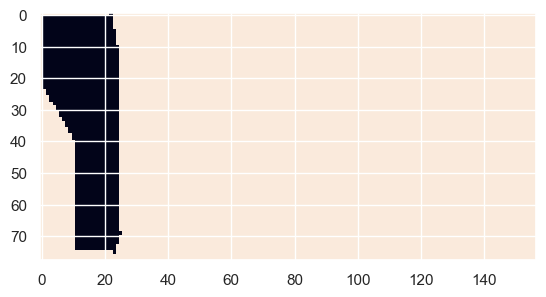

In [66]:
plt.imshow(masks[0].reshape(aoi_height, aoi_width))
plt.show()

# Маска для пастбища

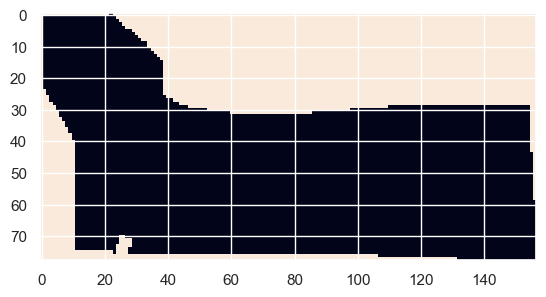

In [67]:
plt.imshow(combined_mask.reshape(aoi_height, aoi_width))
plt.show()

# Выбор порога облачности

In [68]:
white_noise_threshold = 255 # Значение [0-255]  
white_noise_count = 10000 # Количество 157*78=[0-12246]

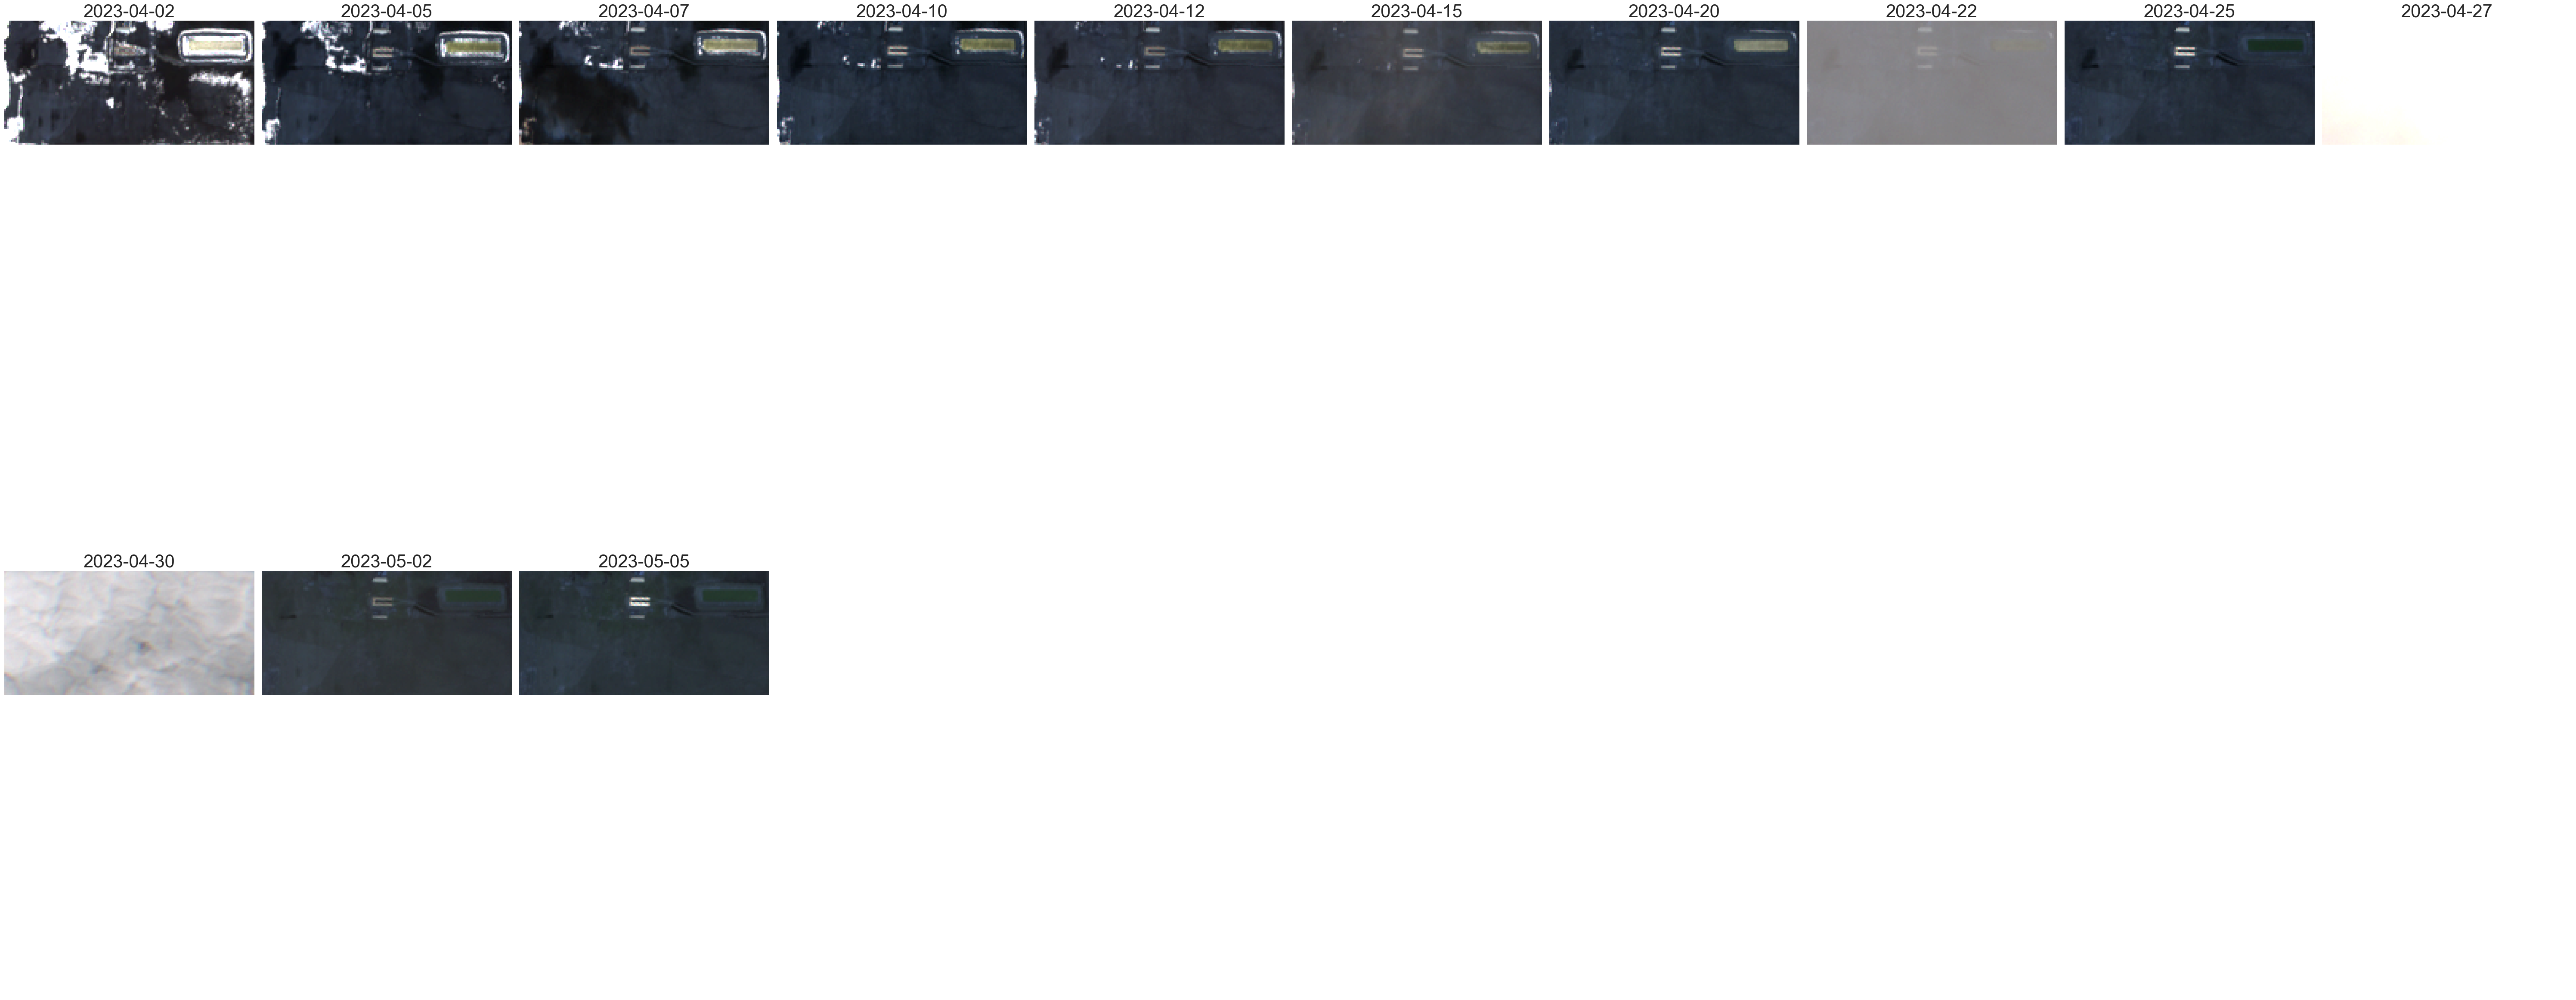

In [69]:
cols = 10
ncols, nrows = cols, ceil(len(results)/cols) 

fig, axis = plt.subplots(
    ncols=ncols, nrows=nrows, figsize=(60, 30), subplot_kw={"xticks": [], "yticks": [], "frame_on": False}
)

idx = 0
clear_date_dict = []
for i, (image, timestamp) in enumerate(zip(true_color_data, unique_acquisitions)):
    mx1 = ma.masked_array(image[:,:,0], mask=combined_mask.reshape(aoi_height, aoi_width))
    mx2 = ma.masked_array(image[:,:,1], mask=combined_mask.reshape(aoi_height, aoi_width))
    mx3 = ma.masked_array(image[:,:,2], mask=combined_mask.reshape(aoi_height, aoi_width))
    comb = mx1&mx2&mx3
    white_image = comb >= white_noise_threshold
    if white_image.sum() <= white_noise_count:
        clear_date_dict.append((str(timestamp.date().isoformat()), i))
        ax = axis[idx // ncols][idx % ncols]
        ax.imshow(np.clip(image * 2.5 / 255, 0, 1))
        ax.set_title(timestamp.date().isoformat(), fontsize=30)
        idx += 1
        
clear_date_dict = dict(clear_date_dict)
plt.tight_layout()

# Доступные даты изображении после фильтрации

In [70]:
for date in clear_date_dict:
    print(date)

2023-04-02
2023-04-05
2023-04-07
2023-04-10
2023-04-12
2023-04-15
2023-04-20
2023-04-22
2023-04-25
2023-04-27
2023-04-30
2023-05-02
2023-05-05


# Выбор доступной даты 

In [72]:
date_chosen = "2023-05-05"
image_date = clear_date_dict[date_chosen]

# Объявление вспомогательных функции

In [73]:
def normalize(band):
    band_min, band_max = (band.min(), band.max())
    return ((band-band_min)/((band_max - band_min)))

def brighten(band):
    alpha=0.13
    beta=0
    return np.clip(alpha*band+beta, 0, 255)

# Определение основных каналов

In [74]:
ULTRA_BLUE = normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B01"]]))

BLUE = normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B02"]]))
GREEN = normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B03"]]))
RED = normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B04"]]))

RED_EDGE1 = normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B05"]]))
RED_EDGE2 = normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B06"]]))
RED_EDGE3 = normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B07"]]))

NIR = normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B08"]]))
N_NIR = normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B8A"]]))
WV = normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B09"]]))
if "B10" in bands_dict:
    SWIR_C = normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B10"]]))
SWIR2 = normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B11"]]))
SWIR3 = normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B12"]]))

# Реальное изображение выбранной даты

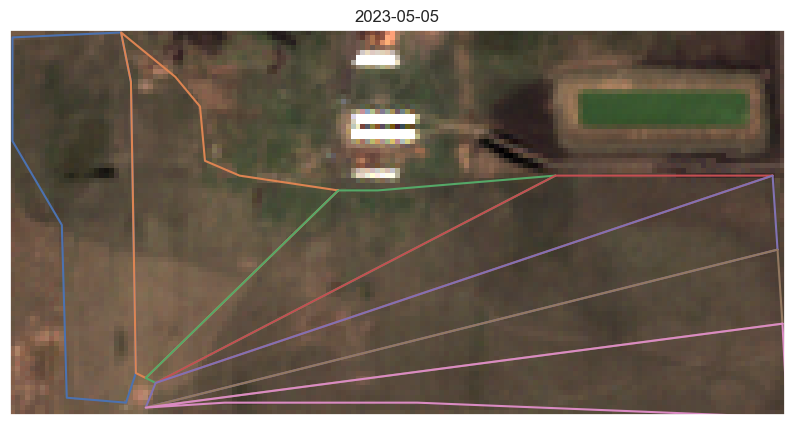

In [75]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

ep.plot_rgb(np.stack([RED, GREEN, BLUE]), ax=ax,
            title=f"{date_chosen}",
            figsize=(12, 5),
            )
plt.show()

# Normalized Difference Vegetation Index (NDVI)

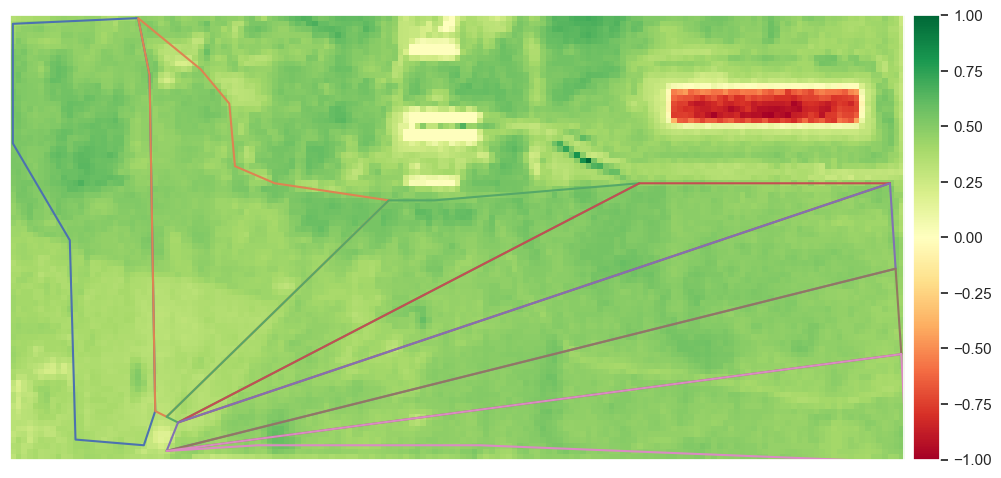

In [158]:
fig, ax = plt.subplots(figsize=(12, 12))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

ndvi = (NIR - RED) / (NIR + RED)

ep.plot_bands(ndvi, ax=ax, cmap="RdYlGn", cols=1, vmin=-1, vmax=1, figsize=(10, 14))
plt.show()

In [77]:
ndvi_masked_array = []
for i, mask in enumerate(masks):
    mx = ma.masked_array(ndvi, mask=mask.reshape(aoi_height, aoi_width))
    ndvi_masked_array.append(mx)

# Статистический анализ данных

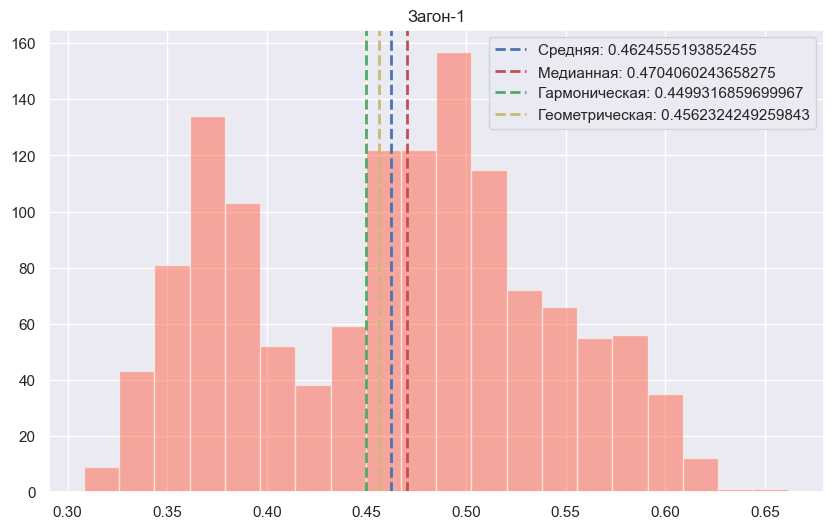

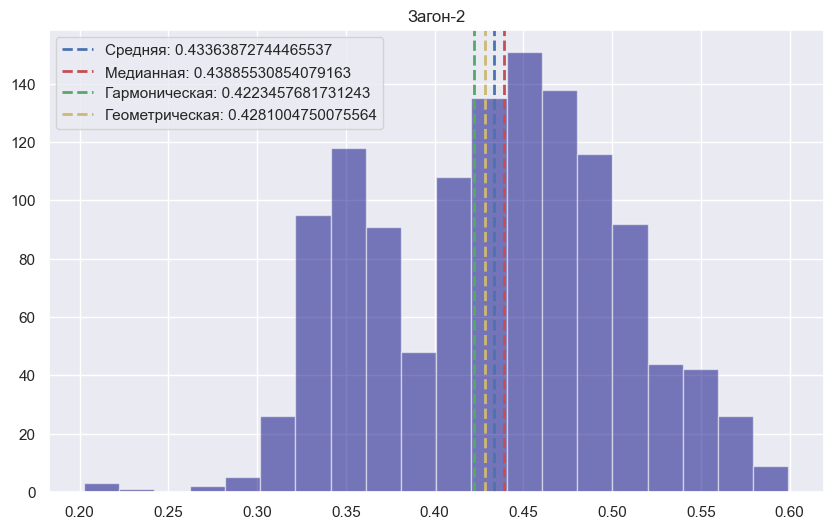

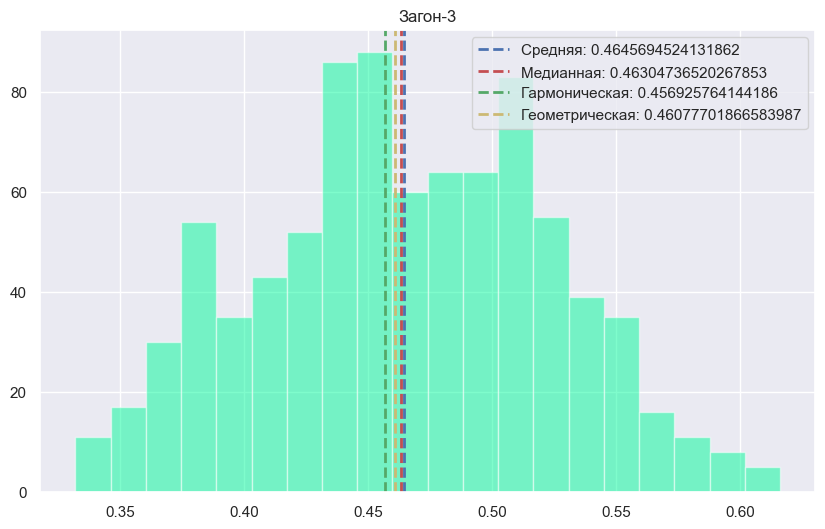

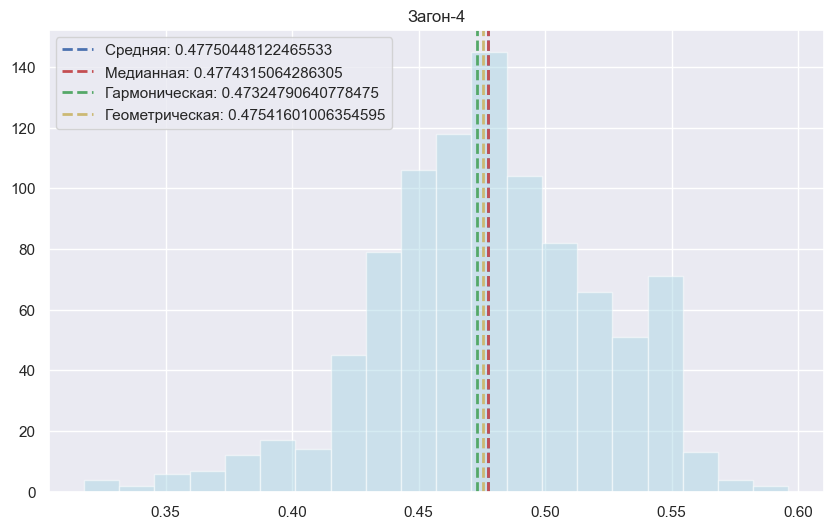

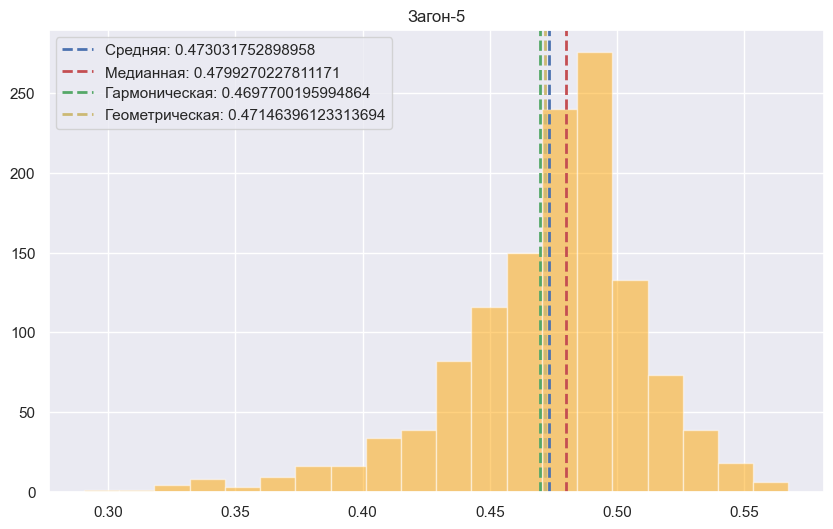

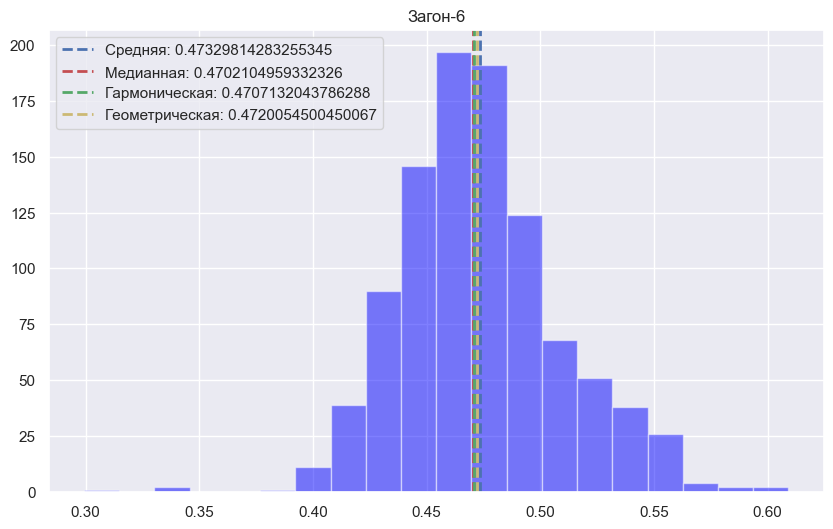

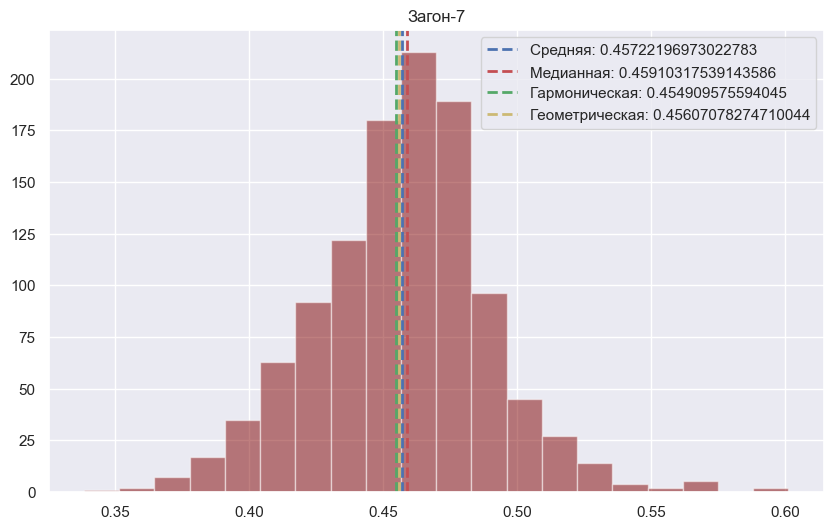

In [78]:
for i, zagon in enumerate(ndvi_masked_array):
    ep.hist(zagon, colors = colors[i], title=f'Загон-{i+1}', cols=4, alpha=0.5, 
    figsize = (10, 6))
    plt.axvline(ma.mean(ndvi_masked_array[i]), color='b', linestyle='dashed', linewidth=2)
    plt.axvline(ma.median(ndvi_masked_array[i]), color='r', linestyle='dashed', linewidth=2)
    has_negative_or_zero = ndvi_masked_array[i] <= 0
    if not has_negative_or_zero.sum():
        plt.axvline(hmean(ndvi_masked_array[i].reshape(aoi_width * aoi_height)), color='g', linestyle='dashed', linewidth=2)
        plt.axvline(gmean(ndvi_masked_array[i].reshape(aoi_width * aoi_height)), color='y', linestyle='dashed', linewidth=2)
        plt.legend([f"Средняя: {ndvi_masked_array[i].mean()}",f"Медианная: {ma.median(ndvi_masked_array[i])}",f"Гармоническая: {hmean(ndvi_masked_array[i].reshape(aoi_width * aoi_height))}",f"Геометрическая: {gmean(ndvi_masked_array[i].reshape(aoi_width * aoi_height))}"])
    else:
        plt.legend([f"Средняя: {ma.mean(ndvi_masked_array[i])}",f"Медианная: {ma.median(ndvi_masked_array[i])}"])
plt.show()

# Soil Adjusted Vegetation Index (SAVI)

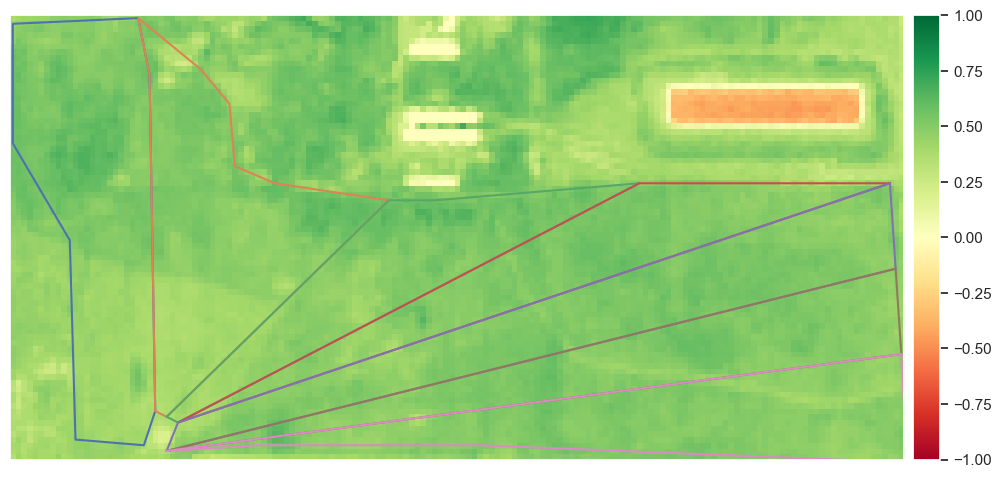

In [159]:
fig, ax = plt.subplots(figsize=(12, 12))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

L = 0.5
savi = (NIR - RED) / (NIR + RED + L) * (1 + L)

ep.plot_bands(savi, ax=ax, cmap="RdYlGn", cols=1, vmin=-1, vmax=1, figsize=(10, 14))
plt.show()

In [80]:
savi_masked_array = []
for i, mask in enumerate(masks):
    mx = ma.masked_array(savi, mask=mask.reshape(aoi_height, aoi_width))
    savi_masked_array.append(mx)

# Статистический анализ данных

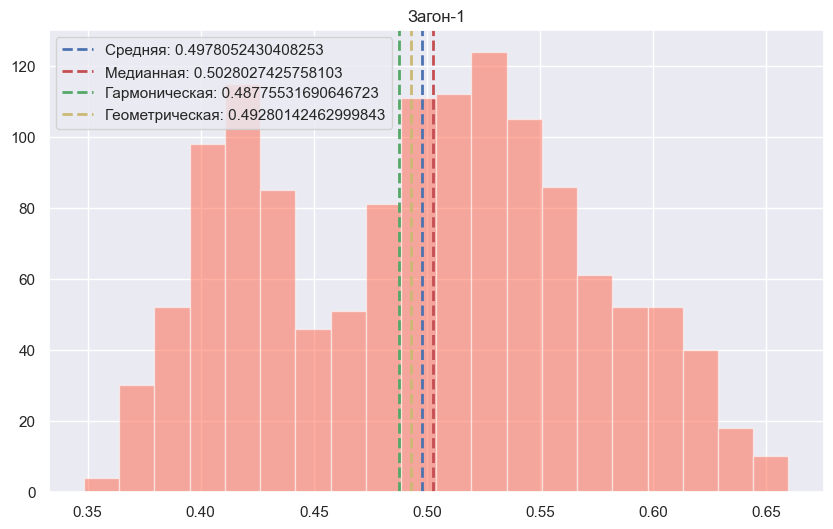

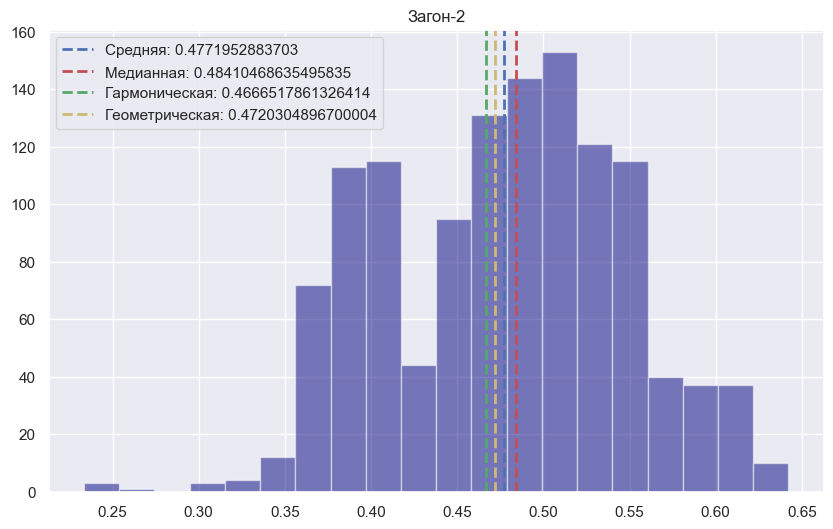

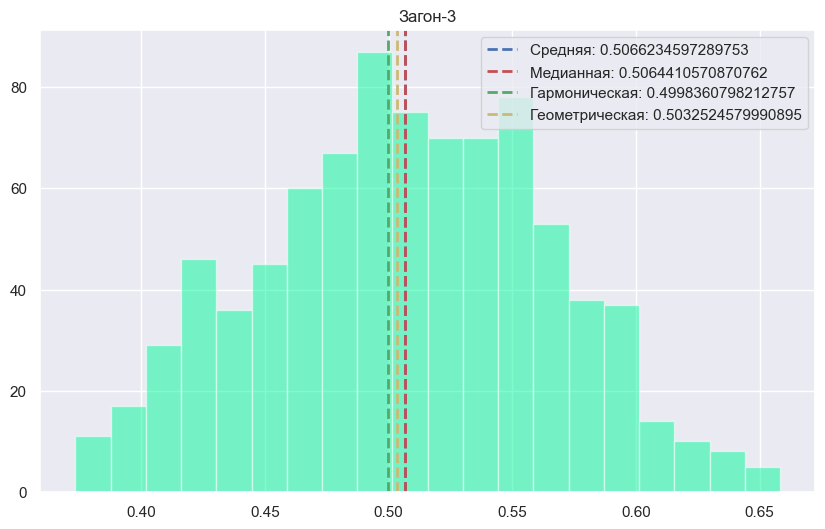

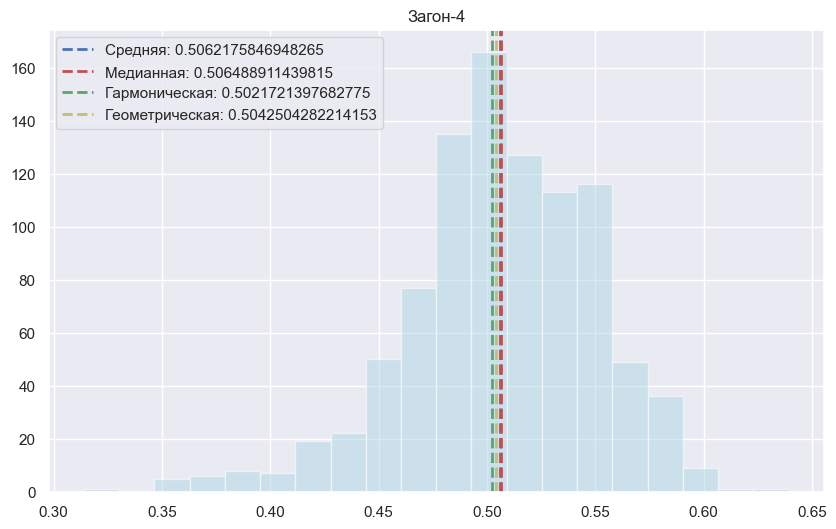

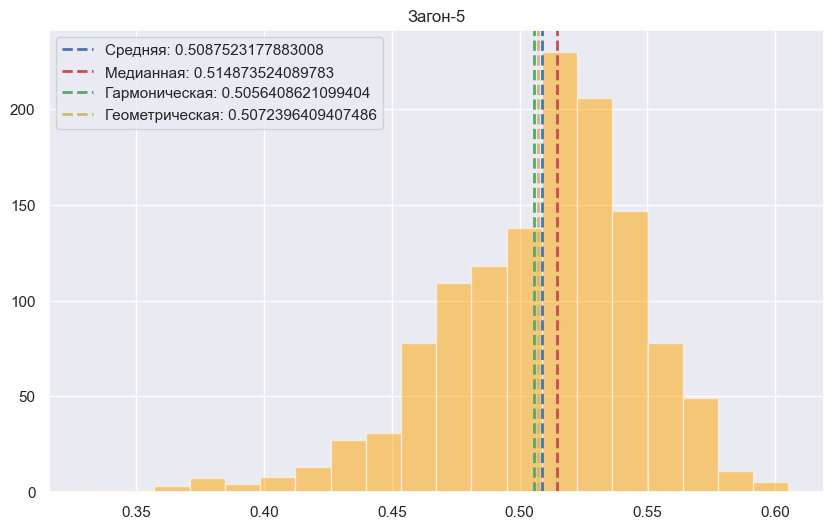

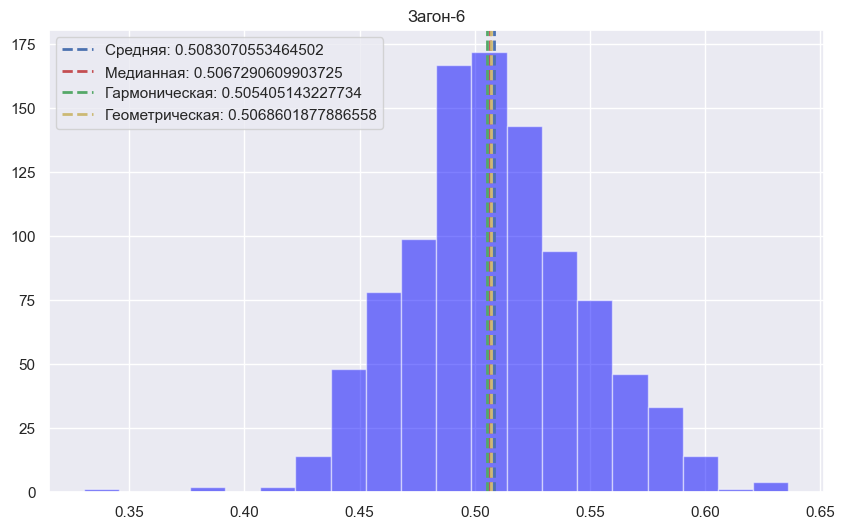

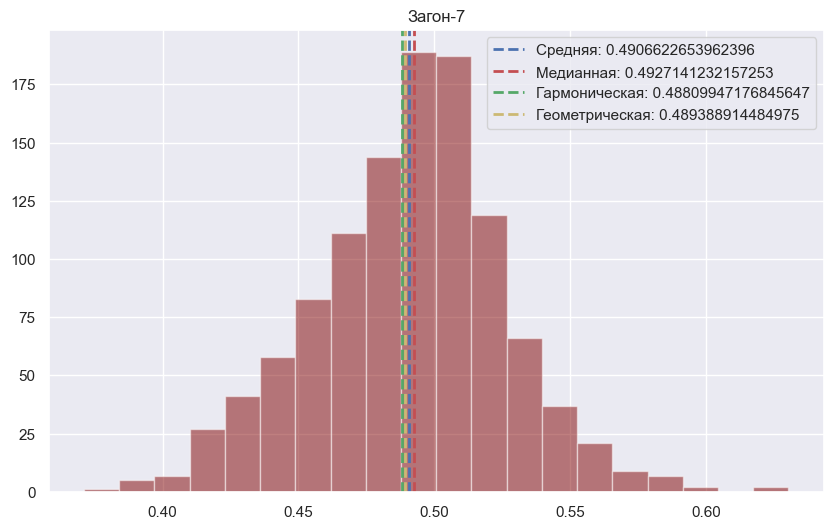

In [81]:
for i, zagon in enumerate(savi_masked_array):
    ep.hist(zagon, colors = colors[i], title=f'Загон-{i+1}', cols=4, alpha=0.5, 
    figsize = (10, 6))
    plt.axvline(savi_masked_array[i].mean(), color='b', linestyle='dashed', linewidth=2)
    plt.axvline(ma.median(savi_masked_array[i]), color='r', linestyle='dashed', linewidth=2)
    has_negative_or_zero = savi_masked_array[i] <= 0
    if not has_negative_or_zero.sum():
        plt.axvline(hmean(savi_masked_array[i].reshape(aoi_width * aoi_height)), color='g', linestyle='dashed', linewidth=2)
        plt.axvline(gmean(savi_masked_array[i].reshape(aoi_width * aoi_height)), color='y', linestyle='dashed', linewidth=2)
        plt.legend([f"Средняя: {savi_masked_array[i].mean()}",f"Медианная: {ma.median(savi_masked_array[i])}",f"Гармоническая: {hmean(savi_masked_array[i].reshape(aoi_width * aoi_height))}",f"Геометрическая: {gmean(savi_masked_array[i].reshape(aoi_width * aoi_height))}"])
    else:
        plt.legend([f"Средняя: {ma.mean(savi_masked_array[i])}",f"Медианная: {ma.median(savi_masked_array[i])}"])
plt.show()

# Red Edge Vegetation Index (REVI)

C:\Users\Пользователь\AppData\Local\Temp\ipykernel_15508\3051015822.py:6: RuntimeWarning: divide by zero encountered in true_divide
  revi = (NIR / RED_EDGE1) - 1


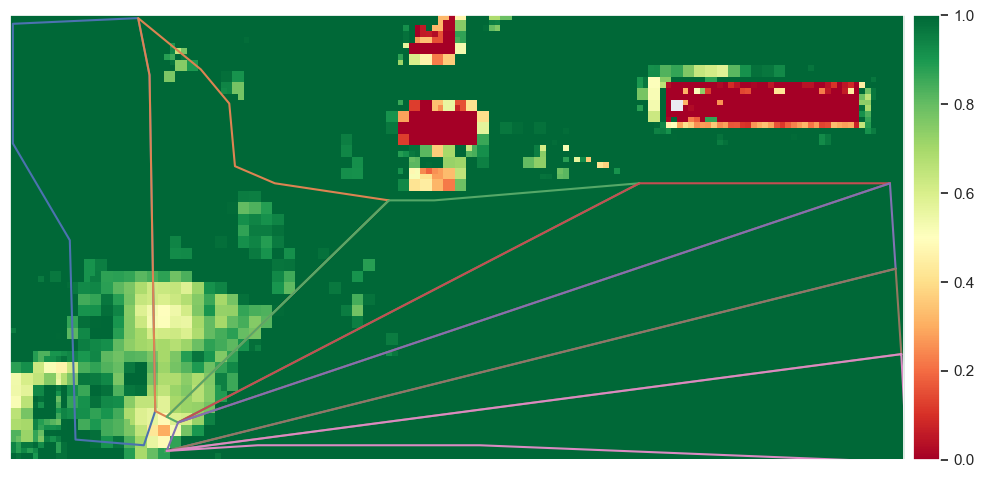

In [82]:
fig, ax = plt.subplots(figsize=(12, 12))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

revi = (NIR / RED_EDGE1) - 1

ep.plot_bands(revi, ax=ax, cmap="RdYlGn", cols=1, vmin=0, vmax=1, figsize=(10, 14))
plt.show()

In [83]:
revi_masked_array = []
for i, mask in enumerate(masks):
    mx = ma.masked_array(revi, mask=mask.reshape(aoi_height, aoi_width))
    revi_masked_array.append(mx)

# Статистический анализ данных

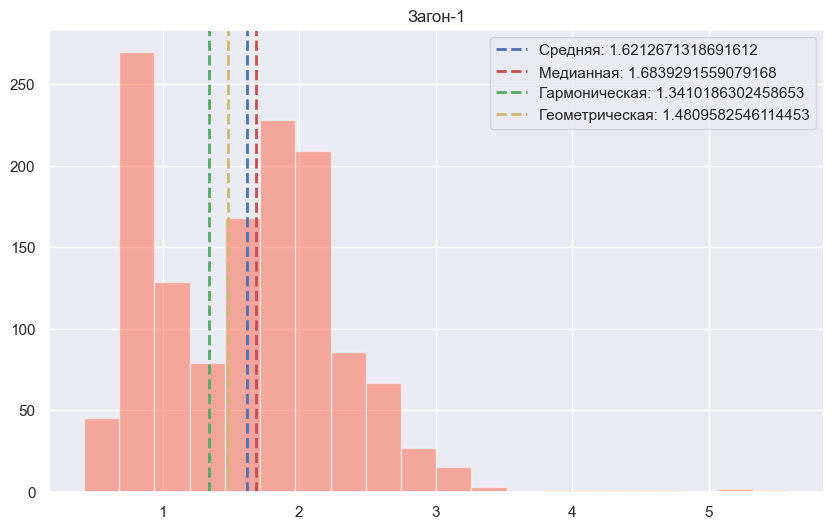

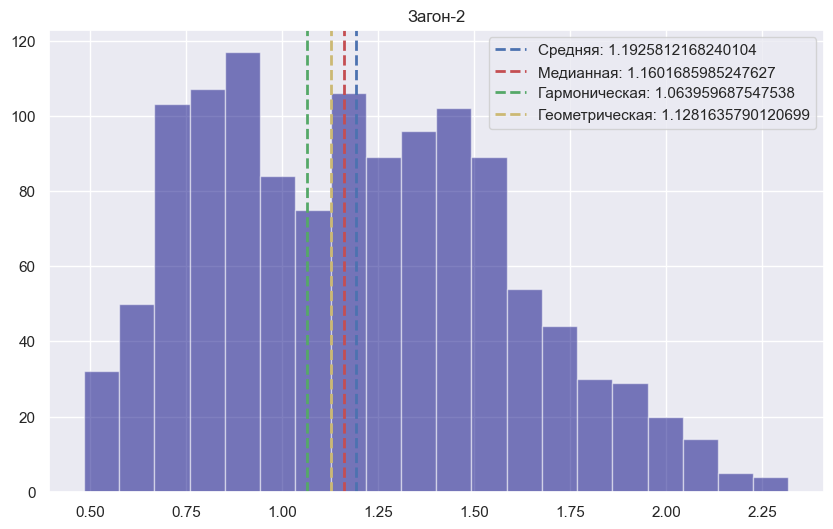

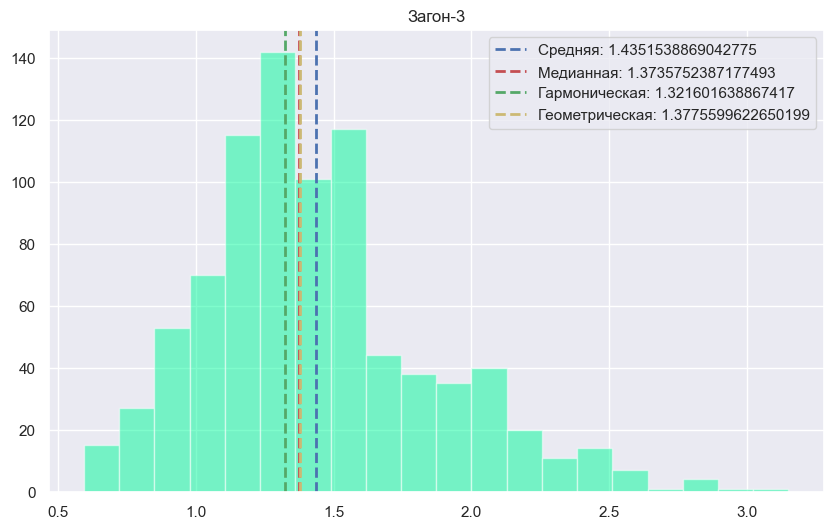

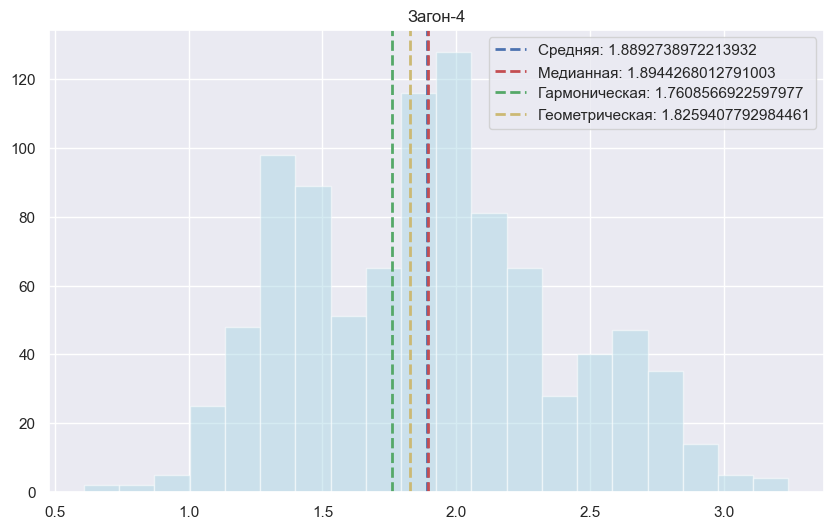

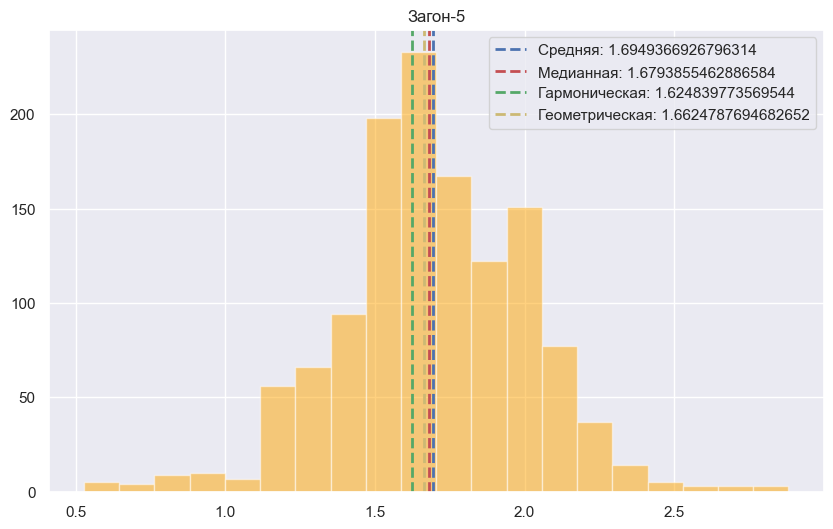

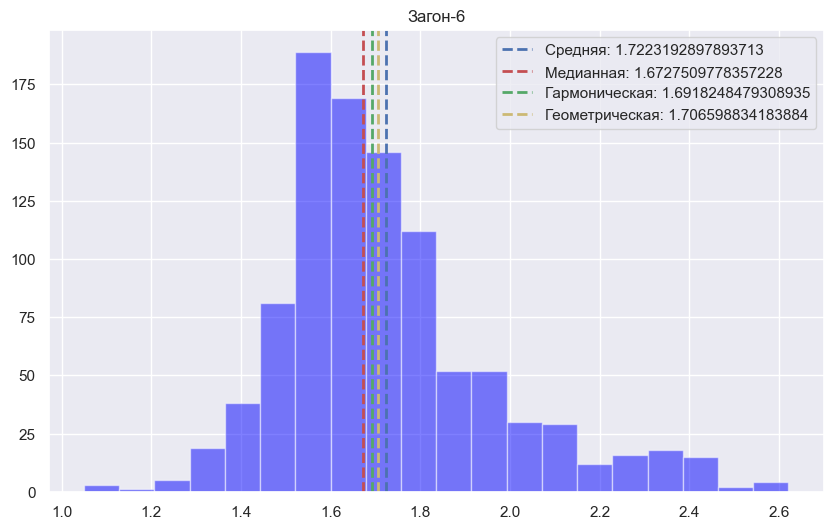

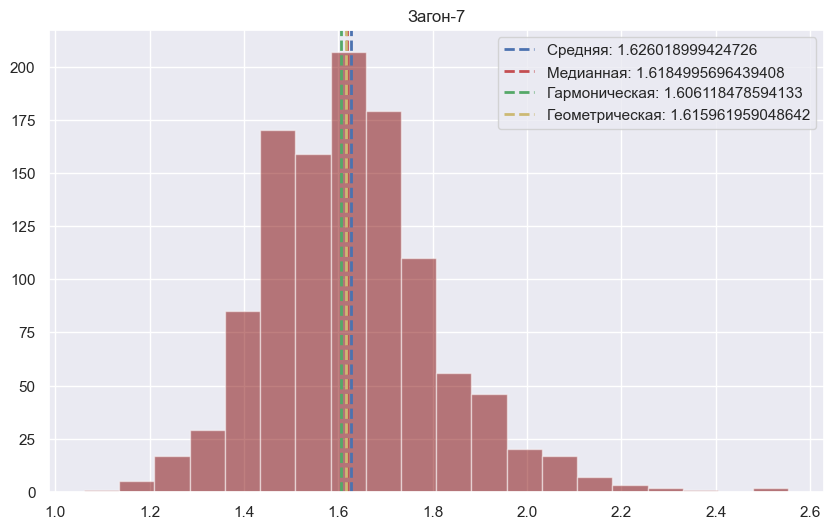

In [84]:
for i, zagon in enumerate(revi_masked_array):
    ep.hist(zagon, colors = colors[i], title=f'Загон-{i+1}', cols=4, alpha=0.5, 
    figsize = (10, 6))
    plt.axvline(revi_masked_array[i].mean(), color='b', linestyle='dashed', linewidth=2)
    plt.axvline(ma.median(revi_masked_array[i]), color='r', linestyle='dashed', linewidth=2)
    has_negative_or_zero = revi_masked_array[i] <= 0
    if not has_negative_or_zero.sum():
        plt.axvline(hmean(revi_masked_array[i].reshape(aoi_width * aoi_height)), color='g', linestyle='dashed', linewidth=2)
        plt.axvline(gmean(revi_masked_array[i].reshape(aoi_width * aoi_height)), color='y', linestyle='dashed', linewidth=2)
        plt.legend([f"Средняя: {revi_masked_array[i].mean()}",f"Медианная: {ma.median(revi_masked_array[i])}",f"Гармоническая: {hmean(revi_masked_array[i].reshape(aoi_width * aoi_height))}",f"Геометрическая: {gmean(revi_masked_array[i].reshape(aoi_width * aoi_height))}"])
    else:
        plt.legend([f"Средняя: {ma.mean(revi_masked_array[i])}",f"Медианная: {ma.median(revi_masked_array[i])}"])
plt.show()

# Enhanced Vegetation Index (EVI)

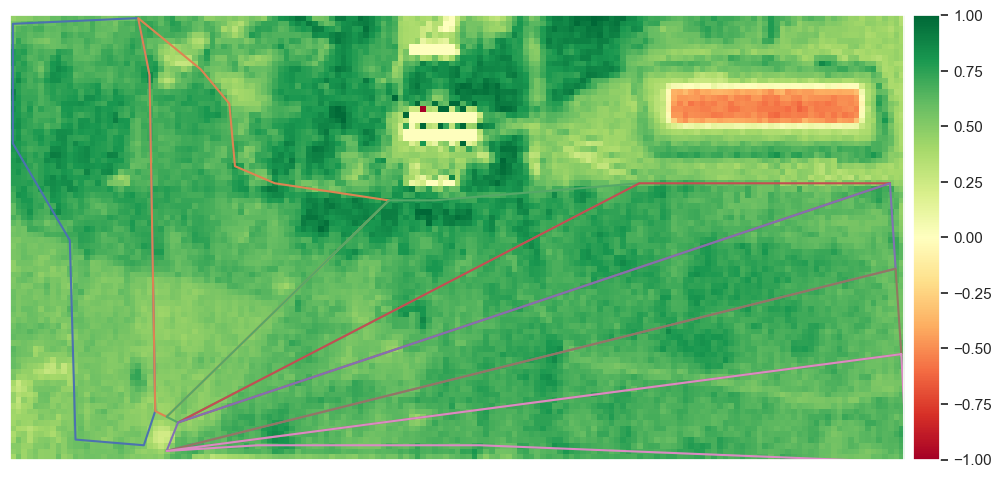

In [85]:
fig, ax = plt.subplots(figsize=(12, 12))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

evi = 2.5 * (NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1)

ep.plot_bands(evi, ax=ax, cmap="RdYlGn", cols=1, vmin=-1, vmax=1, figsize=(10, 14))
plt.show()

In [86]:
evi_masked_array = []
for i, mask in enumerate(masks):
    mx = ma.masked_array(evi, mask=mask.reshape(aoi_height, aoi_width))
    evi_masked_array.append(mx)

# Статистический анализ данных

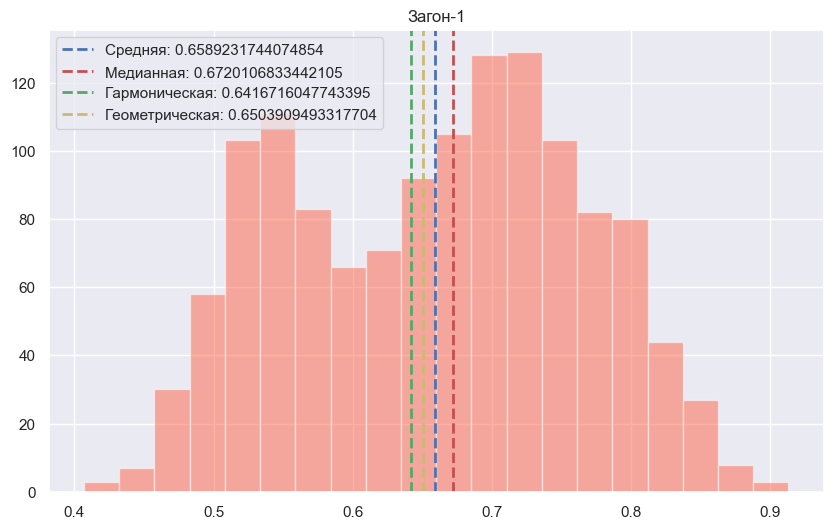

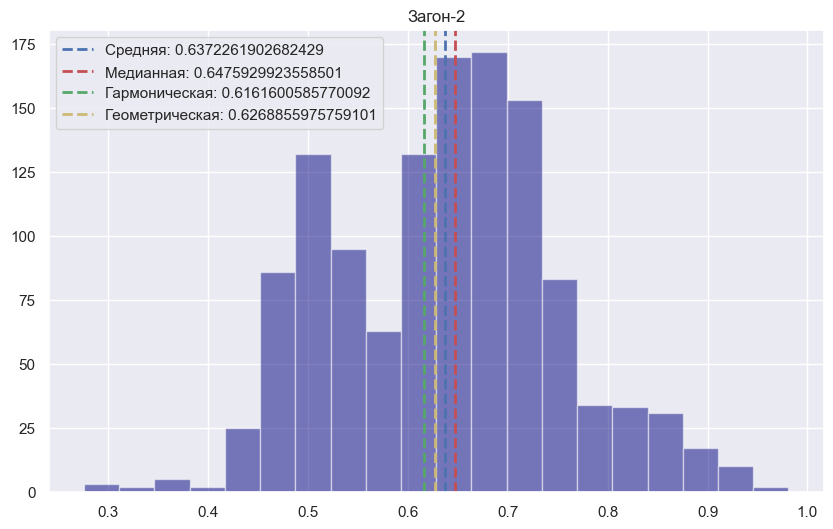

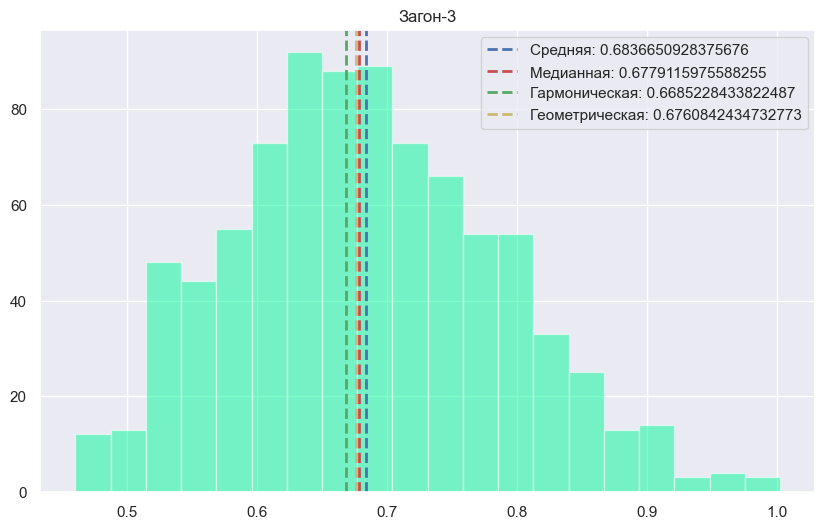

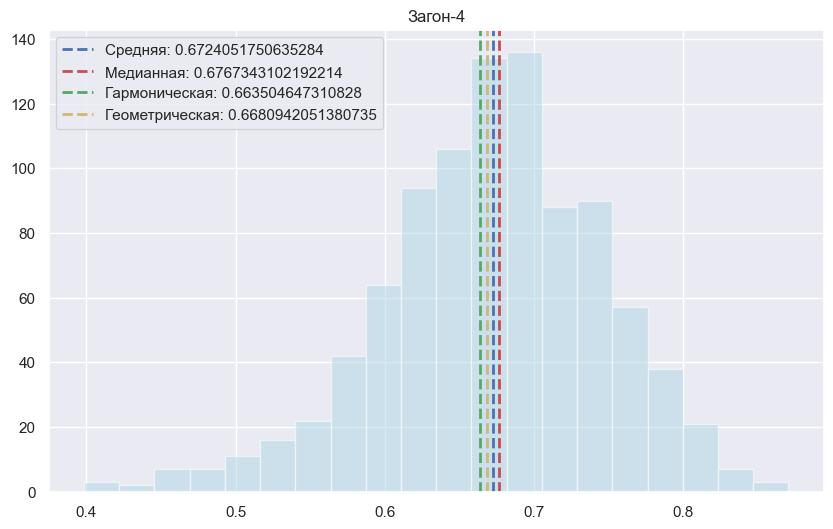

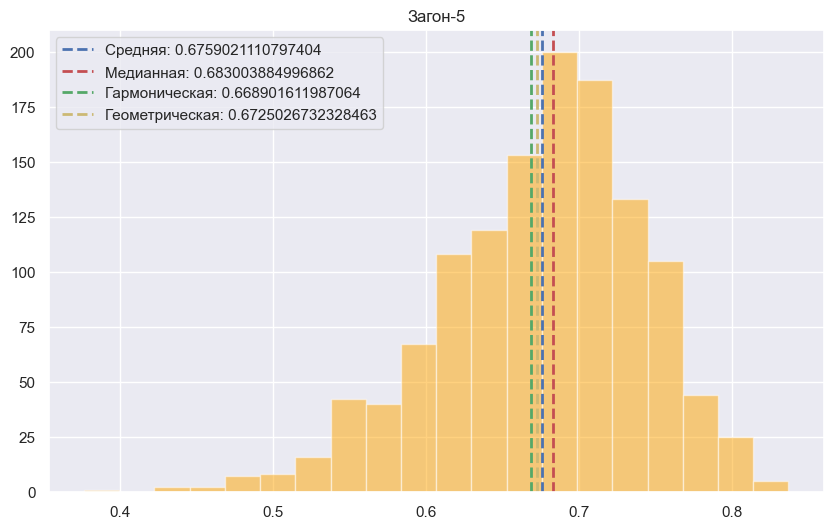

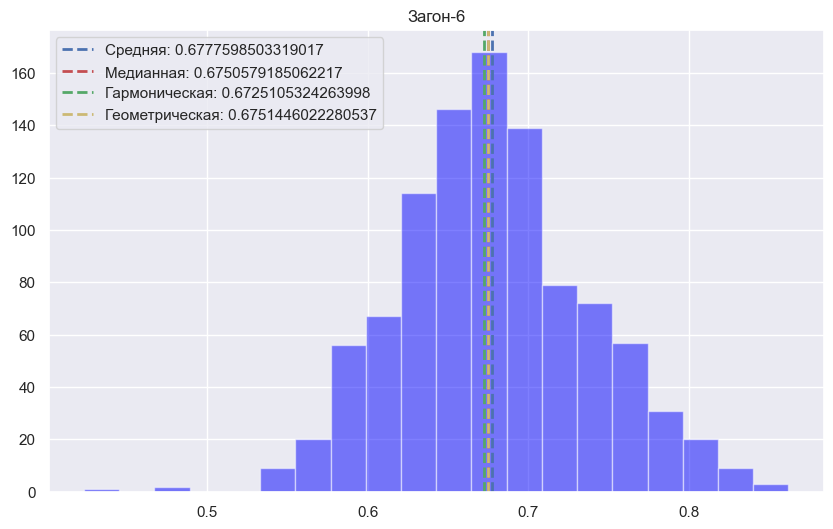

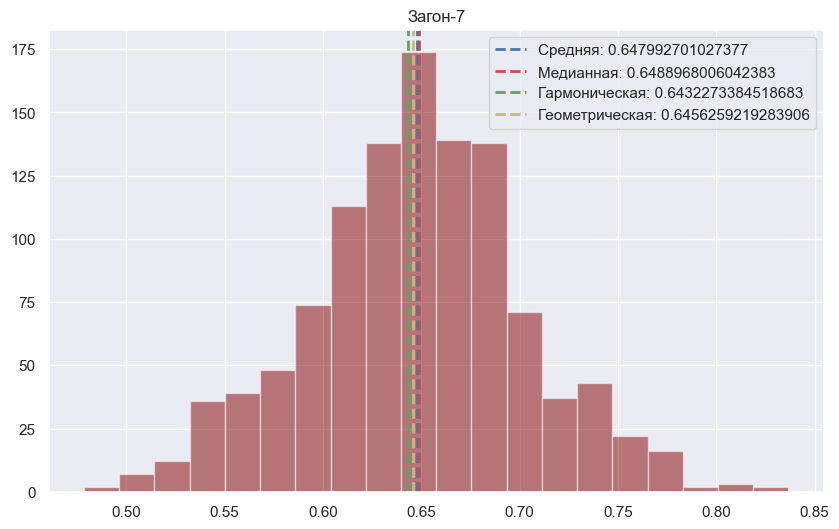

In [87]:
for i, zagon in enumerate(evi_masked_array):
    ep.hist(zagon, colors = colors[i], title=f'Загон-{i+1}', cols=4, alpha=0.5, 
    figsize = (10, 6))
    plt.axvline(evi_masked_array[i].mean(), color='b', linestyle='dashed', linewidth=2)
    plt.axvline(ma.median(evi_masked_array[i]), color='r', linestyle='dashed', linewidth=2)
    has_negative_or_zero = evi_masked_array[i] <= 0
    if not has_negative_or_zero.sum():
        plt.axvline(hmean(evi_masked_array[i].reshape(aoi_width * aoi_height)), color='g', linestyle='dashed', linewidth=2)
        plt.axvline(gmean(evi_masked_array[i].reshape(aoi_width * aoi_height)), color='y', linestyle='dashed', linewidth=2)
        plt.legend([f"Средняя: {evi_masked_array[i].mean()}",f"Медианная: {ma.median(evi_masked_array[i])}",f"Гармоническая: {hmean(evi_masked_array[i].reshape(aoi_width * aoi_height))}",f"Геометрическая: {gmean(evi_masked_array[i].reshape(aoi_width * aoi_height))}"])
    else:
        plt.legend([f"Средняя: {ma.mean(evi_masked_array[i])}",f"Медианная: {ma.median(evi_masked_array[i])}"])
plt.show()

# Transformed Vegetation Index (TVI)

C:\Users\Пользователь\AppData\Local\Temp\ipykernel_15508\2875448094.py:6: RuntimeWarning: invalid value encountered in sqrt
  tvi = np.sqrt((NIR - RED) / (NIR + RED) + 0.0)


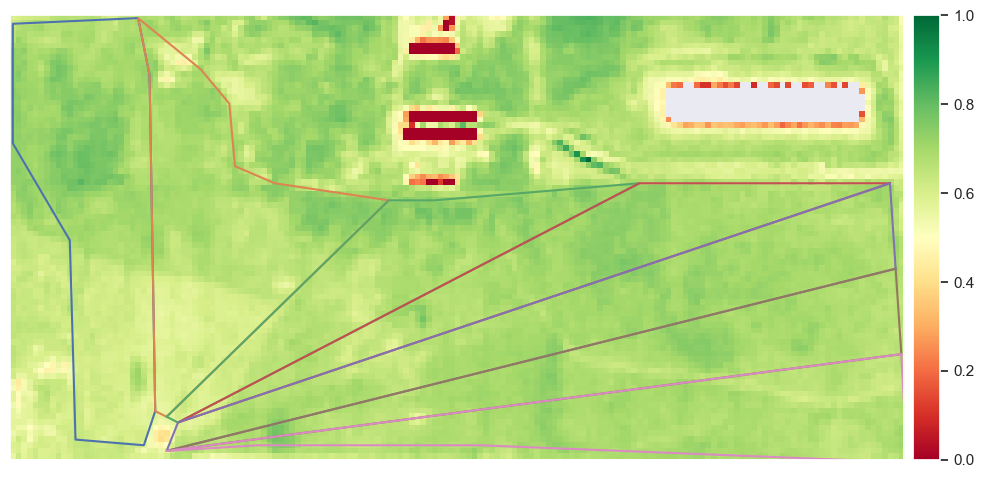

In [88]:
fig, ax = plt.subplots(figsize=(12, 12))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

tvi = np.sqrt((NIR - RED) / (NIR + RED) + 0.0)

ep.plot_bands(tvi, ax=ax, cmap="RdYlGn", cols=1, vmin=0, vmax=1, figsize=(10, 14))
plt.show()

In [89]:
tvi_masked_array = []
for i, mask in enumerate(masks):
    mx = ma.masked_array(tvi, mask=mask.reshape(aoi_height, aoi_width))
    tvi_masked_array.append(mx)

# Статистический анализ данных

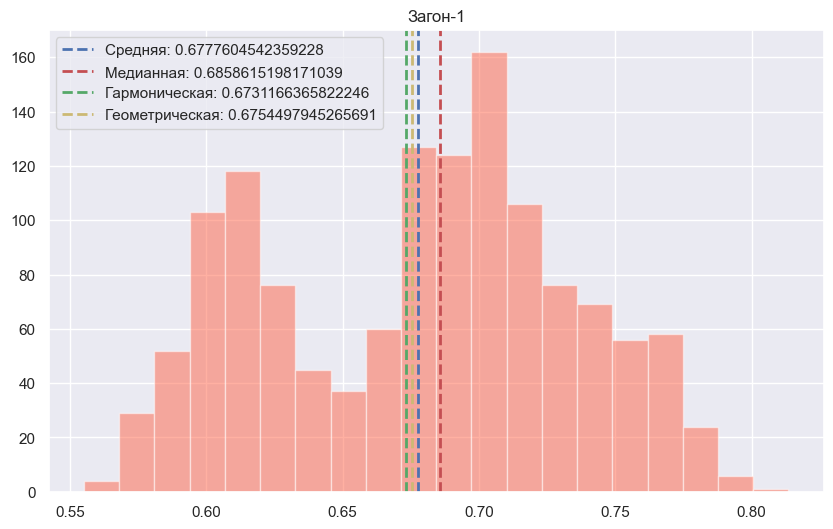

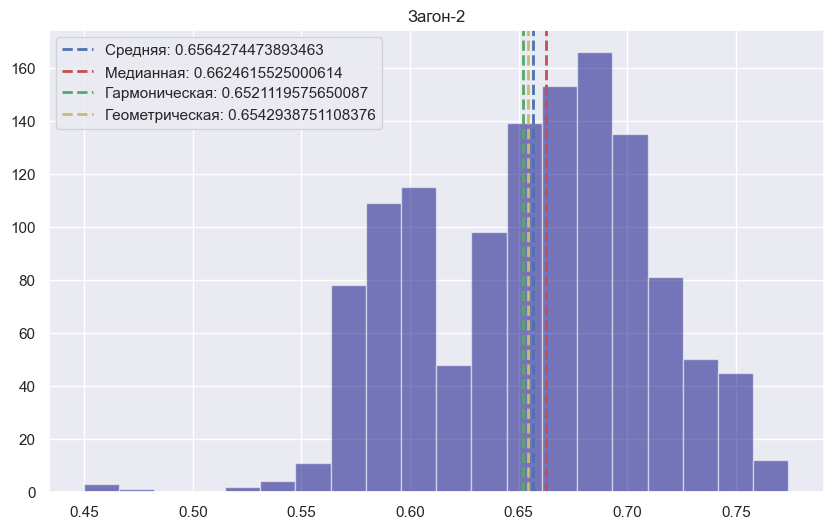

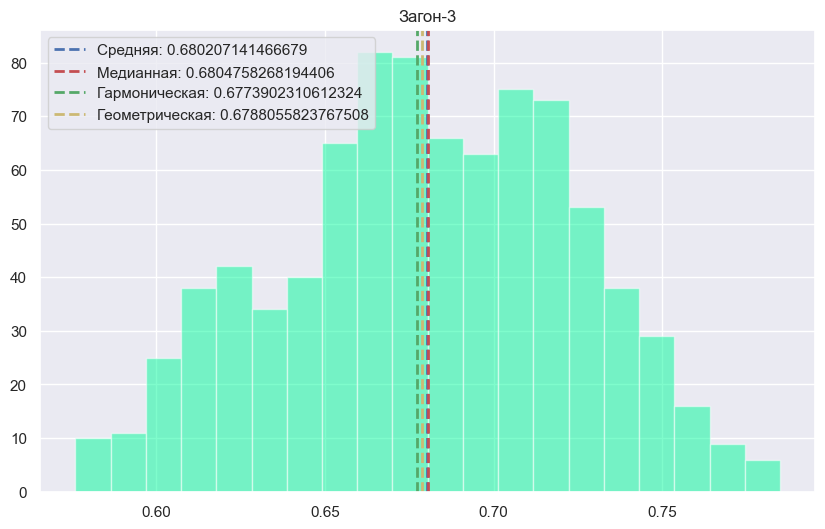

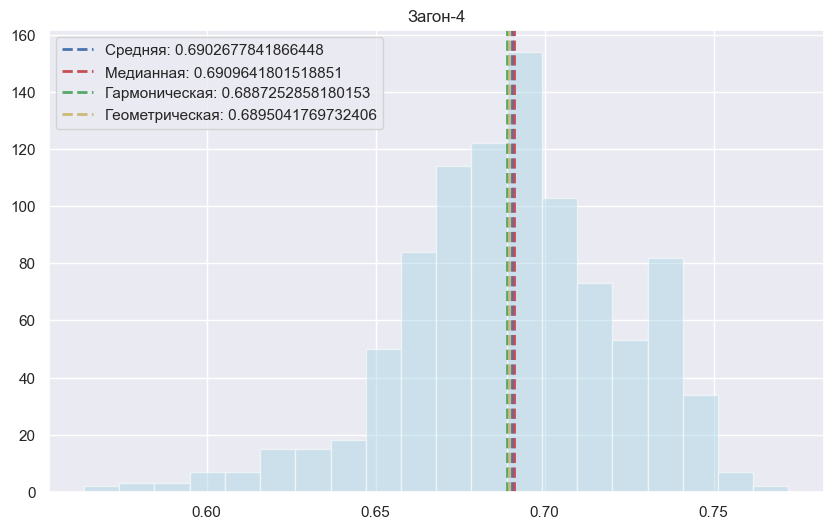

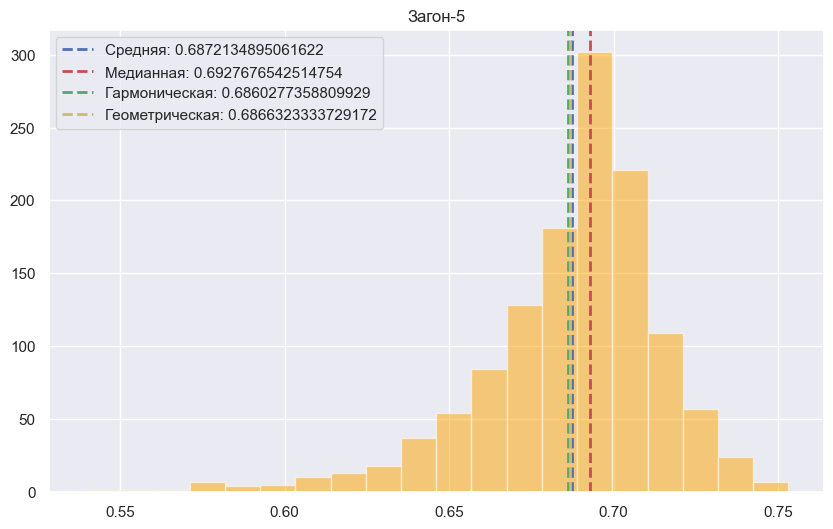

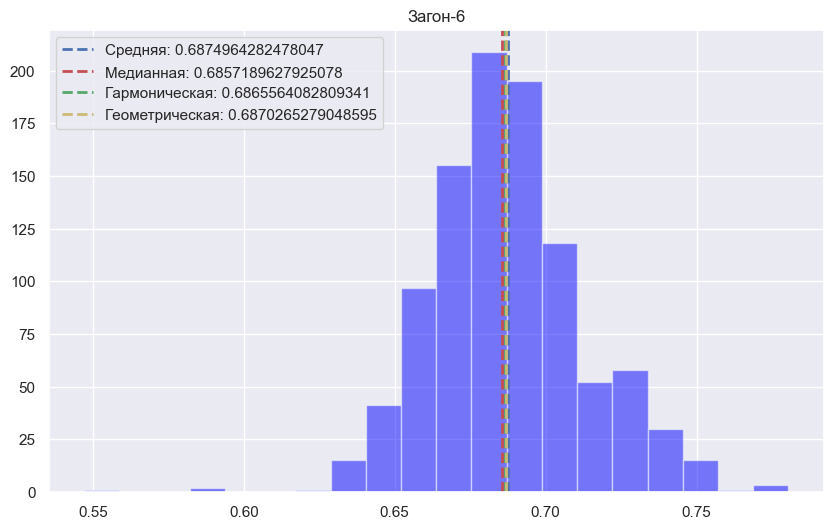

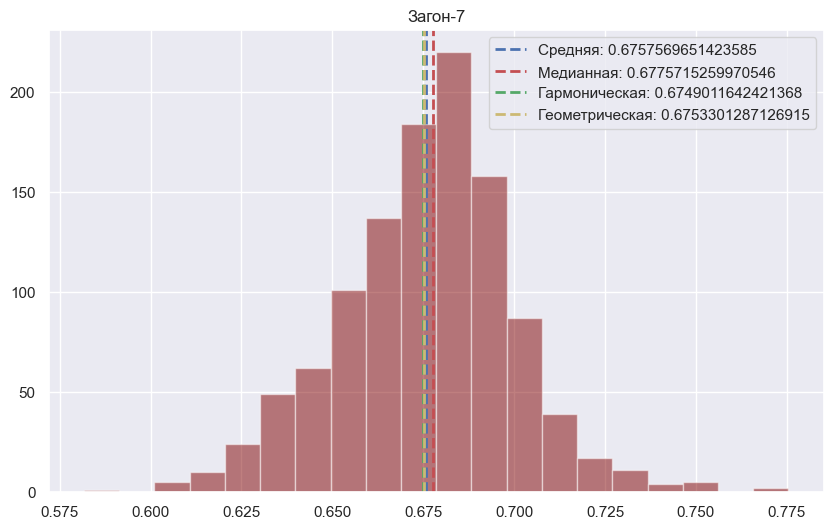

In [90]:
for i, zagon in enumerate(tvi_masked_array):
    ep.hist(zagon, colors = colors[i], title=f'Загон-{i+1}', cols=4, alpha=0.5, 
    figsize = (10, 6))
    plt.axvline(tvi_masked_array[i].mean(), color='b', linestyle='dashed', linewidth=2)
    plt.axvline(ma.median(tvi_masked_array[i]), color='r', linestyle='dashed', linewidth=2)
    has_negative_or_zero = tvi_masked_array[i] <= 0
    if not has_negative_or_zero.sum():
        plt.axvline(hmean(tvi_masked_array[i].reshape(aoi_width * aoi_height)), color='g', linestyle='dashed', linewidth=2)
        plt.axvline(gmean(tvi_masked_array[i].reshape(aoi_width * aoi_height)), color='y', linestyle='dashed', linewidth=2)
        plt.legend([f"Средняя: {tvi_masked_array[i].mean()}",f"Медианная: {ma.median(tvi_masked_array[i])}",f"Гармоническая: {hmean(tvi_masked_array[i].reshape(aoi_width * aoi_height))}",f"Геометрическая: {gmean(tvi_masked_array[i].reshape(aoi_width * aoi_height))}"])
    else:
        plt.legend([f"Средняя: {ma.mean(tvi_masked_array[i])}",f"Медианная: {ma.median(tvi_masked_array[i])}"])
plt.show()

# Green Normalized Difference Vegetation Index (GNDVI)

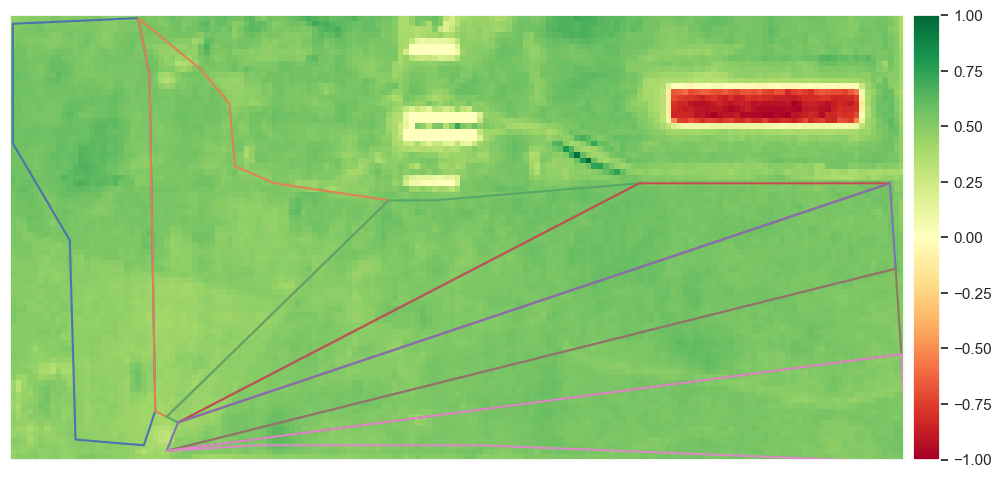

In [91]:
fig, ax = plt.subplots(figsize=(12, 12))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

gndvi = (NIR - GREEN) / (NIR + GREEN)    

ep.plot_bands(gndvi, ax=ax, cmap="RdYlGn", cols=1, vmin=gndvi.min(), vmax=gndvi.max(), figsize=(10, 14))
plt.show()

In [92]:
gndvi_masked_array = []
for i, mask in enumerate(masks):
    mx = ma.masked_array(gndvi, mask=mask.reshape(aoi_height, aoi_width))
    gndvi_masked_array.append(mx)

# Статистический анализ данных

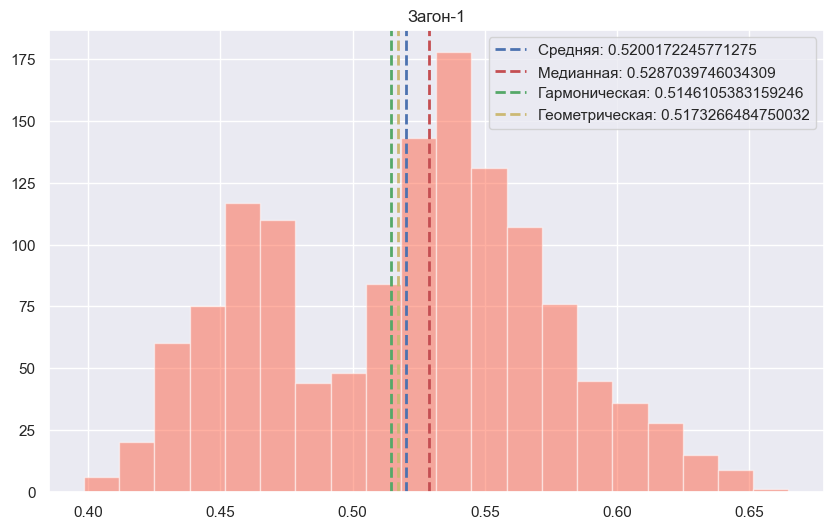

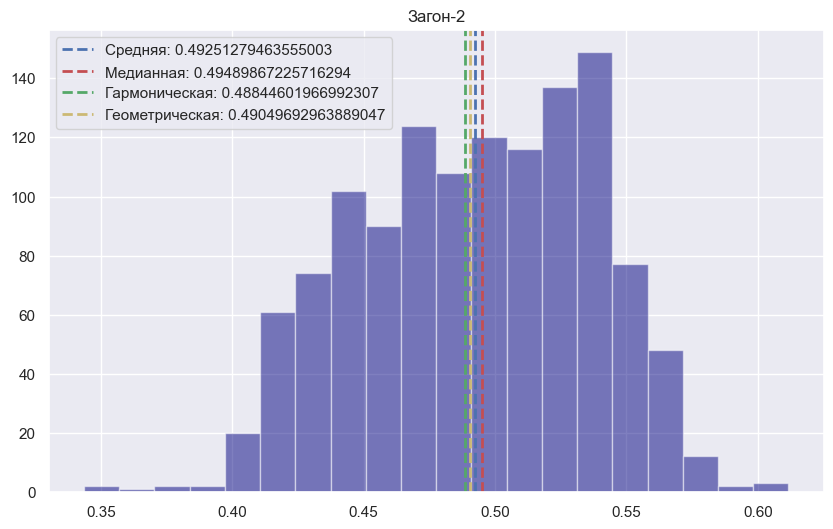

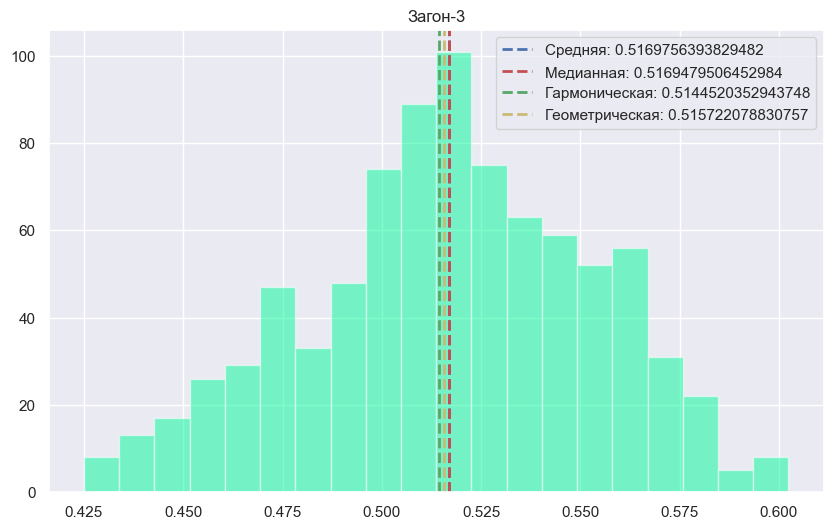

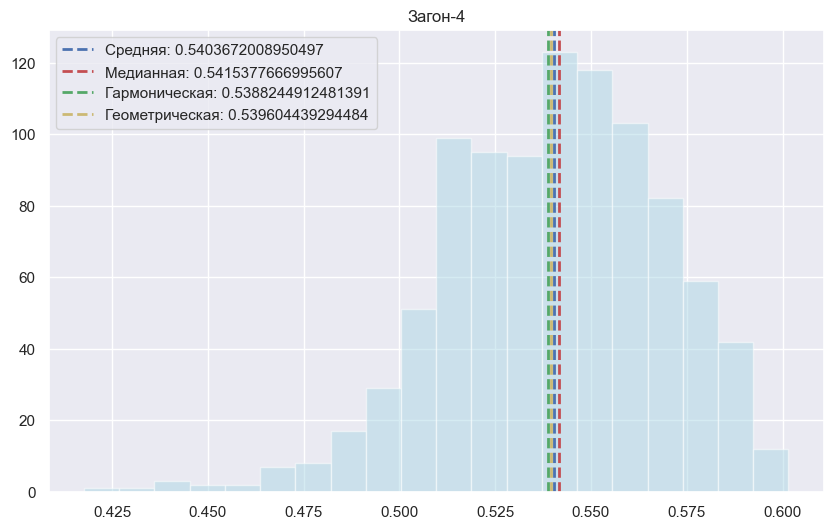

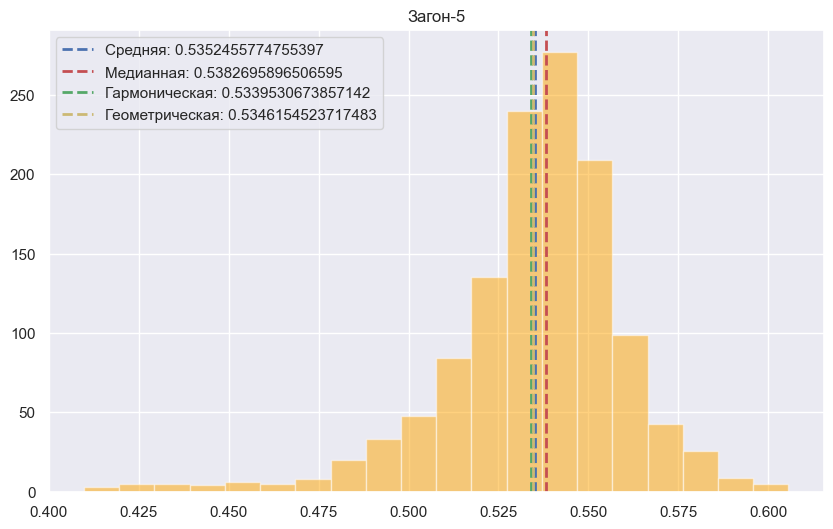

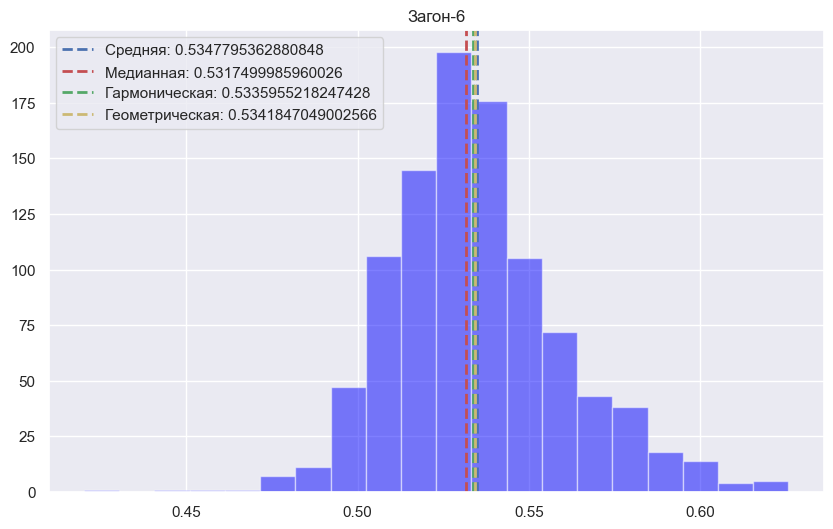

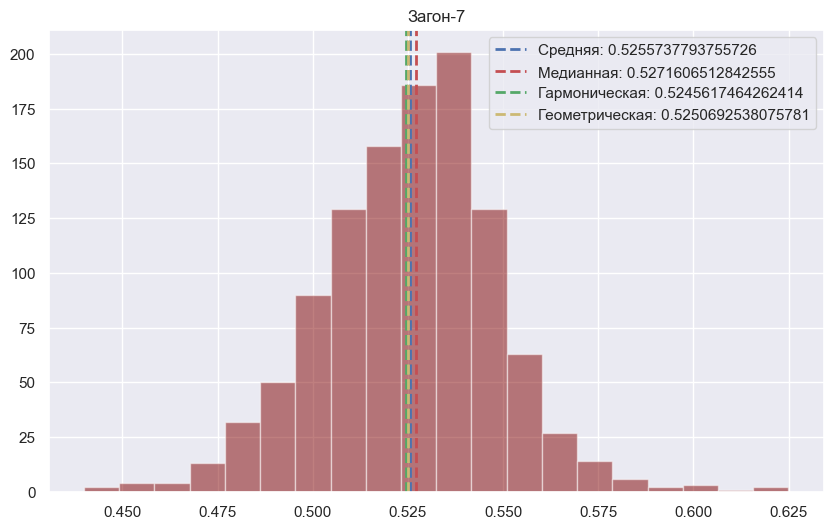

In [93]:
for i, zagon in enumerate(gndvi_masked_array):
    ep.hist(zagon, colors = colors[i], title=f'Загон-{i+1}', cols=4, alpha=0.5, 
    figsize = (10, 6))
    plt.axvline(gndvi_masked_array[i].mean(), color='b', linestyle='dashed', linewidth=2)
    plt.axvline(ma.median(gndvi_masked_array[i]), color='r', linestyle='dashed', linewidth=2)
    has_negative_or_zero = gndvi_masked_array[i] <= 0
    if not has_negative_or_zero.sum():
        plt.axvline(hmean(gndvi_masked_array[i].reshape(aoi_width * aoi_height)), color='g', linestyle='dashed', linewidth=2)
        plt.axvline(gmean(gndvi_masked_array[i].reshape(aoi_width * aoi_height)), color='y', linestyle='dashed', linewidth=2)
        plt.legend([f"Средняя: {gndvi_masked_array[i].mean()}",f"Медианная: {ma.median(gndvi_masked_array[i])}",f"Гармоническая: {hmean(gndvi_masked_array[i].reshape(aoi_width * aoi_height))}",f"Геометрическая: {gmean(gndvi_masked_array[i].reshape(aoi_width * aoi_height))}"])
    else:
        plt.legend([f"Средняя: {ma.mean(gndvi_masked_array[i])}",f"Медианная: {ma.median(gndvi_masked_array[i])}"])
plt.show()

# Normalized Difference Infrared Index (NDII)

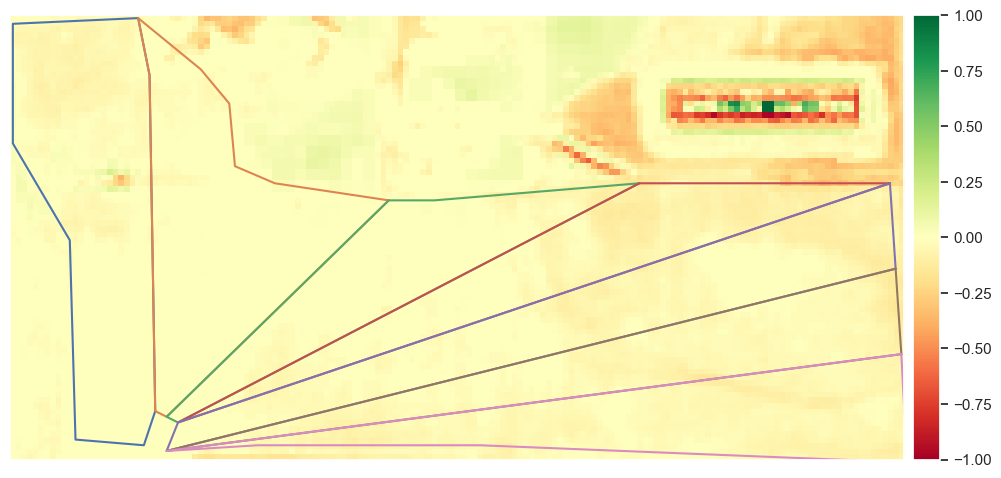

In [94]:
fig, ax = plt.subplots(figsize=(12, 12))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

ndii = (NIR - SWIR3) / (NIR + SWIR3)

ep.plot_bands(ndii, ax=ax, cmap="RdYlGn", cols=1, vmin=ndii.min(), vmax=ndii.max(), figsize=(10, 14))
plt.show()

In [95]:
ndii_masked_array = []
for i, mask in enumerate(masks):
    mx = ma.masked_array(ndii, mask=mask.reshape(aoi_height, aoi_width))
    ndii_masked_array.append(mx)

# Статистический анализ данных

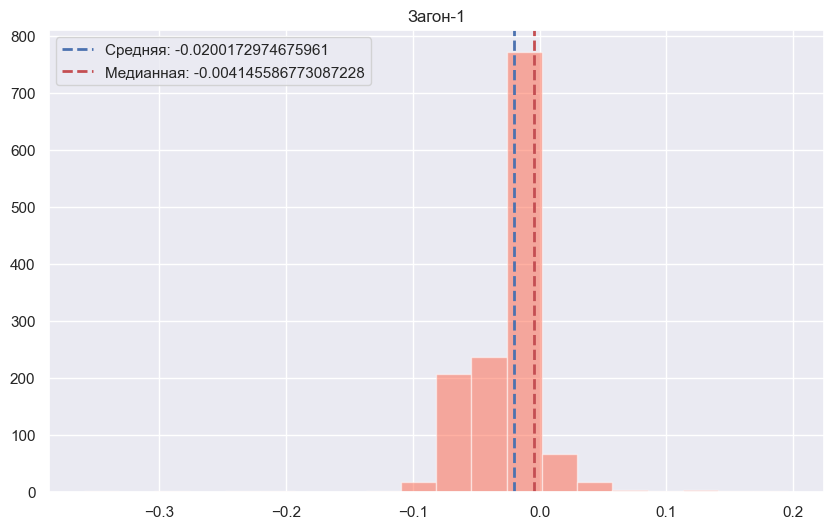

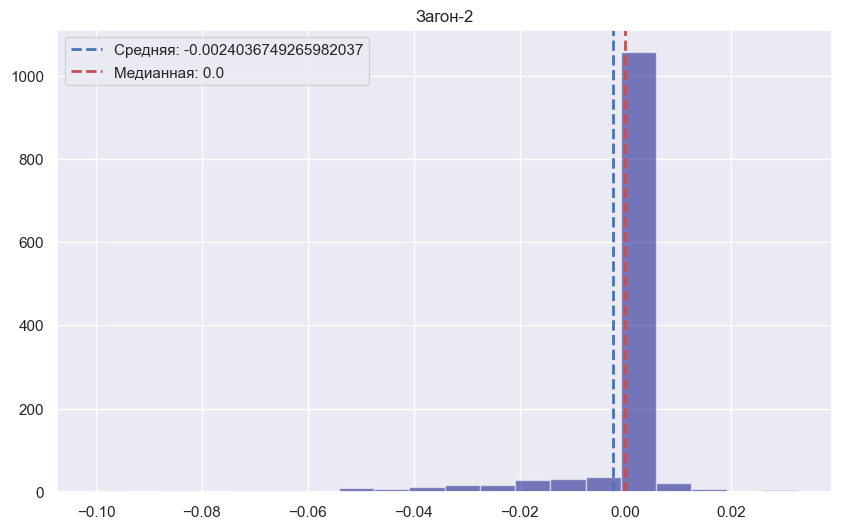

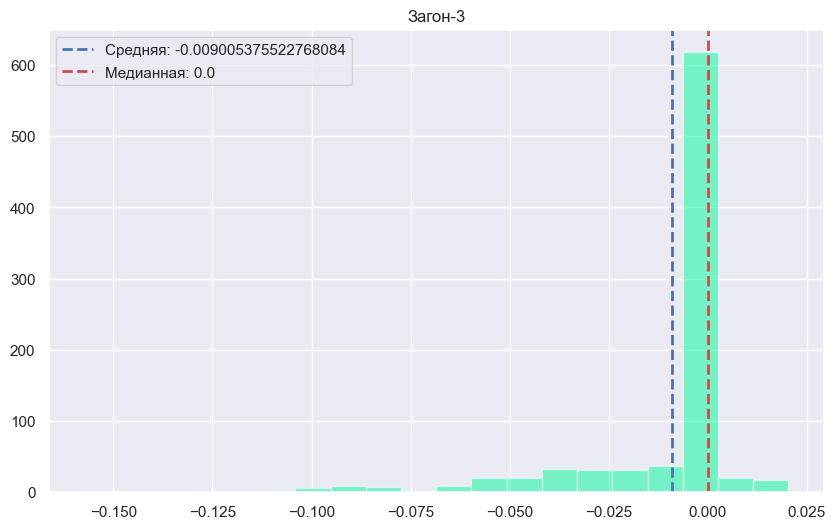

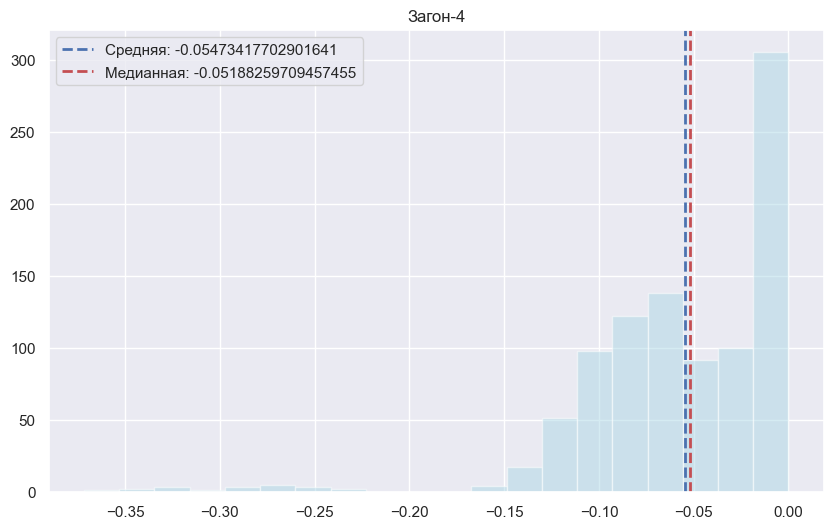

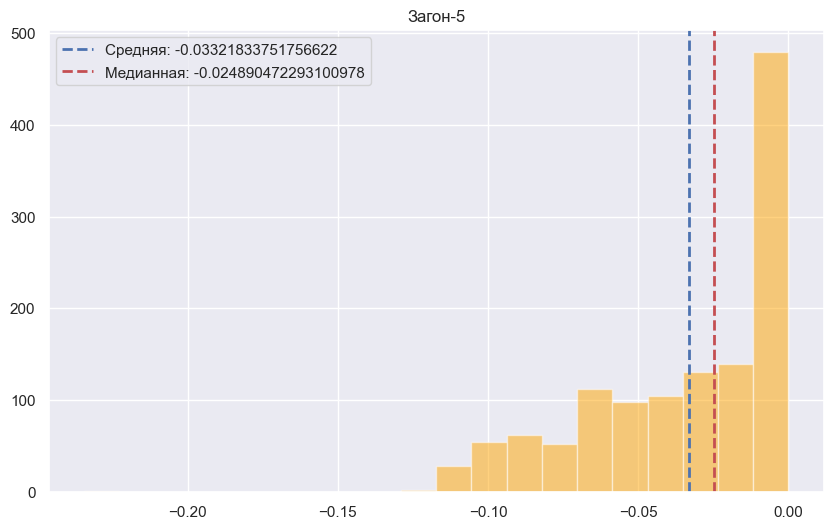

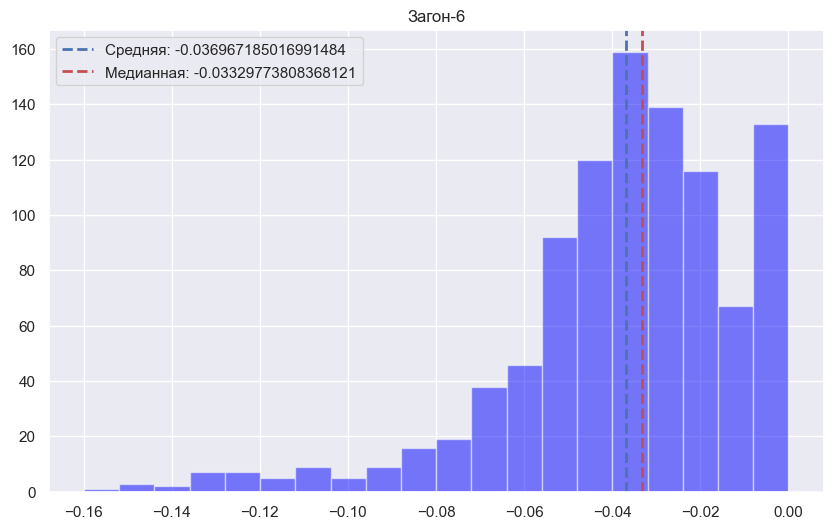

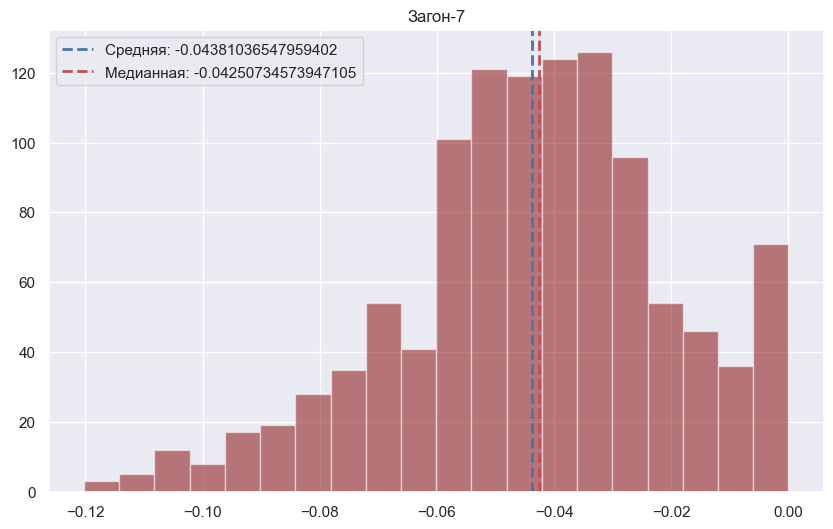

In [96]:
for i, zagon in enumerate(ndii_masked_array):
    ep.hist(zagon, colors = colors[i], title=f'Загон-{i+1}', cols=4, alpha=0.5, 
    figsize = (10, 6))
    plt.axvline(ndii_masked_array[i].mean(), color='b', linestyle='dashed', linewidth=2)
    plt.axvline(ma.median(ndii_masked_array[i]), color='r', linestyle='dashed', linewidth=2)
    has_negative_or_zero = ndii_masked_array[i] <= 0
    if not has_negative_or_zero.sum():
        plt.axvline(hmean(ndii_masked_array[i].reshape(aoi_width * aoi_height)), color='g', linestyle='dashed', linewidth=2)
        plt.axvline(gmean(ndii_masked_array[i].reshape(aoi_width * aoi_height)), color='y', linestyle='dashed', linewidth=2)
        plt.legend([f"Средняя: {ndii_masked_array[i].mean()}",f"Медианная: {ma.median(ndii_masked_array[i])}",f"Гармоническая: {hmean(ndii_masked_array[i].reshape(aoi_width * aoi_height))}",f"Геометрическая: {gmean(ndii_masked_array[i].reshape(aoi_width * aoi_height))}"])
    else:
        plt.legend([f"Средняя: {ma.mean(ndii_masked_array[i])}",f"Медианная: {ma.median(ndii_masked_array[i])}"])
plt.show()

# Chlorophyll Vegetation Index (CVI)

C:\Users\Пользователь\AppData\Local\Temp\ipykernel_15508\4073514649.py:6: RuntimeWarning: divide by zero encountered in true_divide
  cvi = (NIR / RED) - 1


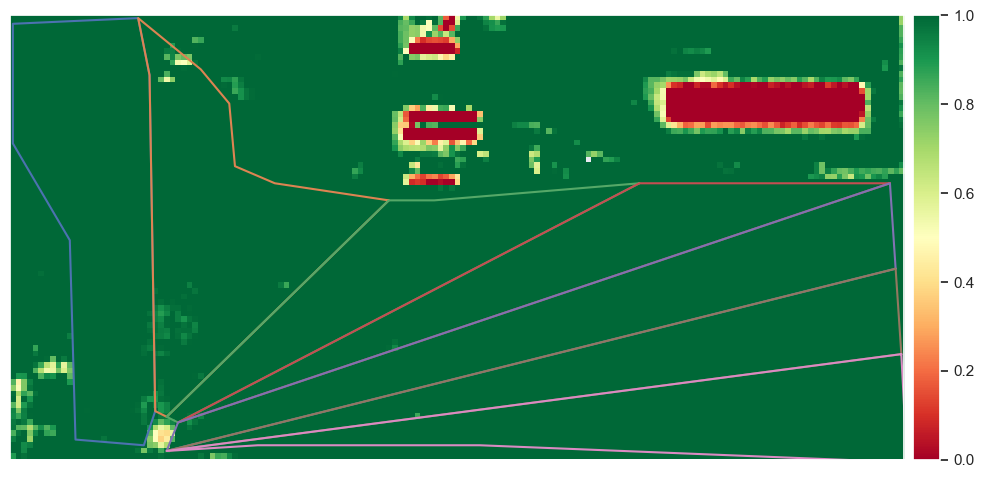

In [97]:
fig, ax = plt.subplots(figsize=(12, 12))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

cvi = (NIR / RED) - 1

ep.plot_bands(cvi, ax=ax, cmap="RdYlGn", cols=1, vmin=0, vmax=1, figsize=(10, 14))
plt.show()

In [98]:
cvi_masked_array = []
for i, mask in enumerate(masks):
    mx = ma.masked_array(cvi, mask=mask.reshape(aoi_height, aoi_width))
    cvi_masked_array.append(mx)

# Статистический анализ данных

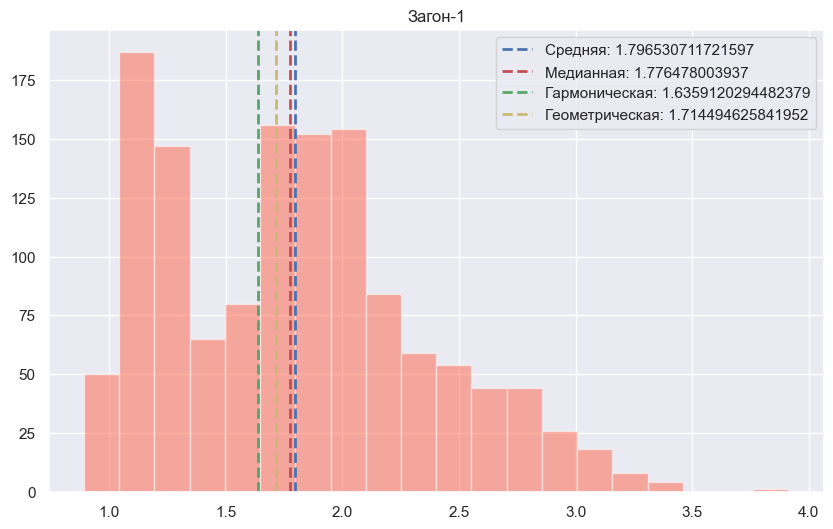

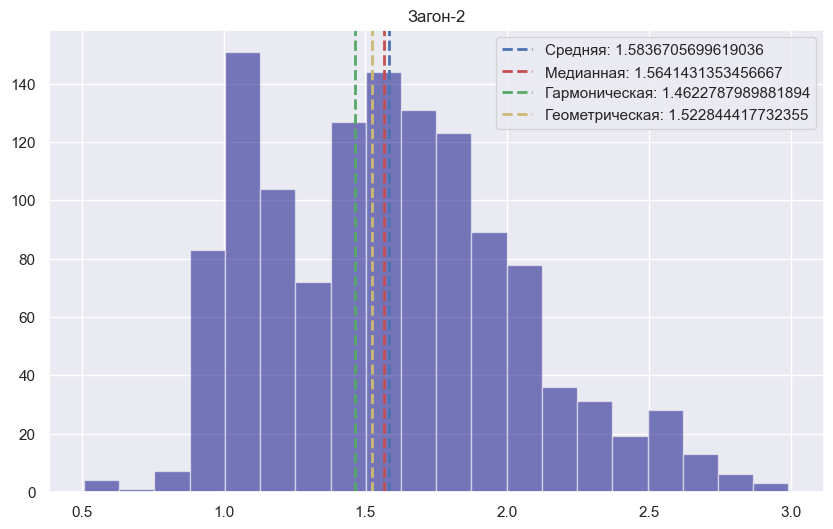

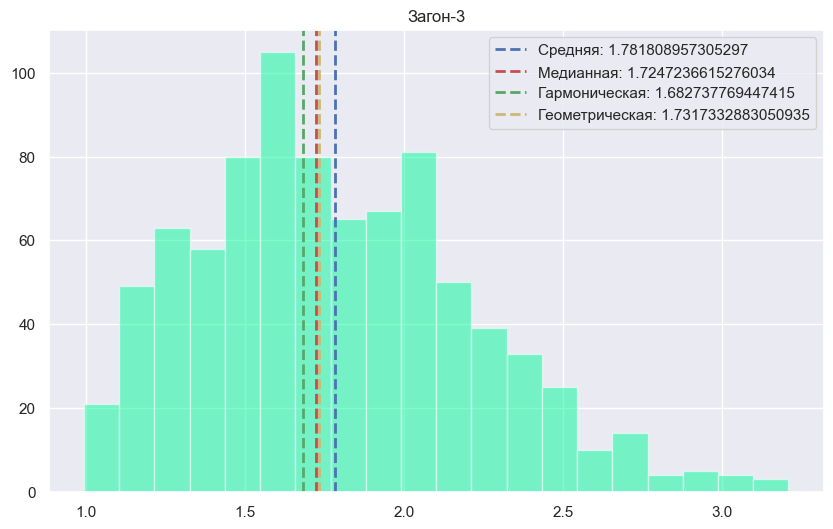

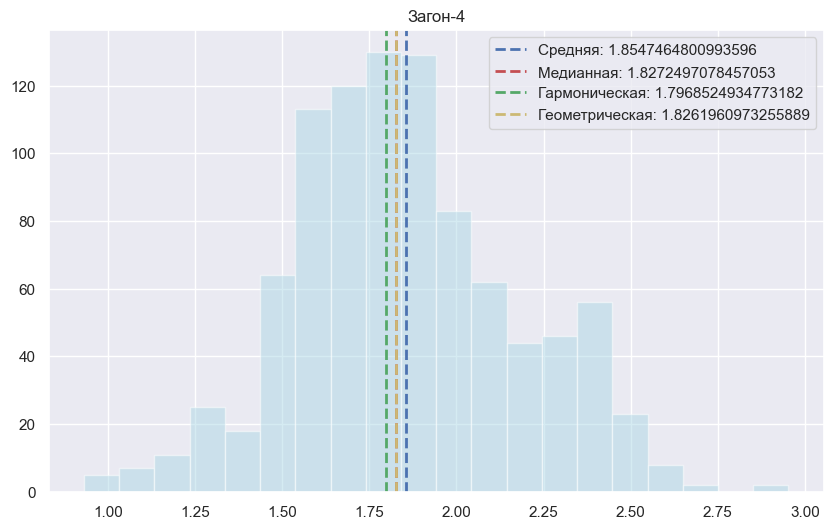

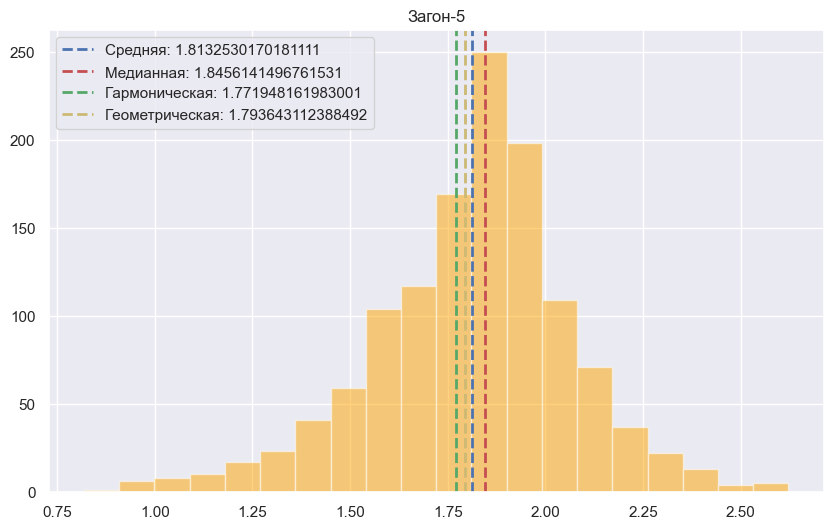

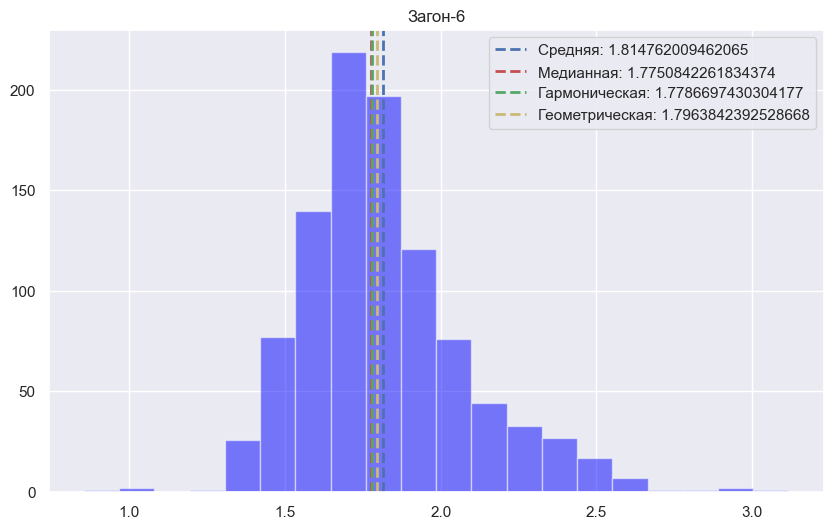

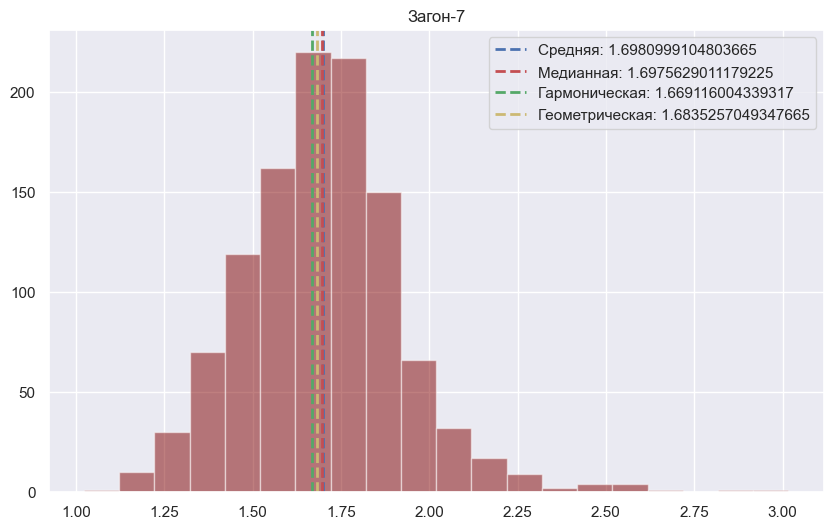

In [99]:
for i, zagon in enumerate(cvi_masked_array):
    ep.hist(zagon, colors = colors[i], title=f'Загон-{i+1}', cols=4, alpha=0.5, 
    figsize = (10, 6))
    plt.axvline(cvi_masked_array[i].mean(), color='b', linestyle='dashed', linewidth=2)
    plt.axvline(ma.median(cvi_masked_array[i]), color='r', linestyle='dashed', linewidth=2)
    has_negative_or_zero = cvi_masked_array[i] <= 0
    if not has_negative_or_zero.sum():
        plt.axvline(hmean(cvi_masked_array[i].reshape(aoi_width * aoi_height)), color='g', linestyle='dashed', linewidth=2)
        plt.axvline(gmean(cvi_masked_array[i].reshape(aoi_width * aoi_height)), color='y', linestyle='dashed', linewidth=2)
        plt.legend([f"Средняя: {cvi_masked_array[i].mean()}",f"Медианная: {ma.median(cvi_masked_array[i])}",f"Гармоническая: {hmean(cvi_masked_array[i].reshape(aoi_width * aoi_height))}",f"Геометрическая: {gmean(cvi_masked_array[i].reshape(aoi_width * aoi_height))}"])
    else:
        plt.legend([f"Средняя: {ma.mean(cvi_masked_array[i])}",f"Медианная: {ma.median(cvi_masked_array[i])}"])
plt.show()

# Photochemical Reflectance Index (PRI)

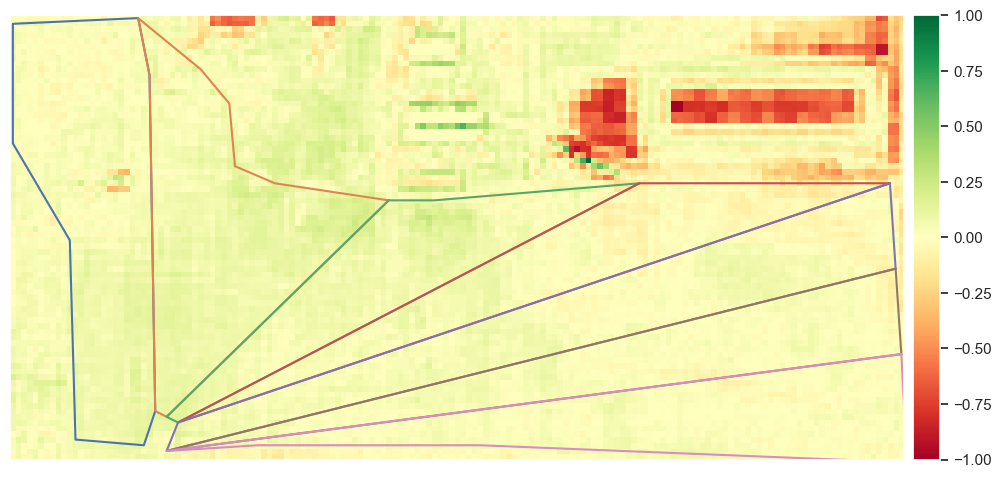

In [100]:
fig, ax = plt.subplots(figsize=(12, 12))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

pri = (RED_EDGE1 - RED) / (RED_EDGE1 + RED)

ep.plot_bands(pri, ax=ax, cmap="RdYlGn", cols=1, vmin=pri.min(), vmax=pri.max(), figsize=(10, 14))
plt.show()

In [101]:
pri_masked_array = []
for i, mask in enumerate(masks):
    mx = ma.masked_array(pri, mask=mask.reshape(aoi_height, aoi_width))
    pri_masked_array.append(mx)

# Статистический анализ данных

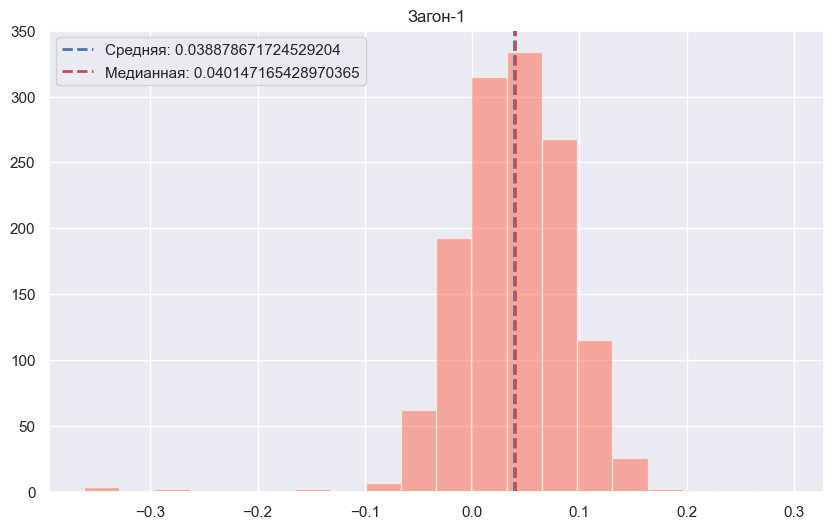

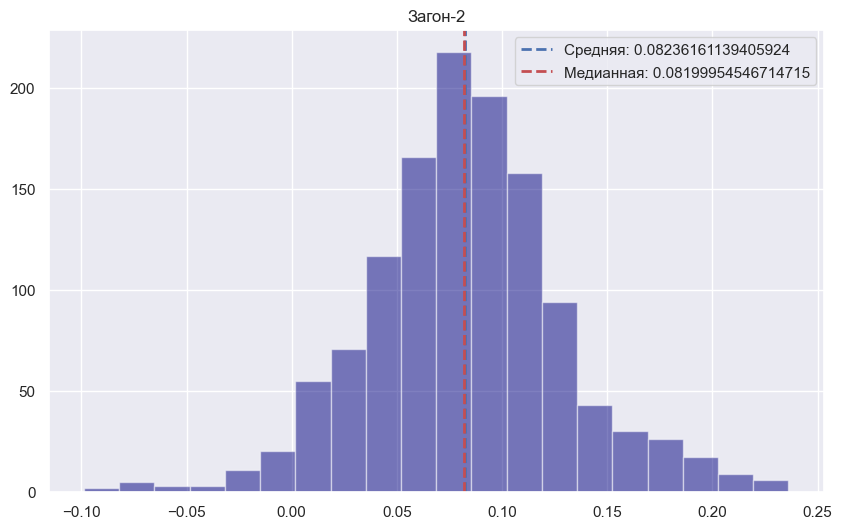

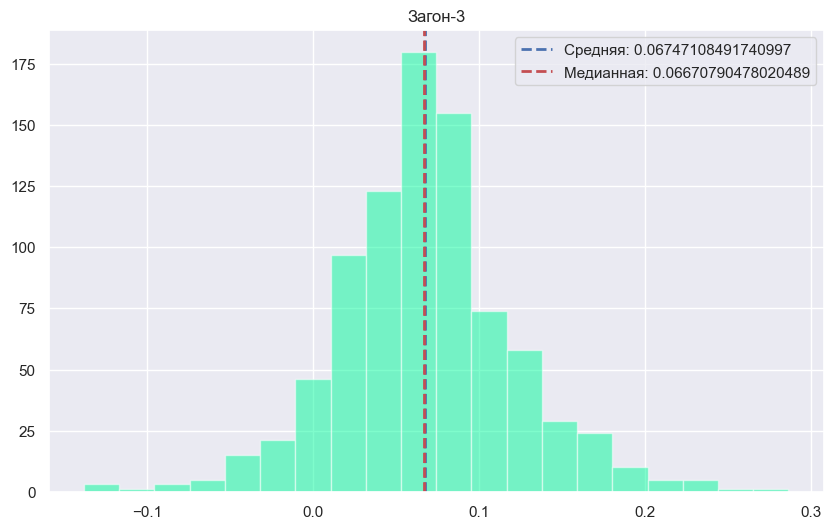

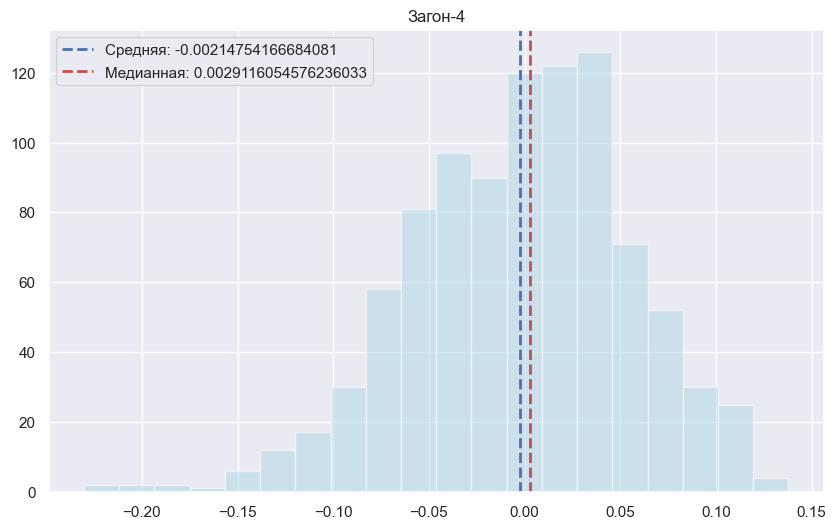

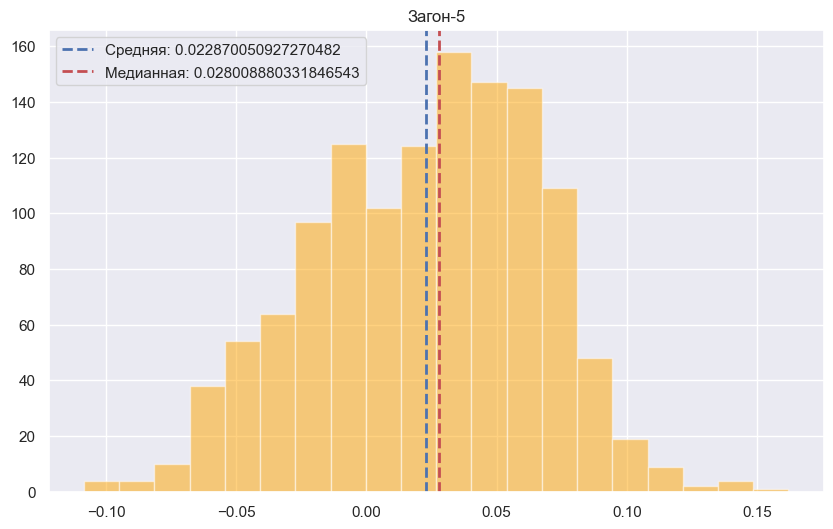

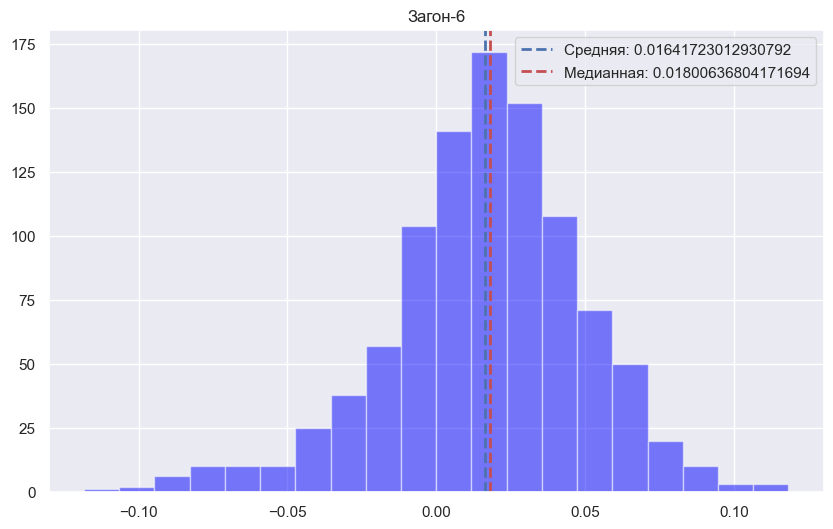

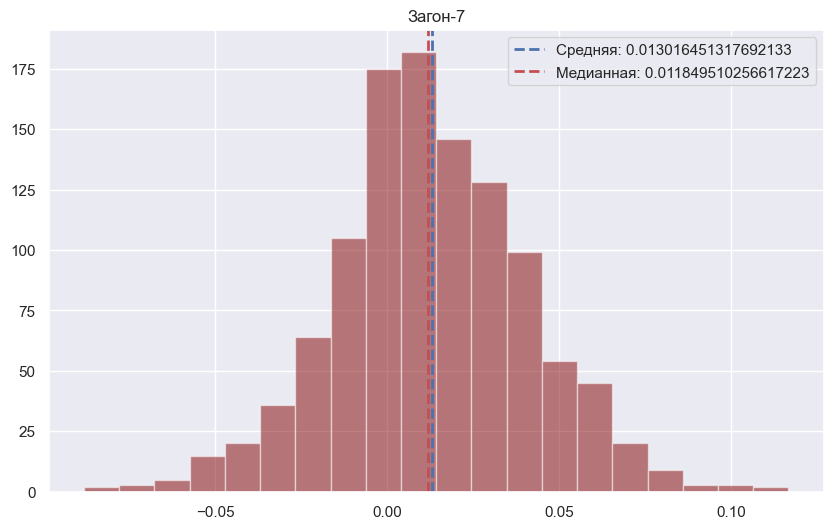

In [102]:
for i, zagon in enumerate(pri_masked_array):
    ep.hist(zagon, colors = colors[i], title=f'Загон-{i+1}', cols=4, alpha=0.5, 
    figsize = (10, 6))
    plt.axvline(pri_masked_array[i].mean(), color='b', linestyle='dashed', linewidth=2)
    plt.axvline(ma.median(pri_masked_array[i]), color='r', linestyle='dashed', linewidth=2)
    has_negative_or_zero = pri_masked_array[i] <= 0
    if not has_negative_or_zero.sum():
        plt.axvline(hmean(pri_masked_array[i].reshape(aoi_width * aoi_height)), color='g', linestyle='dashed', linewidth=2)
        plt.axvline(gmean(pri_masked_array[i].reshape(aoi_width * aoi_height)), color='y', linestyle='dashed', linewidth=2)
        plt.legend([f"Средняя: {pri_masked_array[i].mean()}",f"Медианная: {ma.median(pri_masked_array[i])}",f"Гармоническая: {hmean(pri_masked_array[i].reshape(aoi_width * aoi_height))}",f"Геометрическая: {gmean(pri_masked_array[i].reshape(aoi_width * aoi_height))}"])
    else:
        plt.legend([f"Средняя: {ma.mean(pri_masked_array[i])}",f"Медианная: {ma.median(pri_masked_array[i])}"])
plt.show()

# Normalized Difference Red Edge Vegetation Index (NDRE)

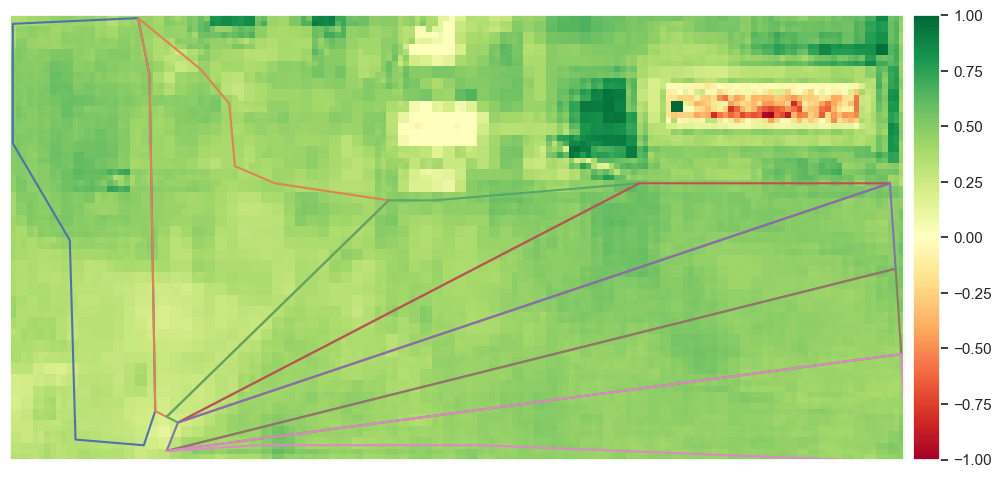

In [103]:
fig, ax = plt.subplots(figsize=(12, 12))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

ndre = (NIR - RED_EDGE1) / (NIR + RED_EDGE1)

ep.plot_bands(ndre, ax=ax, cmap="RdYlGn", cols=1, vmin=ndre.min(), vmax=ndre.max(), figsize=(10, 14))
plt.show()

In [104]:
ndre_masked_array = []
for i, mask in enumerate(masks):
    mx = ma.masked_array(ndre, mask=mask.reshape(aoi_height, aoi_width))
    ndre_masked_array.append(mx)

# Статистический анализ данных

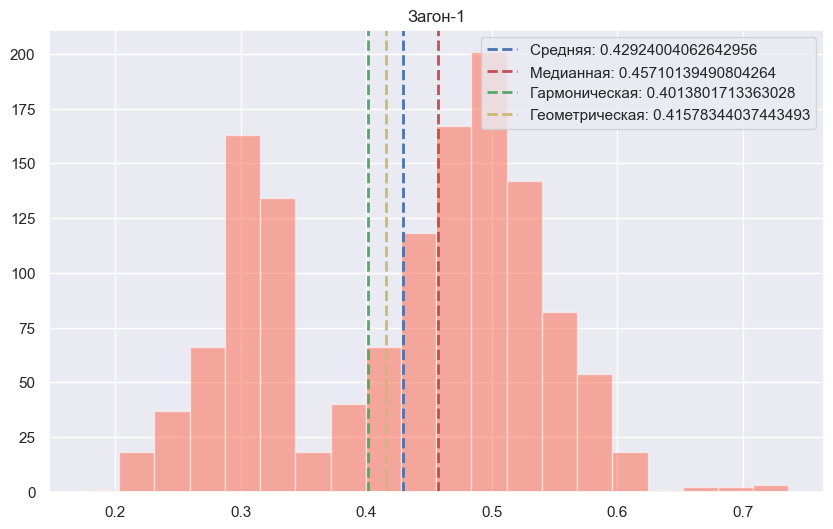

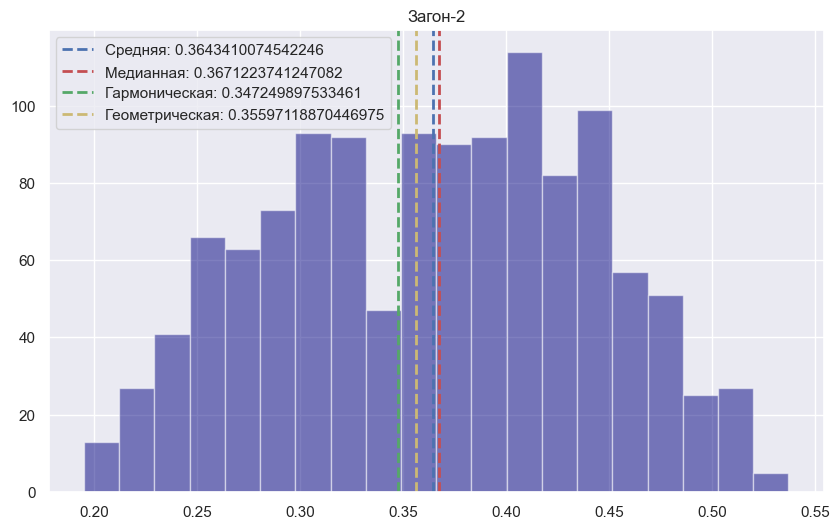

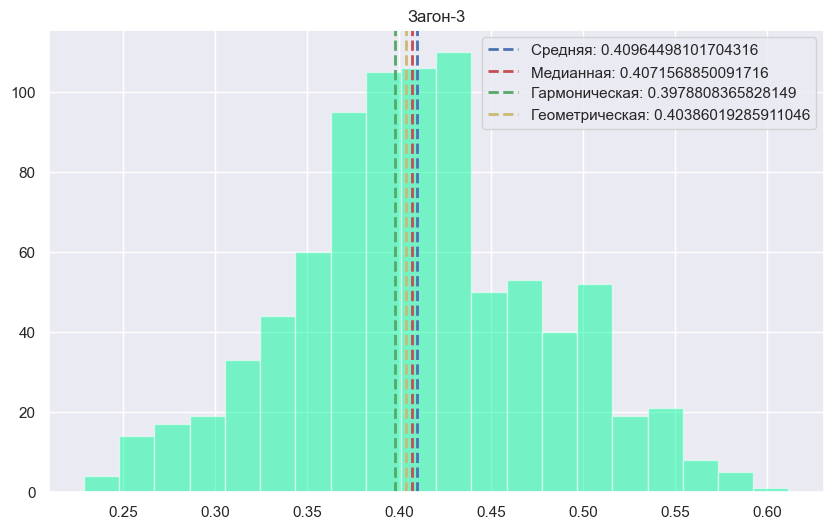

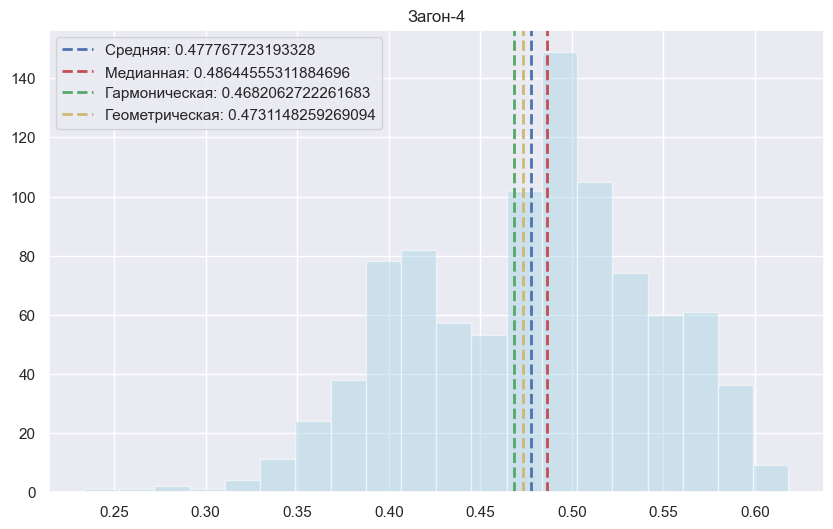

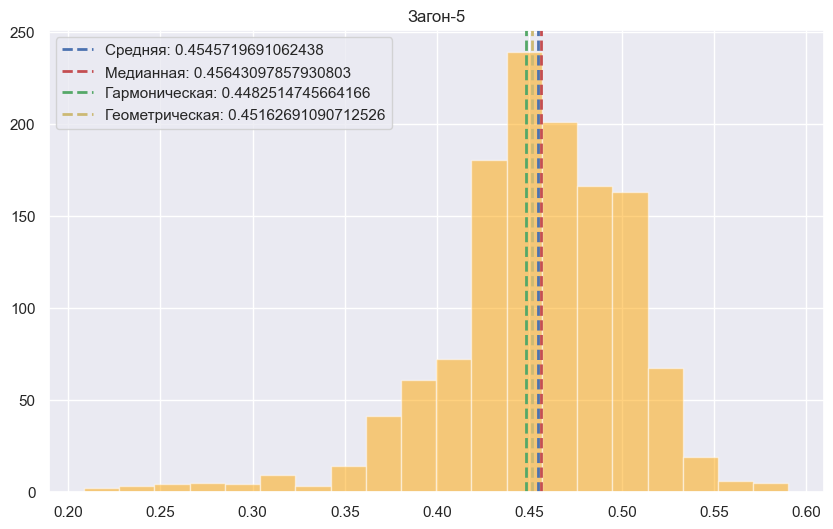

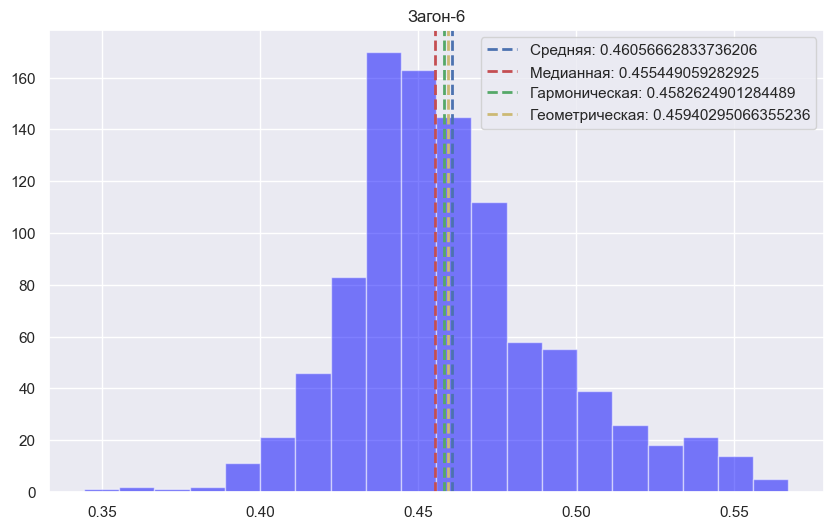

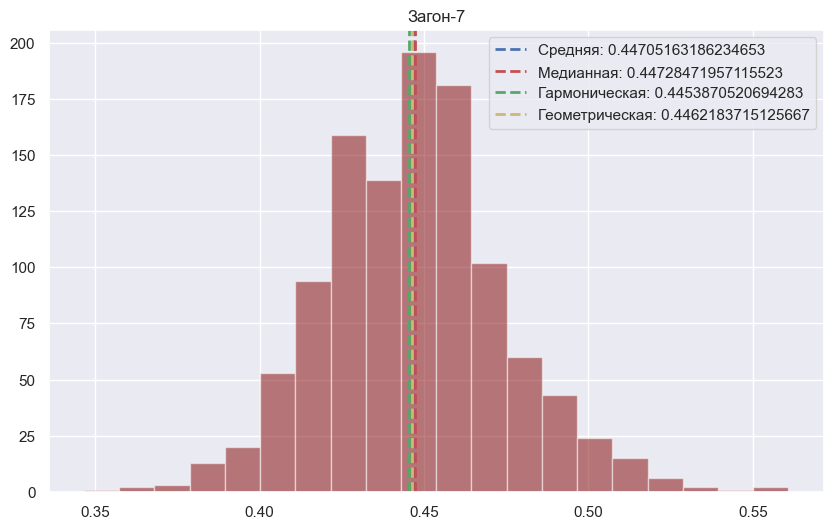

In [105]:
for i, zagon in enumerate(ndre_masked_array):
    ep.hist(zagon, colors = colors[i], title=f'Загон-{i+1}', cols=4, alpha=0.5, 
    figsize = (10, 6))
    plt.axvline(ndre_masked_array[i].mean(), color='b', linestyle='dashed', linewidth=2)
    plt.axvline(ma.median(ndre_masked_array[i]), color='r', linestyle='dashed', linewidth=2)
    has_negative_or_zero = ndre_masked_array[i] <= 0
    if not has_negative_or_zero.sum():
        plt.axvline(hmean(ndre_masked_array[i].reshape(aoi_width * aoi_height)), color='g', linestyle='dashed', linewidth=2)
        plt.axvline(gmean(ndre_masked_array[i].reshape(aoi_width * aoi_height)), color='y', linestyle='dashed', linewidth=2)
        plt.legend([f"Средняя: {ndre_masked_array[i].mean()}",f"Медианная: {ma.median(ndre_masked_array[i])}",f"Гармоническая: {hmean(ndre_masked_array[i].reshape(aoi_width * aoi_height))}",f"Геометрическая: {gmean(ndre_masked_array[i].reshape(aoi_width * aoi_height))}"])
    else:
        plt.legend([f"Средняя: {ma.mean(ndre_masked_array[i])}",f"Медианная: {ma.median(ndre_masked_array[i])}"])
plt.show()

# Optimized Soil Adjusted Vegetation Index (OSAVI)

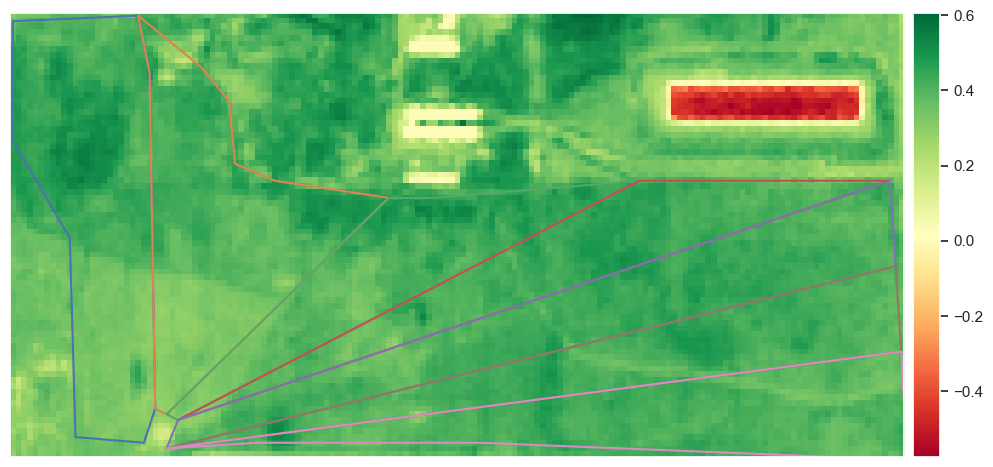

In [106]:
fig, ax = plt.subplots(figsize=(12, 12))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

osavi = (NIR - RED) / (NIR + RED + 0.16)

ep.plot_bands(osavi, ax=ax, cmap="RdYlGn", cols=1, vmin=osavi.min(), vmax=osavi.max(), figsize=(10, 14))
plt.show()

In [107]:
osavi_masked_array = []
for i, mask in enumerate(masks):
    mx = ma.masked_array(osavi, mask=mask.reshape(aoi_height, aoi_width))
    osavi_masked_array.append(mx)

# Статистический анализ данных

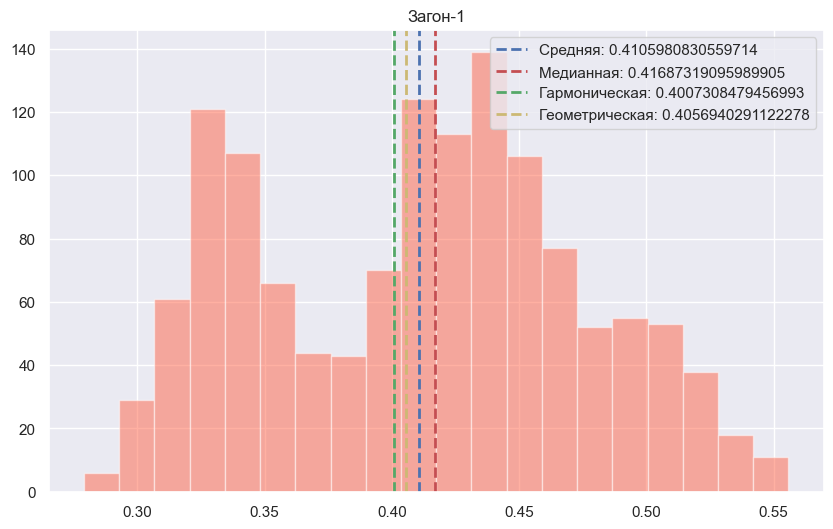

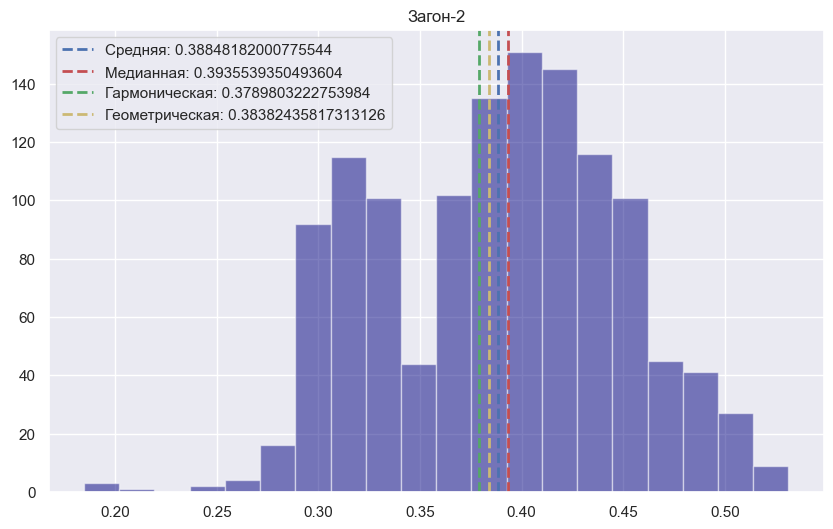

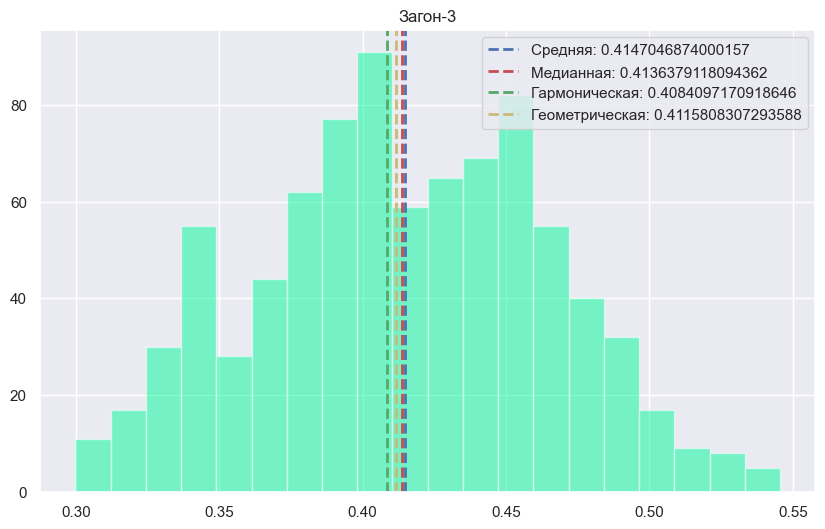

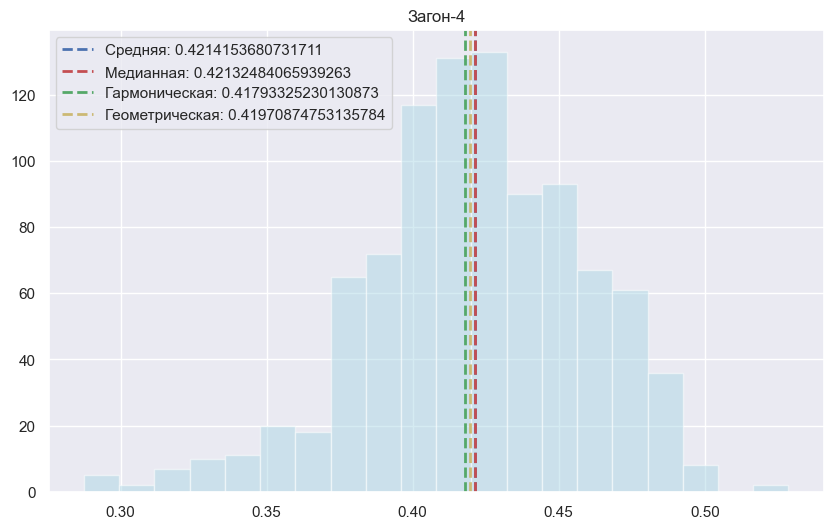

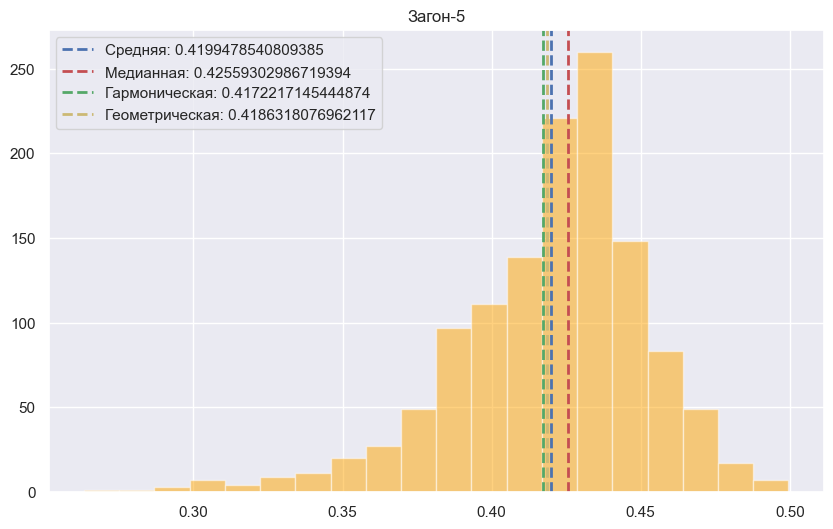

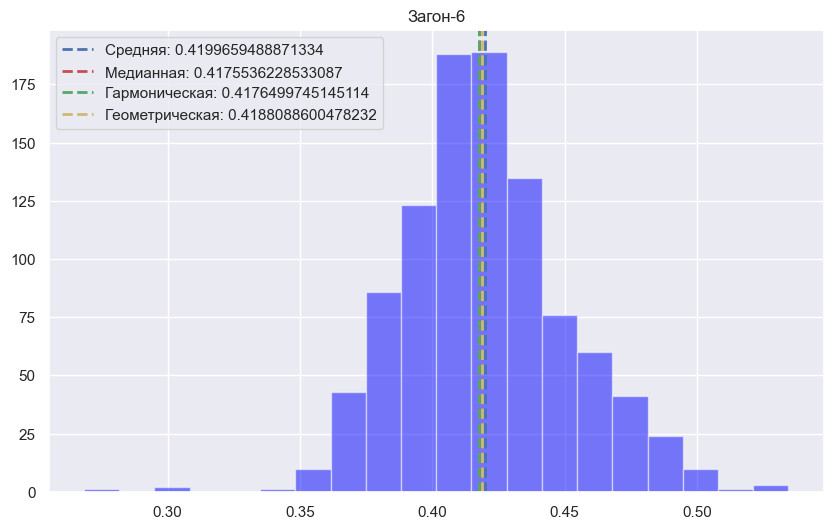

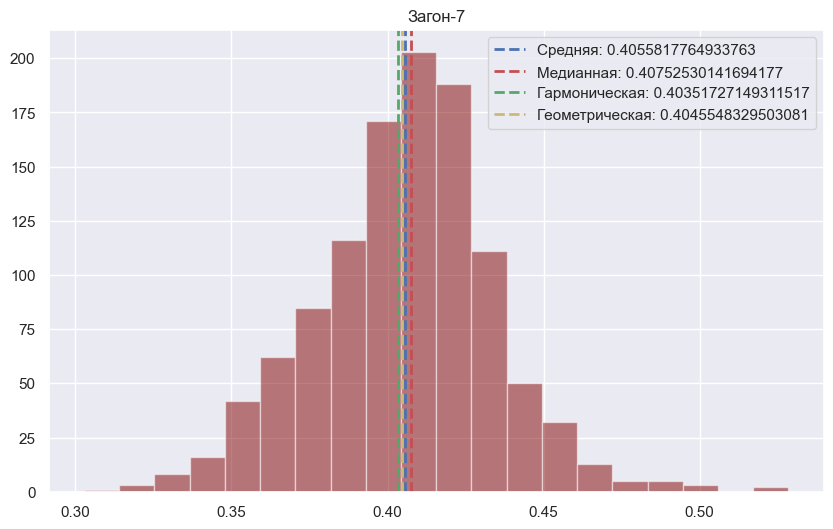

In [108]:
for i, zagon in enumerate(osavi_masked_array):
    ep.hist(zagon, colors = colors[i], title=f'Загон-{i+1}', cols=4, alpha=0.5, 
    figsize = (10, 6))
    plt.axvline(osavi_masked_array[i].mean(), color='b', linestyle='dashed', linewidth=2)
    plt.axvline(ma.median(osavi_masked_array[i]), color='r', linestyle='dashed', linewidth=2)
    has_negative_or_zero = osavi_masked_array[i] <= 0
    if not has_negative_or_zero.sum():
        plt.axvline(hmean(osavi_masked_array[i].reshape(aoi_width * aoi_height)), color='g', linestyle='dashed', linewidth=2)
        plt.axvline(gmean(osavi_masked_array[i].reshape(aoi_width * aoi_height)), color='y', linestyle='dashed', linewidth=2)
        plt.legend([f"Средняя: {osavi_masked_array[i].mean()}",f"Медианная: {ma.median(osavi_masked_array[i])}",f"Гармоническая: {hmean(osavi_masked_array[i].reshape(aoi_width * aoi_height))}",f"Геометрическая: {gmean(osavi_masked_array[i].reshape(aoi_width * aoi_height))}"])
    else:
        plt.legend([f"Средняя: {ma.mean(osavi_masked_array[i])}",f"Медианная: {ma.median(osavi_masked_array[i])}"])
plt.show()

# Atmospherically Resistant Vegetation Index (ARVI)

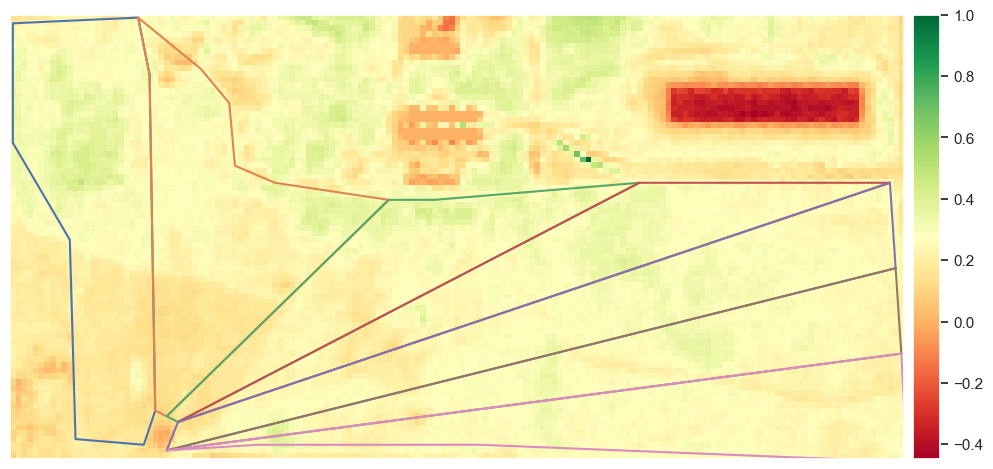

In [109]:
fig, ax = plt.subplots(figsize=(12, 12))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

arvi = (NIR - (2 * RED) + BLUE) / (NIR + (2 * RED) + BLUE)

ep.plot_bands(arvi, ax=ax, cmap="RdYlGn", cols=1, vmin=arvi.min(), vmax=arvi.max(), figsize=(10, 14))
plt.show()

In [110]:
arvi_masked_array = []
for i, mask in enumerate(masks):
    mx = ma.masked_array(arvi, mask=mask.reshape(aoi_height, aoi_width))
    arvi_masked_array.append(mx)

# Статистический анализ данных

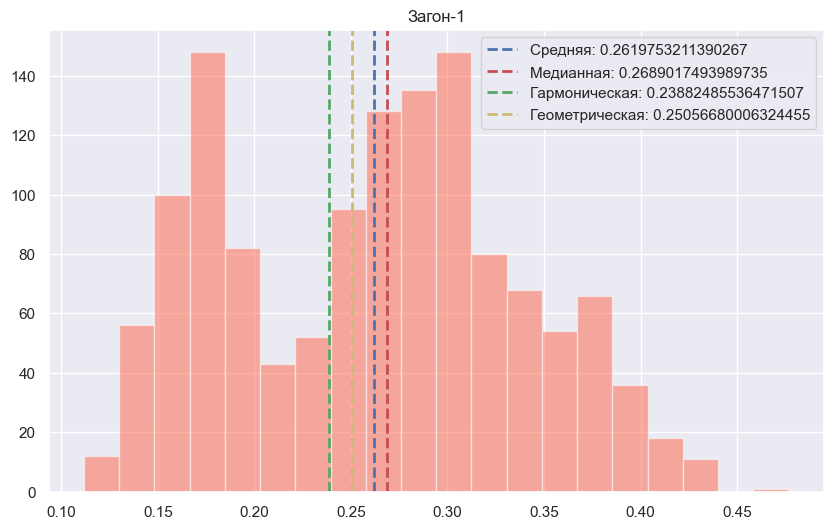

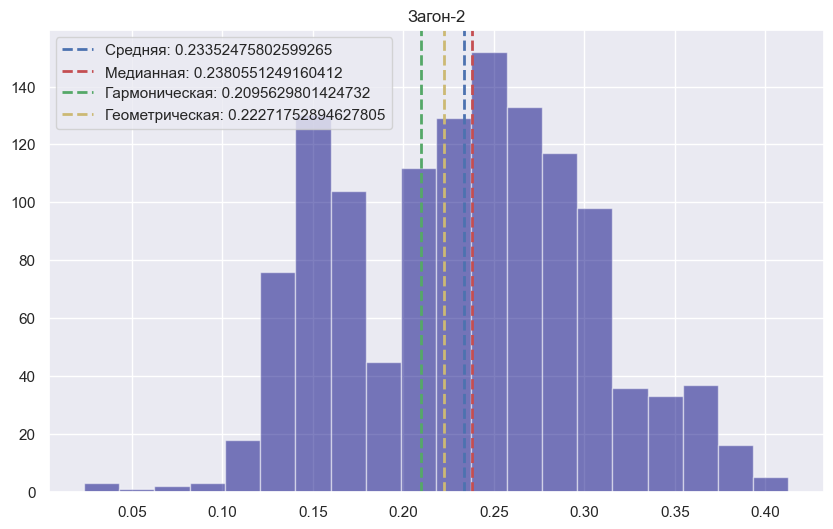

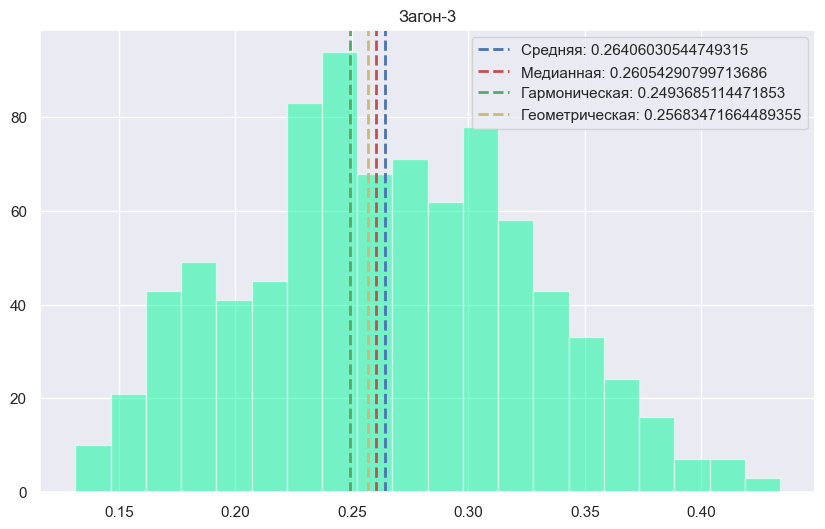

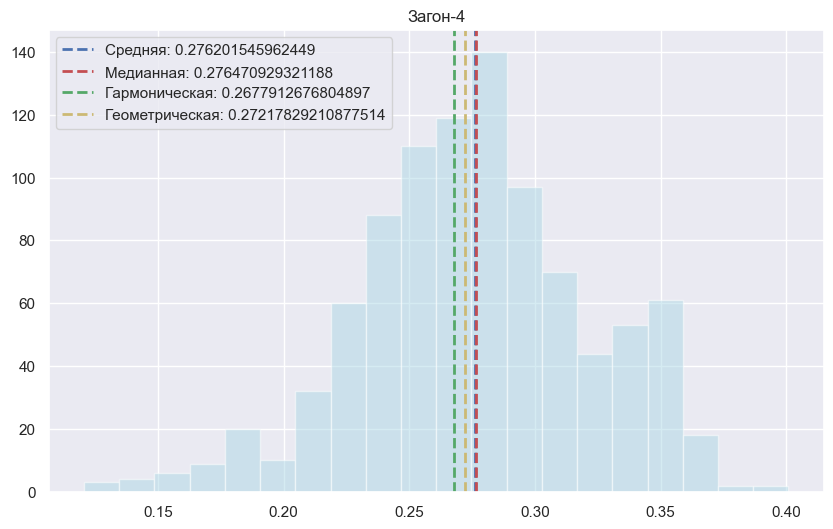

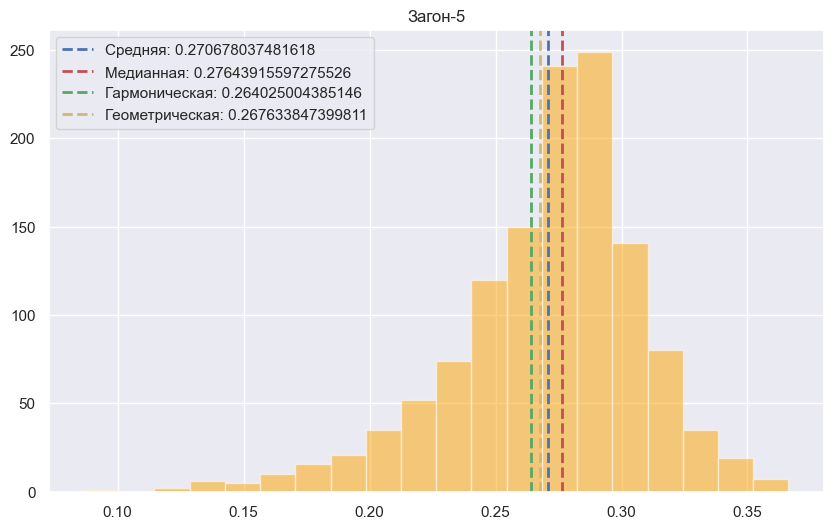

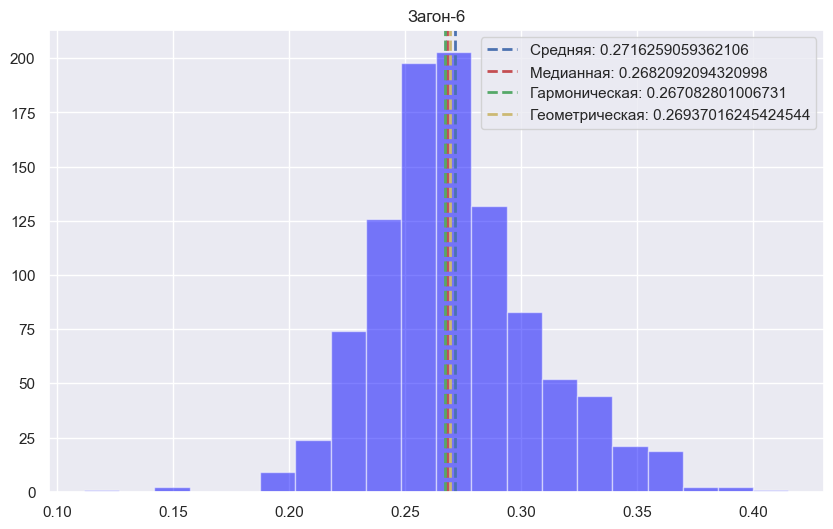

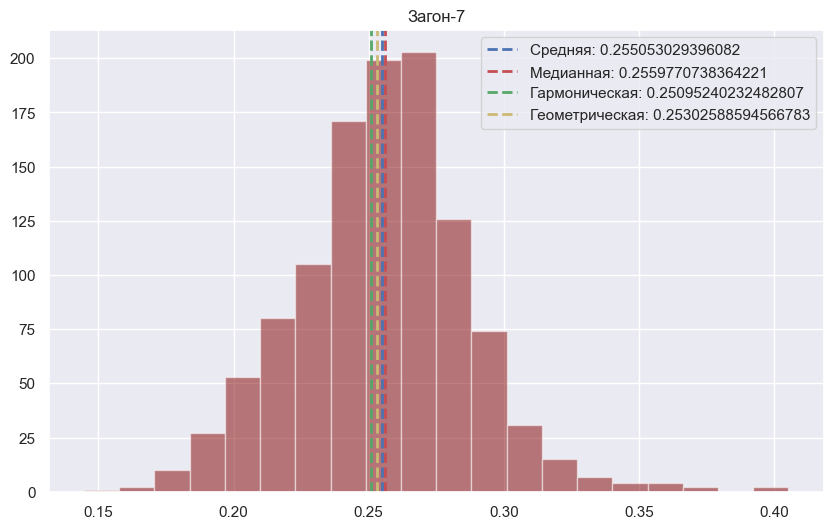

In [111]:
for i, zagon in enumerate(arvi_masked_array):
    ep.hist(zagon, colors = colors[i], title=f'Загон-{i+1}', cols=4, alpha=0.5, 
    figsize = (10, 6))
    plt.axvline(arvi_masked_array[i].mean(), color='b', linestyle='dashed', linewidth=2)
    plt.axvline(ma.median(arvi_masked_array[i]), color='r', linestyle='dashed', linewidth=2)
    has_negative_or_zero = arvi_masked_array[i] <= 0
    if not has_negative_or_zero.sum():
        plt.axvline(hmean(arvi_masked_array[i].reshape(aoi_width * aoi_height)), color='g', linestyle='dashed', linewidth=2)
        plt.axvline(gmean(arvi_masked_array[i].reshape(aoi_width * aoi_height)), color='y', linestyle='dashed', linewidth=2)
        plt.legend([f"Средняя: {arvi_masked_array[i].mean()}",f"Медианная: {ma.median(arvi_masked_array[i])}",f"Гармоническая: {hmean(arvi_masked_array[i].reshape(aoi_width * aoi_height))}",f"Геометрическая: {gmean(arvi_masked_array[i].reshape(aoi_width * aoi_height))}"])
    else:
        plt.legend([f"Средняя: {ma.mean(arvi_masked_array[i])}",f"Медианная: {ma.median(arvi_masked_array[i])}"])
plt.show()

# Visible Atmospherically Resistant Index (VARI)

C:\Users\Пользователь\AppData\Local\Temp\ipykernel_15508\1507804177.py:6: RuntimeWarning: invalid value encountered in true_divide
  vari = (GREEN - RED) / (GREEN + RED - BLUE)


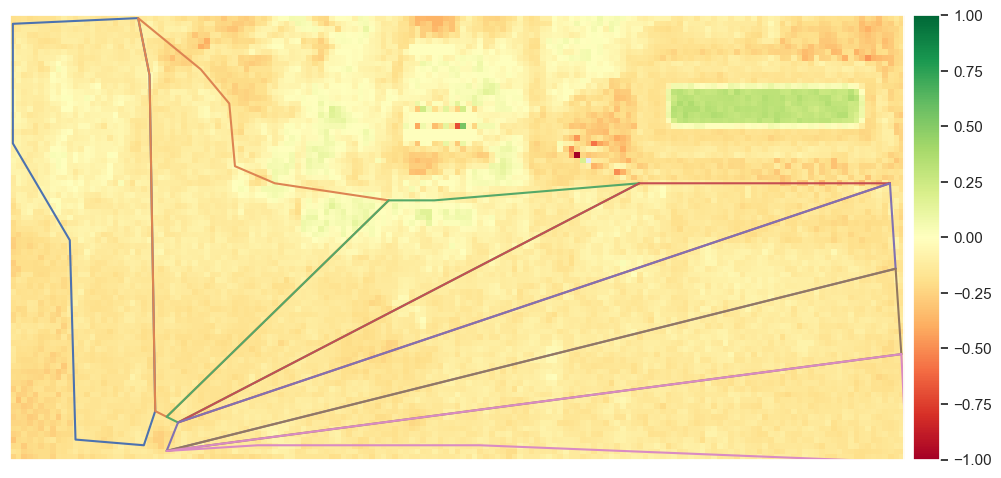

In [112]:
fig, ax = plt.subplots(figsize=(12, 12))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

vari = (GREEN - RED) / (GREEN + RED - BLUE)

ep.plot_bands(vari, ax=ax, cmap="RdYlGn", cols=1, vmin=-1, vmax=1, figsize=(10, 14))
plt.show()

In [113]:
vari_masked_array = []
for i, mask in enumerate(masks):
    mx = ma.masked_array(vari, mask=mask.reshape(aoi_height, aoi_width))
    vari_masked_array.append(mx)

# Статистический анализ данных

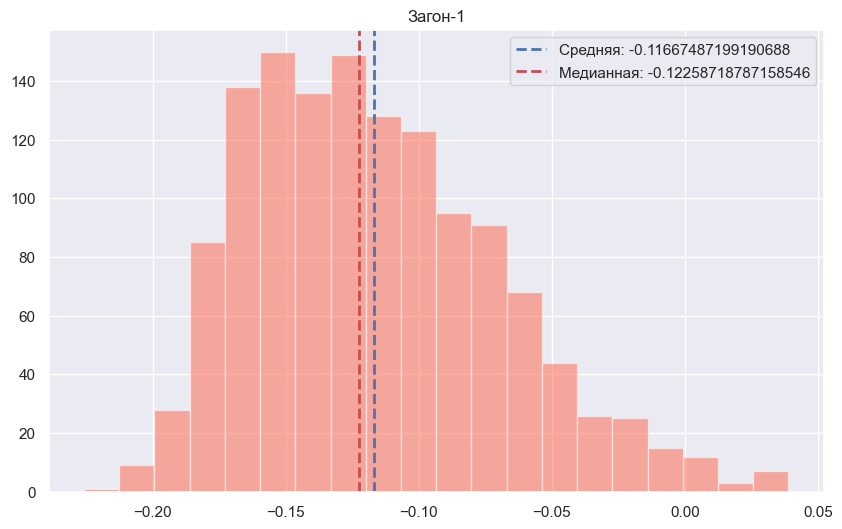

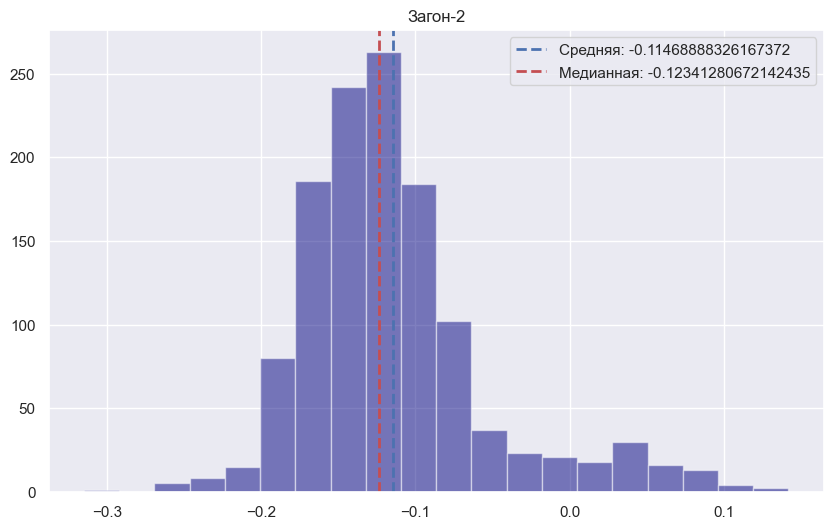

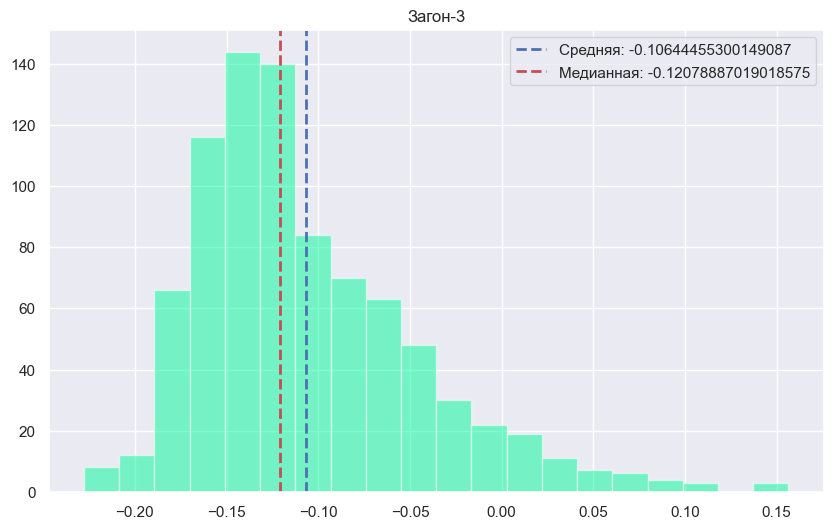

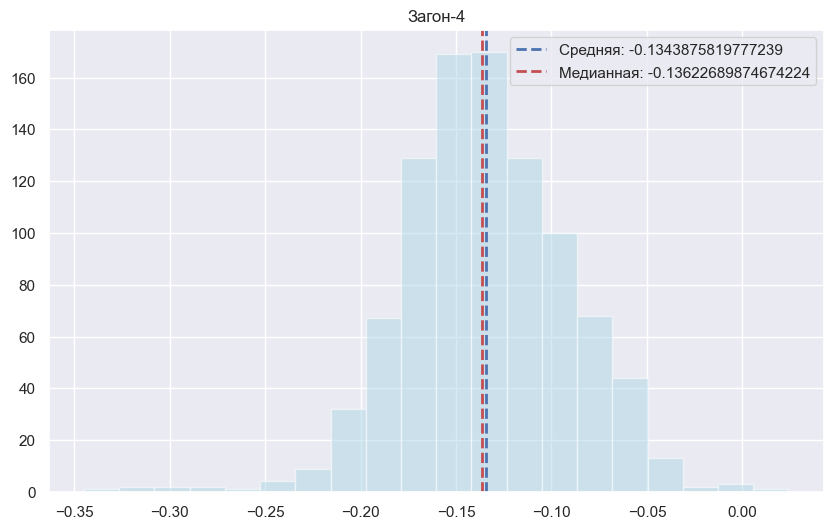

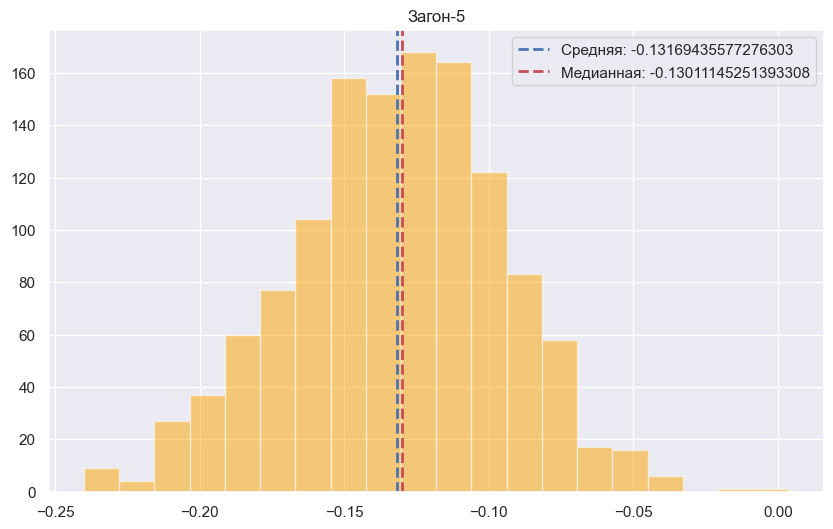

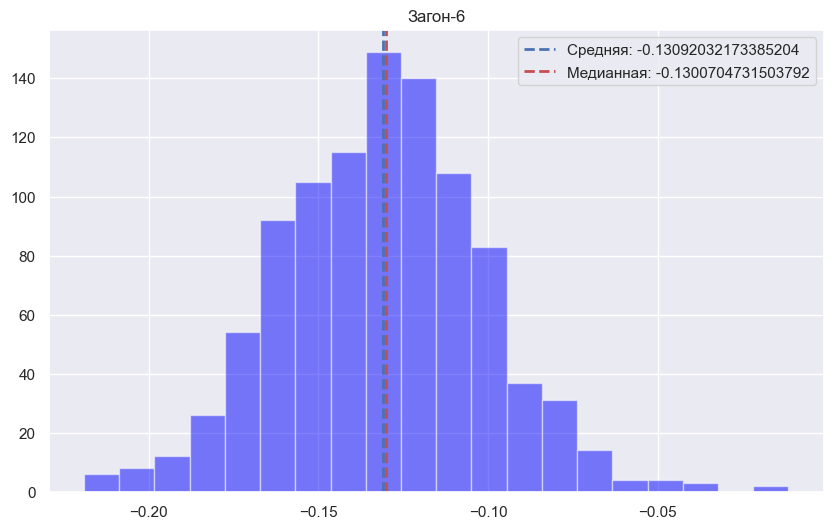

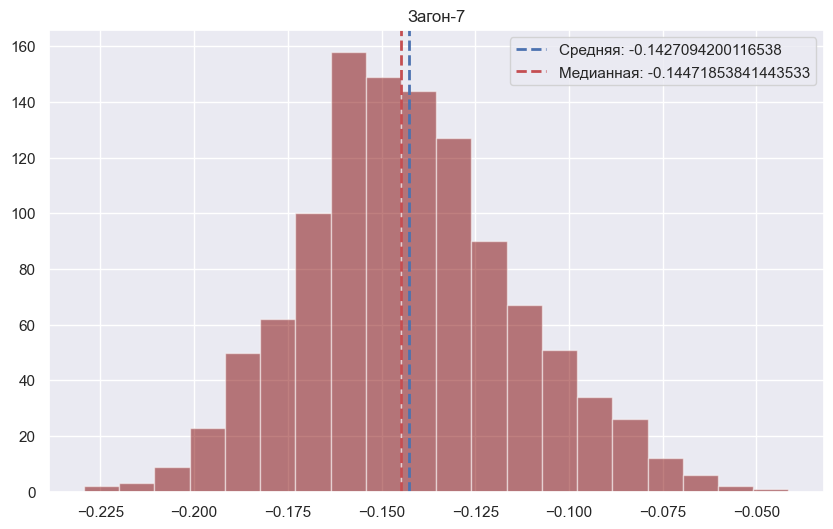

In [114]:
for i, zagon in enumerate(vari_masked_array):
    ep.hist(zagon, colors = colors[i], title=f'Загон-{i+1}', cols=4, alpha=0.5, 
    figsize = (10, 6))
    plt.axvline(vari_masked_array[i].mean(), color='b', linestyle='dashed', linewidth=2)
    plt.axvline(ma.median(vari_masked_array[i]), color='r', linestyle='dashed', linewidth=2)
    has_negative_or_zero = vari_masked_array[i] <= 0
    if not has_negative_or_zero.sum():
        plt.axvline(hmean(vari_masked_array[i].reshape(aoi_width * aoi_height)), color='g', linestyle='dashed', linewidth=2)
        plt.axvline(gmean(vari_masked_array[i].reshape(aoi_width * aoi_height)), color='y', linestyle='dashed', linewidth=2)
        plt.legend([f"Средняя: {vari_masked_array[i].mean()}",f"Медианная: {ma.median(vari_masked_array[i])}",f"Гармоническая: {hmean(vari_masked_array[i].reshape(aoi_width * aoi_height))}",f"Геометрическая: {gmean(vari_masked_array[i].reshape(aoi_width * aoi_height))}"])
    else:
        plt.legend([f"Средняя: {ma.mean(vari_masked_array[i])}",f"Медианная: {ma.median(vari_masked_array[i])}"])
plt.show()

Макс: 0.7443 || Мин: 0.1867 || Сред: 0.6213 || Сумм: 4795.0196


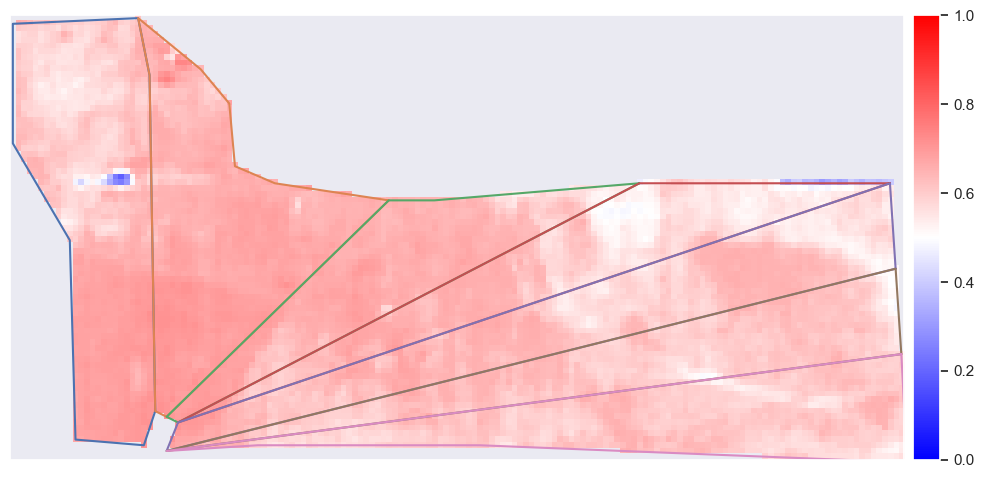

Сумма для Загона №1: 832.8116 || От всего: 17.37%
Сумма для Загона №2: 833.8219 || От всего: 17.39%
Сумма для Загона №3: 554.6838 || От всего: 11.57%
Сумма для Загона №4: 554.8712 || От всего: 11.57%
Сумма для Загона №5: 772.4177 || От всего: 16.11%
Сумма для Загона №6: 601.6582 || От всего: 12.55%
Сумма для Загона №7: 670.7366 || От всего: 13.99%


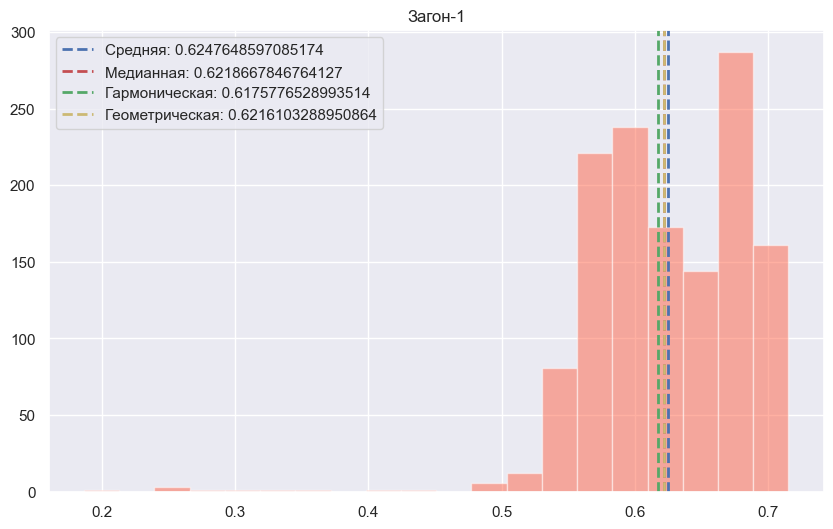

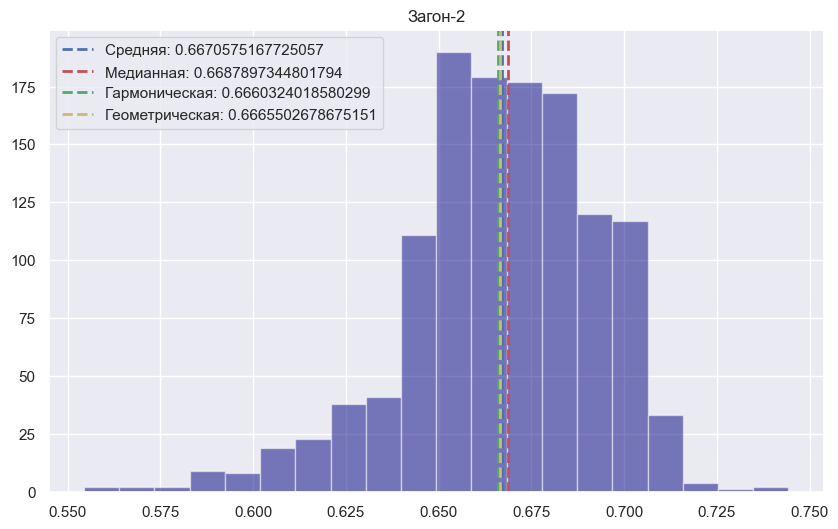

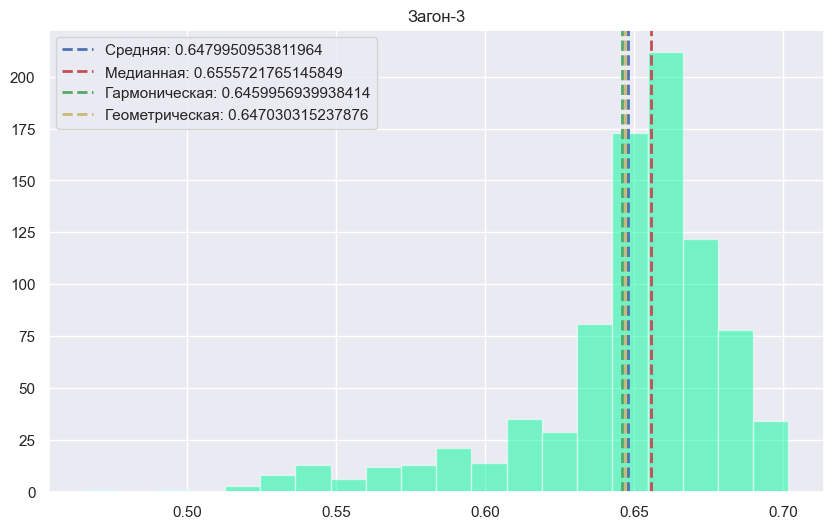

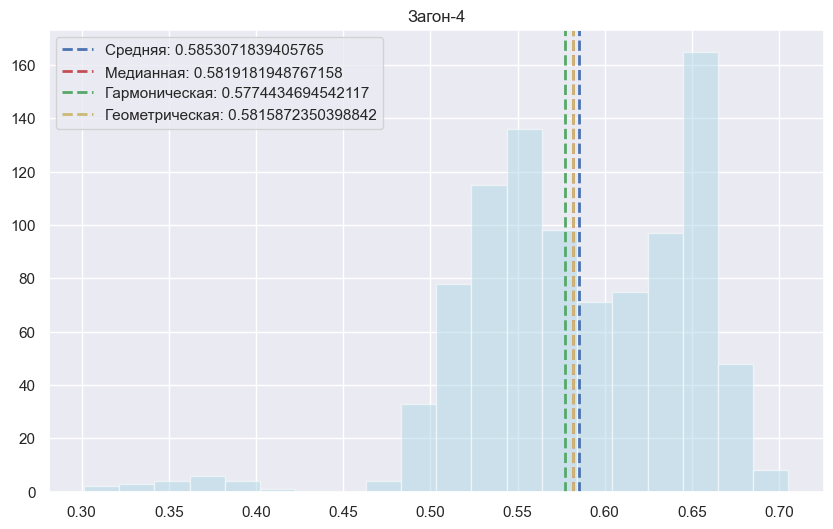

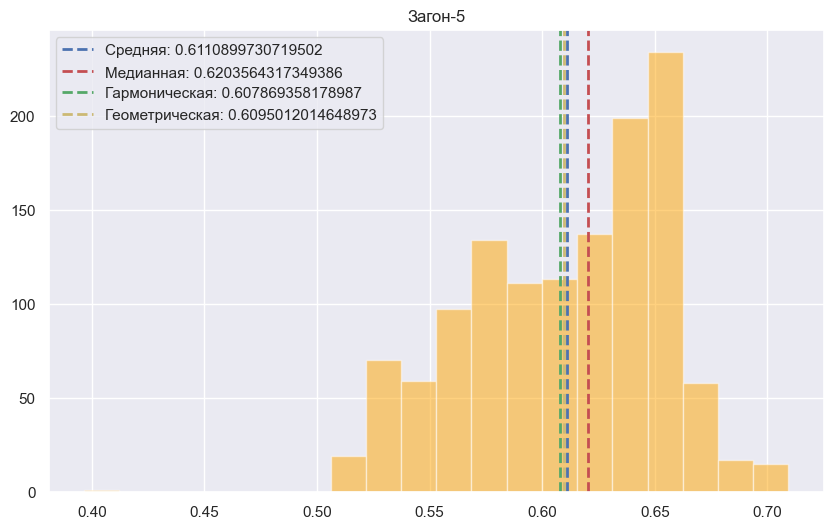

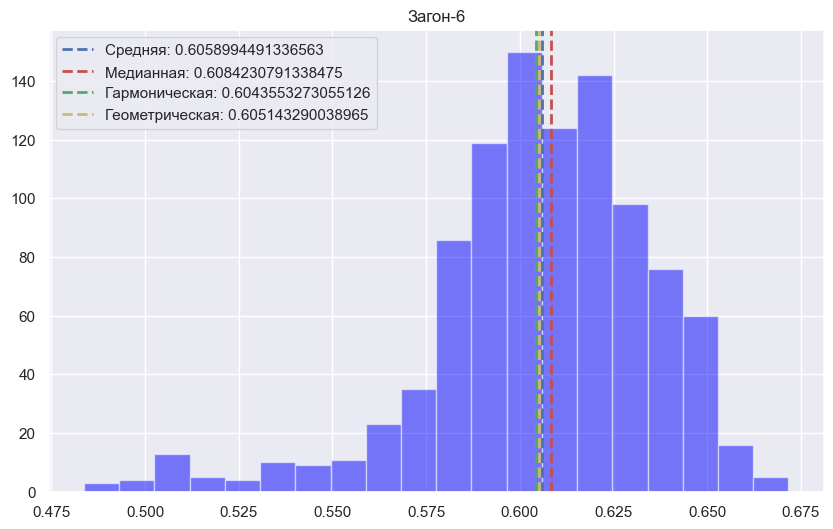

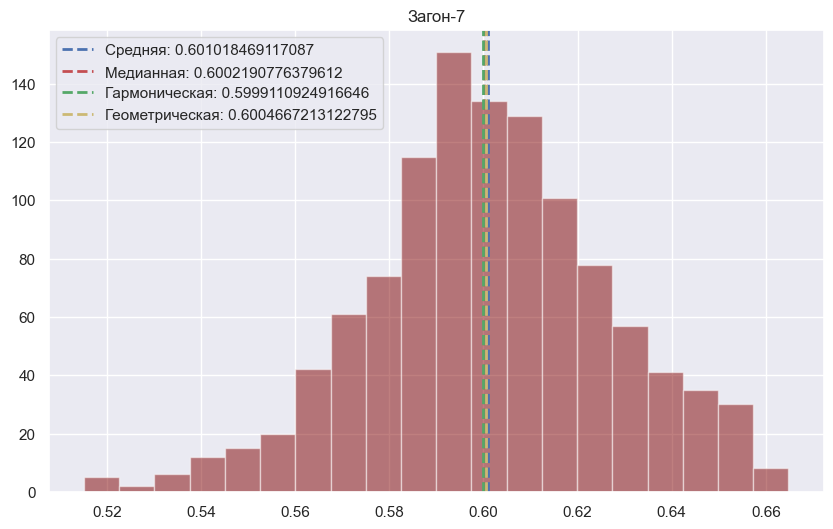

In [155]:
# test_index = (BLUE+RED)/2
test_index = (GREEN+NIR)/2
# test_index = BLUE - GREEN + RED
# test_index = GREEN

test_thresh = test_index.min()
test_filter = test_index >= test_thresh
test_mask = ~test_filter
test_meet = ma.masked_array(test_index, mask=test_mask)
test_meet_pasture = ma.masked_array(test_meet, mask=combined_mask.reshape(aoi_height, aoi_width))

lower_bound = 0
upper_bound = 1
# lower_bound = test_meet_pasture.min()
# upper_bound = test_meet_pasture.max()


fig, ax = plt.subplots(figsize=(12, 12))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

precision = 4
print(f"Макс: {round(test_meet_pasture.max(),precision)} || Мин: {round(test_meet_pasture.min(),precision)} || Сред: {round(test_meet_pasture.mean(),precision)} || Сумм: {round(test_meet_pasture.sum(),precision)}")
ep.plot_bands(test_meet_pasture, ax=ax, cmap="bwr", cols=1, vmin=lower_bound, vmax=upper_bound, figsize=(10, 14))
plt.show()

test_index_masked_array = []
for i, mask in enumerate(masks):
    mx = ma.masked_array(test_index, mask=mask.reshape(aoi_height, aoi_width))
    test_index_masked_array.append(mx)
    
for i, zagon in enumerate(test_index_masked_array):
    ep.hist(zagon, colors = colors[i], title=f'Загон-{i+1}', cols=4, alpha=0.5,
    figsize = (10, 6))
    print(f"Сумма для Загона №{i+1}: {round(zagon.sum(),precision)} || От всего: {round(zagon.sum()/test_meet_pasture.sum(),precision)*100}%")
    plt.axvline(test_index_masked_array[i].mean(), color='b', linestyle='dashed', linewidth=2)
    plt.axvline(ma.median(test_index_masked_array[i]), color='r', linestyle='dashed', linewidth=2)
    has_negative_or_zero = test_index_masked_array[i] <= 0
    if not has_negative_or_zero.sum():
        plt.axvline(hmean(test_index_masked_array[i].reshape(aoi_width * aoi_height)), color='g', linestyle='dashed', linewidth=2)
        plt.axvline(gmean(test_index_masked_array[i].reshape(aoi_width * aoi_height)), color='y', linestyle='dashed', linewidth=2)
        plt.legend([f"Средняя: {test_index_masked_array[i].mean()}",f"Медианная: {ma.median(test_index_masked_array[i])}",f"Гармоническая: {hmean(test_index_masked_array[i].reshape(aoi_width * aoi_height))}",f"Геометрическая: {gmean(test_index_masked_array[i].reshape(aoi_width * aoi_height))}"])
    else:
        plt.legend([f"Средняя: {ma.mean(test_index_masked_array[i])}",f"Медианная: {ma.median(test_index_masked_array[i])}"])
plt.show()

# Дополнительные комбинации каналов

# Color Infrared (B8, B4, B3)

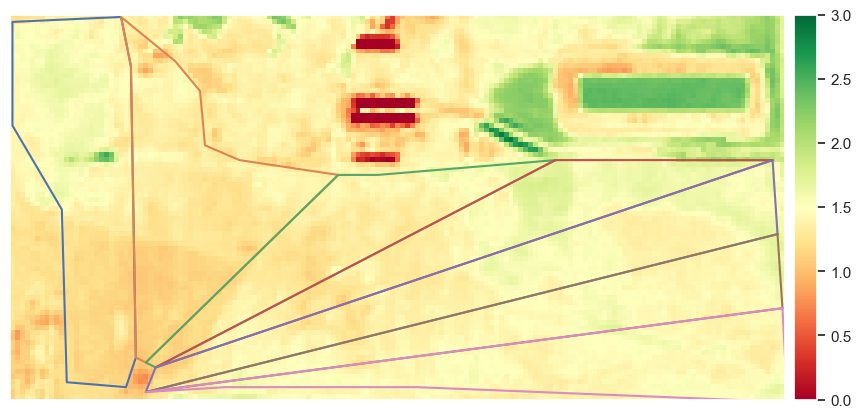

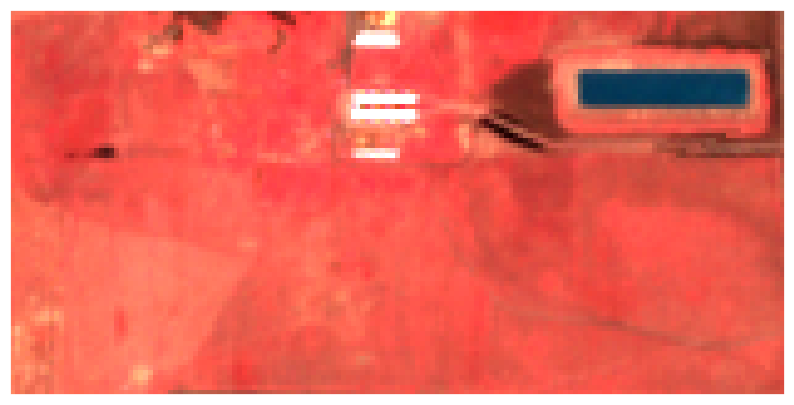

In [115]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

chanels = [NIR, RED, GREEN]
color_inf = np.absolute(chanels[0] + chanels[1] + chanels[2] - 3)

ep.plot_bands(color_inf, ax=ax, cmap="RdYlGn", cols=1, vmin=0, vmax=3, figsize=(10, 14))

ep.plot_rgb(np.stack(chanels),
            figsize=(12, 5),
            )
plt.show()

# Short-Wave Infrared (B12, B8A, B4)

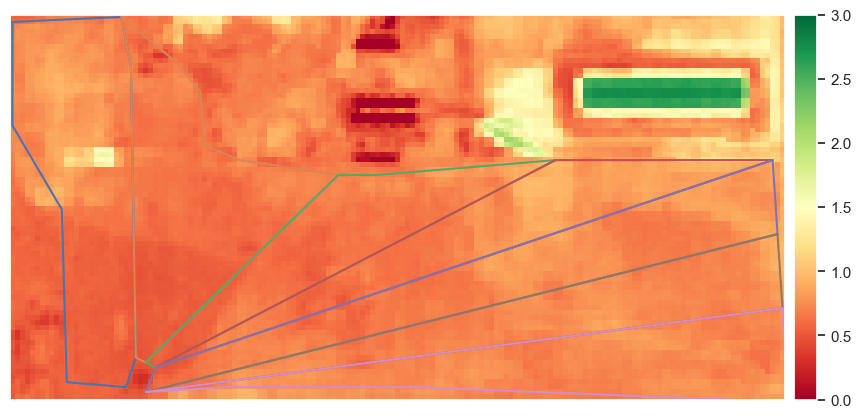

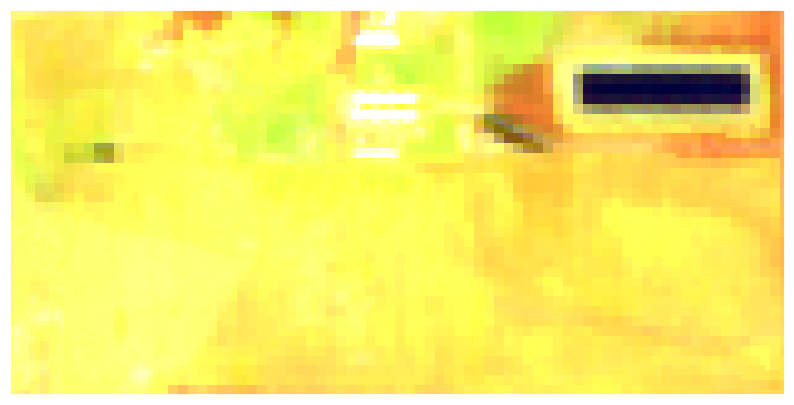

In [116]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

chanels = [SWIR3, N_NIR, RED]
sw_inf = np.absolute(chanels[0] + chanels[1] + chanels[2] - 3)

ep.plot_bands(sw_inf, ax=ax, cmap="RdYlGn", cols=1, vmin=0, vmax=3, figsize=(10, 14))

ep.plot_rgb(np.stack(chanels),
            figsize=(12, 5),
            )
plt.show()

# Agriculture (B11 – B8A – B02)

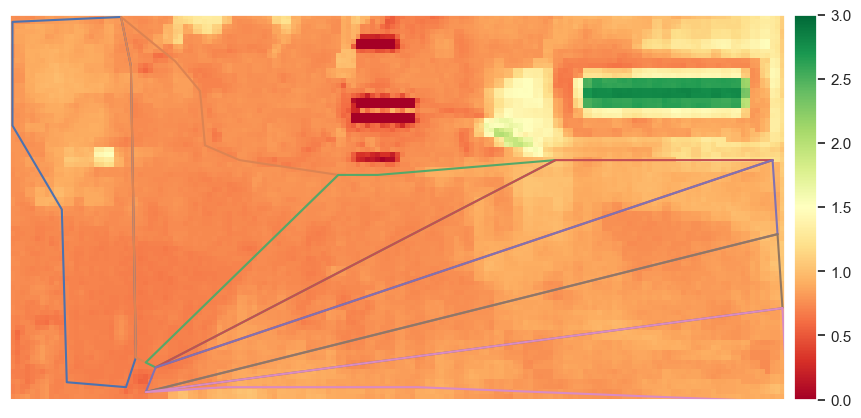

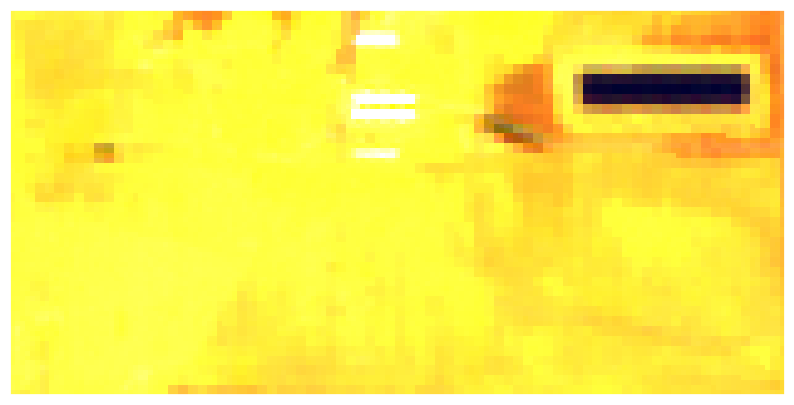

In [117]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

chanels = [SWIR2, N_NIR, BLUE]
agri = np.absolute(chanels[0] + chanels[1] + chanels[2] - 3)

ep.plot_bands(agri, ax=ax, cmap="RdYlGn", cols=1, vmin=0, vmax=3, figsize=(10, 14))

ep.plot_rgb(np.stack(chanels),
            figsize=(12, 5),
            )
plt.show()

# Moisture Index (B8A-B11)/(B8A+B11)

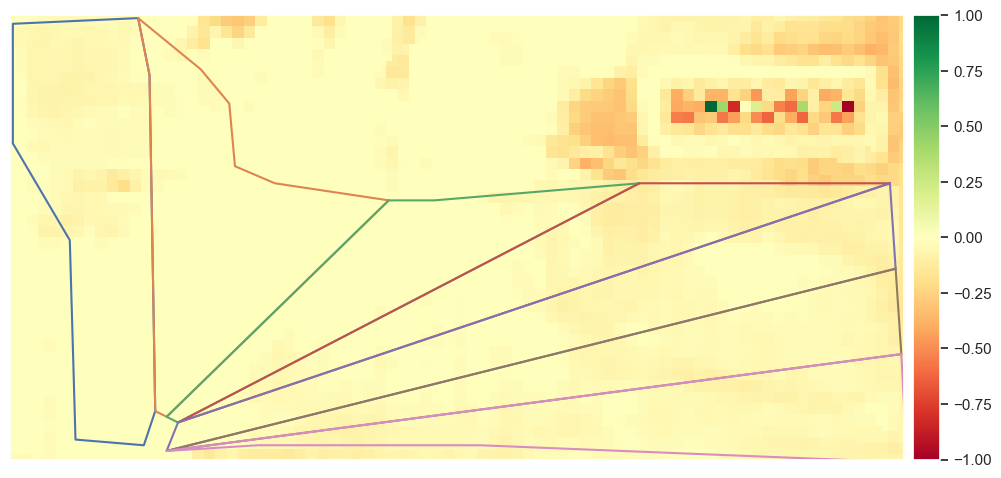

In [118]:
fig, ax = plt.subplots(figsize=(12, 12))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

moist_ind = (N_NIR - SWIR2) / (N_NIR + SWIR2)

ep.plot_bands(moist_ind, ax=ax, cmap="RdYlGn", cols=1, vmin=-1, vmax=1, figsize=(10, 14))
plt.show()

# Atmospheric Penetration (B12 – B11 – B8A)

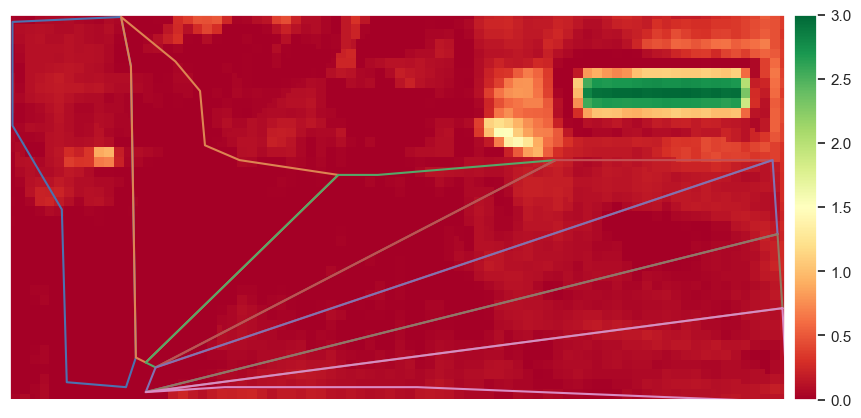

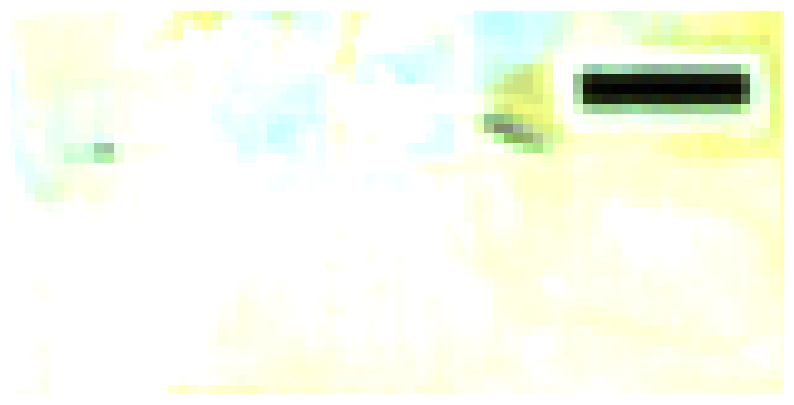

In [119]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

chanels = [SWIR3, SWIR2, N_NIR]
atm_pen = np.absolute(chanels[0] + chanels[1] + chanels[2] - 3)

ep.plot_bands(atm_pen, ax=ax, cmap="RdYlGn", cols=1, vmin=0, vmax=3, figsize=(10, 14))

ep.plot_rgb(np.stack(chanels),
            figsize=(12, 5),
            )
plt.show()

# Анализ маршрутных точек

In [120]:
# supported_drivers['KML'] = 'rw'
# pasture_df = gpd.read_file('pasture.kml', driver='KML')

In [121]:
# all_zagons = []
# for zagon in range(len(pasture_df.index)):
#     all_zagons.append(pasture_df.loc[zagon].geometry)

In [122]:
# merged_zagons = unary_union(all_zagons)

In [123]:
# x_min, y_min, x_max, y_max = merged_zagons.bounds

In [124]:
# print("x_min   ||   y_min   ||   x_max   ||   y_max")
# print(x_min, y_min, x_max, y_max)

In [125]:
# width, height = aoi_width, aoi_height
# step_by_x = (x_max - x_min)/width
# step_by_y = (y_max - y_min)/height

# print(step_by_x, step_by_y)

In [126]:
# fname = './route_coords.gpx'
# gdf = gpd.read_file(fname)

In [127]:
# probes = []
# for i, index in enumerate(gdf[["name", "geometry"]].iterrows(), 1):
#     index, (name, point) = index
#     for x, y in point.coords:
#         probes.append((name, (y, x)))

# probes_dict = dict(probes)

# Запись значении составленных Индексов

In [128]:
# with open(f'./comparision/vegetation_indices_comparision_{date_chosen}.csv', 'w', newline='', encoding='utf-8') as file:
#     writer = csv.writer(file)
#     writer.writerow(["Точка", "Широта", "Долгота", "у", "х", "NDVI", "SAVI", "REVI", "EVI", "TVI", "GNDVI", "NDII", "CVI", "PRI", "NDRE", "OSAVI", "ARVI", "VARI"])
#     for name, (curr_coord_y, curr_coord_x) in probes_dict.items():
#         x = int(np.interp(curr_coord_x, [x_min, x_max], [0, width])) # 157
#         y = int(np.interp(curr_coord_y, [y_min, y_max], [height, 0])) # 78
#         writer.writerow([name, curr_coord_y, curr_coord_x, y, x, ndvi[int(y), int(x)], savi[int(y), int(x)], revi[int(y), int(x)], evi[int(y), int(x)], tvi[int(y), int(x)], gndvi[int(y), int(x)], ndii[int(y), int(x)], cvi[int(y), int(x)], pri[int(y), int(x)], ndre[int(y), int(x)], osavi[int(y), int(x)], arvi[int(y), int(x)], vari[int(y), int(x)]])

# Чтение для последующего анализа

In [129]:
# indices_df = pd.read_csv(f"./comparision/vegetation_indices_comparision_{date_chosen}.csv", encoding='utf-8').dropna(1)
# indices_df

In [130]:
# indices_df = indices_df.iloc[:,5:]

In [131]:
# indices_corr_df = indices_df.corr()

In [132]:
# svm = sns.heatmap(indices_corr_df, 
#         xticklabels=indices_corr_df.columns,
#         yticklabels=indices_corr_df.columns)
# figure = svm.get_figure()    
# figure.savefig(f'./comparision/corr_{date_chosen}.png', dpi=500)

In [133]:
# cols = 4
# ncols, nrows = cols, ceil(len(list(indices_df.columns[:-1]))/cols) 

# fig, axis = plt.subplots(ncols=ncols, nrows=nrows, figsize=(20, 10))
# idx = 0
# fig.suptitle("Соотношение Урожайности к различным Индексам", size=30)
# for col_name in list(indices_df.columns[:-1]):
#     ax = axis[idx // ncols][idx % ncols]
#     m, k = np.polyfit(indices_df[col_name], indices_df["Урожайность"], 1)
#     ax.scatter(indices_df[col_name], indices_df["Урожайность"])
#     ax.plot(indices_df[col_name], m * indices_df[col_name] + k)
#     total_distance = 0
#     for x0, y0 in zip(indices_df[col_name], indices_df["Урожайность"]):
#         x = (y0 + x0/m - k) / (m + 1/m)
#         y = m * x + k
#         distance = math.sqrt((x0-x)**2+(y0-y)**2)
#         total_distance += distance
#     ax.set_title(f"{col_name} d={round(total_distance,2)} s={round(m, 2)}", fontsize=20)
#     idx += 1
        
# plt.tight_layout()

In [134]:
# cols = 4
# ncols, nrows = cols, ceil(len(list(indices_df.columns[:-1]))/cols) 

# fig, axis = plt.subplots(
#     ncols=ncols, nrows=nrows, figsize=(20, 10)
# )
# idx = 0
# fig.suptitle("Соотношение Урожайности к различным Индексам", size=30)
# for col_name in list(indices_df.columns[:-1]):
#     ax = axis[idx // ncols][idx % ncols]
# #     ax.axis('equal')
#     m, k = np.polyfit(indices_df[col_name], indices_df["Урожайность"], 1)
#     ax.scatter(indices_df[col_name], indices_df["Урожайность"])
#     ax.plot(indices_df[col_name], m * indices_df[col_name] + k)
#     total_distance = 0
#     for x0, y0 in zip(indices_df[col_name], indices_df["Урожайность"]):
#         x = (y0 + x0/m - k) / (m + 1/m)
#         y = m * x + k
#         distance = math.sqrt((x0-x)**2+(y0-y)**2)
#         total_distance += distance
#         ax.plot([x0, x], [y0, y])
#     ax.set_title(f"{col_name} d={round(total_distance,2)} s={round(m, 2)}", fontsize=20)
#     idx += 1
        
# plt.tight_layout()

In [135]:
# cols = 4
# ncols, nrows = cols, ceil(len(list(indices_df.columns[:-1]))/cols) 

# fig, axis = plt.subplots(
#     ncols=ncols, nrows=nrows, figsize=(20, 10)
# )
# idx = 0
# fig.suptitle("Соотношение Урожайности к различным Индексам", size=30)
# for col_name in list(indices_df.columns[:-1]):
#     ax = axis[idx // ncols][idx % ncols]
#     ax.axis('equal')
#     m, k = np.polyfit(indices_df[col_name], indices_df["Урожайность"], 1)
#     ax.scatter(indices_df[col_name], indices_df["Урожайность"])
#     ax.plot(indices_df[col_name], m * indices_df[col_name] + k)
#     total_distance = 0
#     for x0, y0 in zip(indices_df[col_name], indices_df["Урожайность"]):
#         x = (y0 + x0/m - k) / (m + 1/m)
#         y = m * x + k
#         distance = math.sqrt((x0-x)**2+(y0-y)**2)
#         total_distance += distance
#         ax.plot([x0, x], [y0, y])
#     ax.set_title(f"{col_name} d={round(total_distance,2)} s={round(m, 2)}", fontsize=20)
#     idx += 1
        
# plt.tight_layout()

# Вывод всех каналов по отдельности

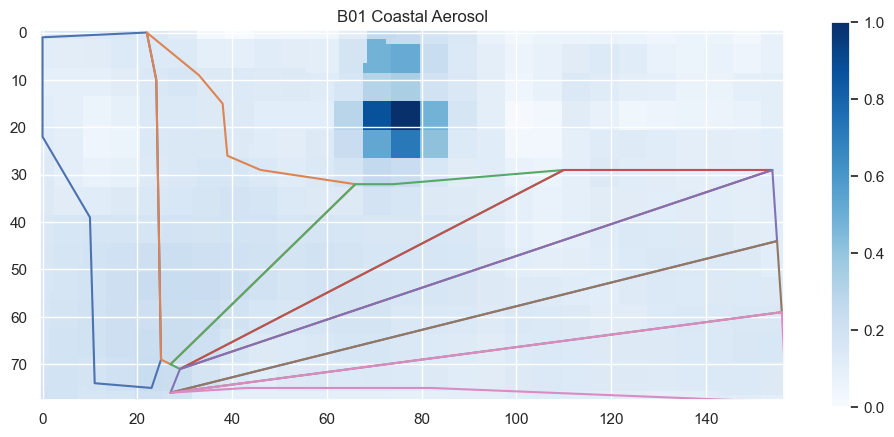

In [136]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(ULTRA_BLUE, cmap="Blues")
plt.title("B01 Coastal Aerosol")
plt.colorbar()
plt.show()

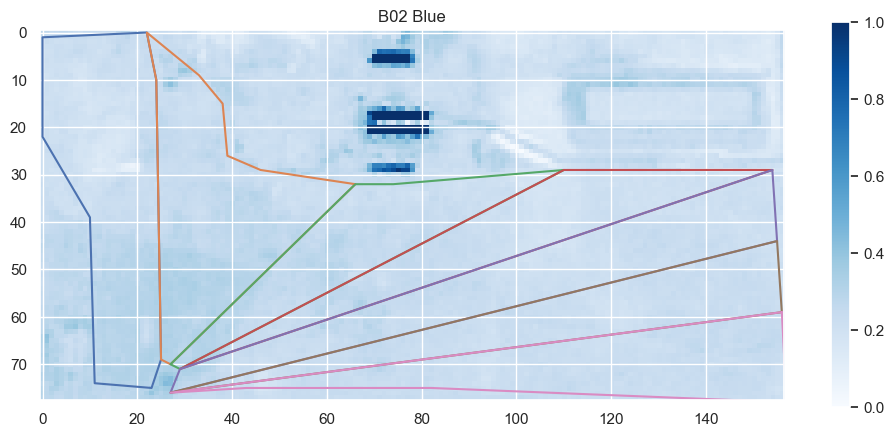

In [137]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(BLUE, cmap="Blues")
plt.title("B02 Blue")
plt.colorbar()
plt.show()

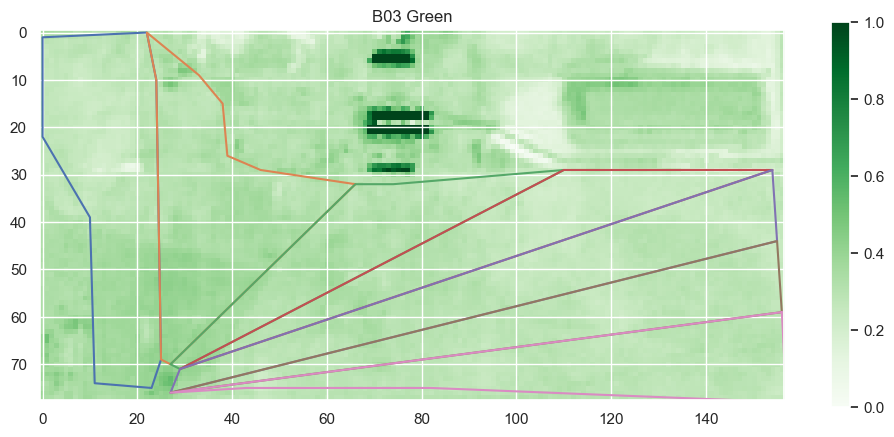

In [138]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(GREEN, cmap="Greens")
plt.title("B03 Green")
plt.colorbar()
plt.show()

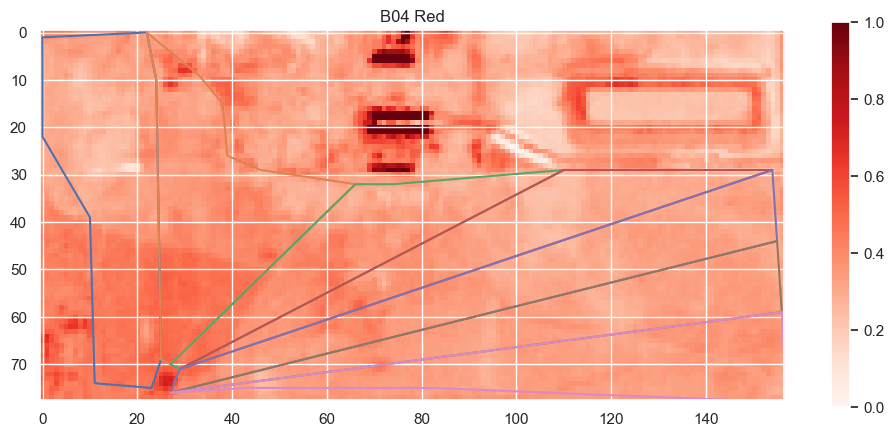

In [139]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(RED, cmap="Reds")
plt.title("B04 Red")
plt.colorbar()
plt.show()

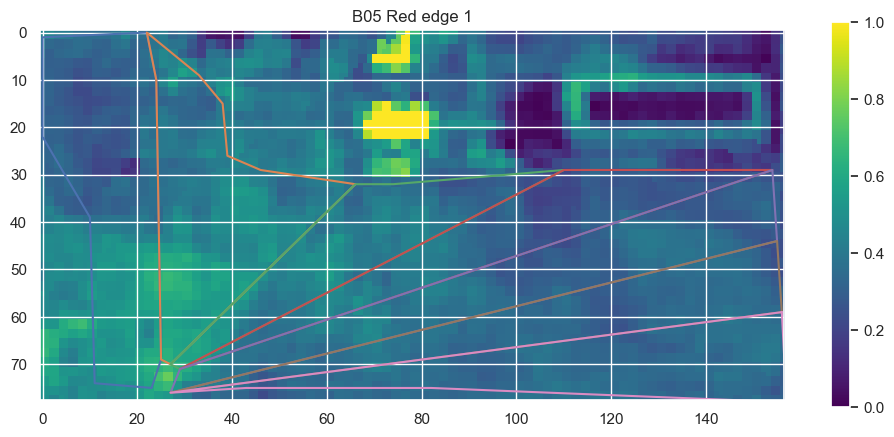

In [140]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(RED_EDGE1, cmap="viridis")
plt.title("B05 Red edge 1")
plt.colorbar()
plt.show()

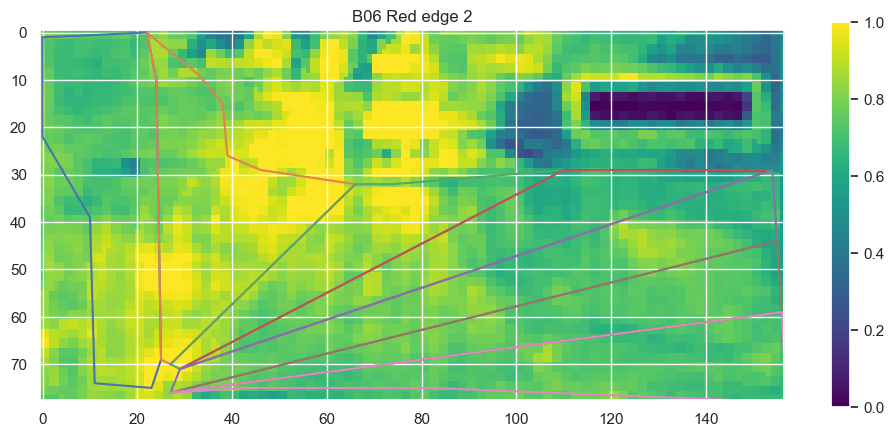

In [141]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(RED_EDGE2, cmap="viridis")
plt.title("B06 Red edge 2")
plt.colorbar()
plt.show()

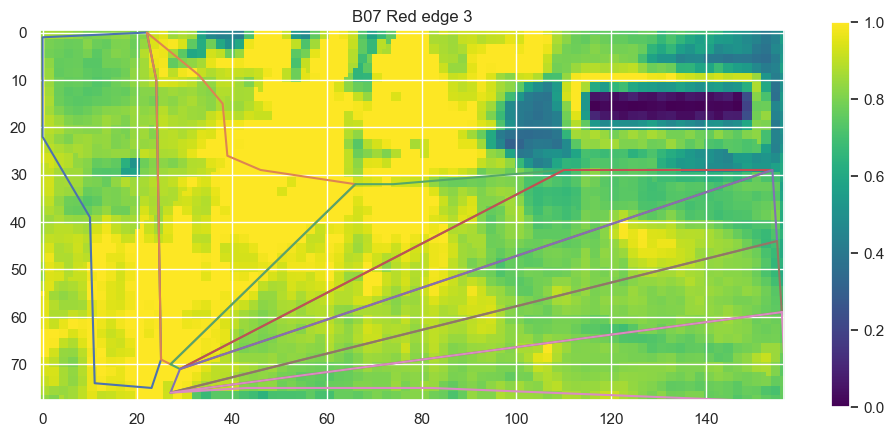

In [142]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(RED_EDGE3, cmap="viridis")
plt.title("B07 Red edge 3")
plt.colorbar()
plt.show()

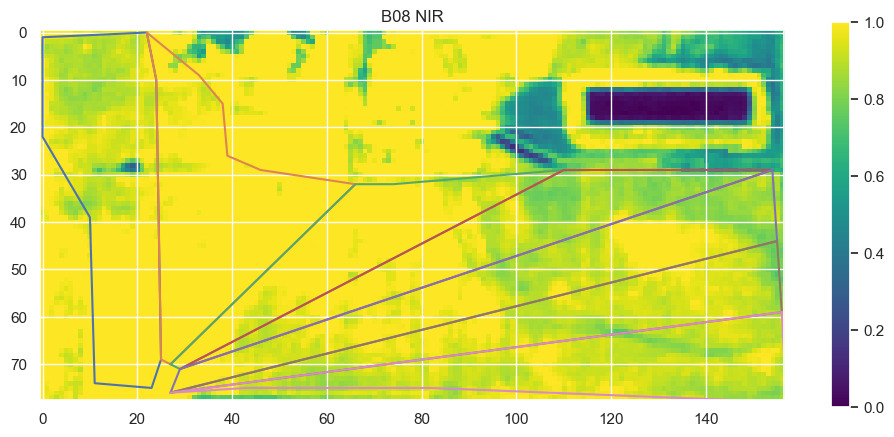

In [143]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(NIR, cmap="viridis")
plt.title("B08 NIR")
plt.colorbar()
plt.show()

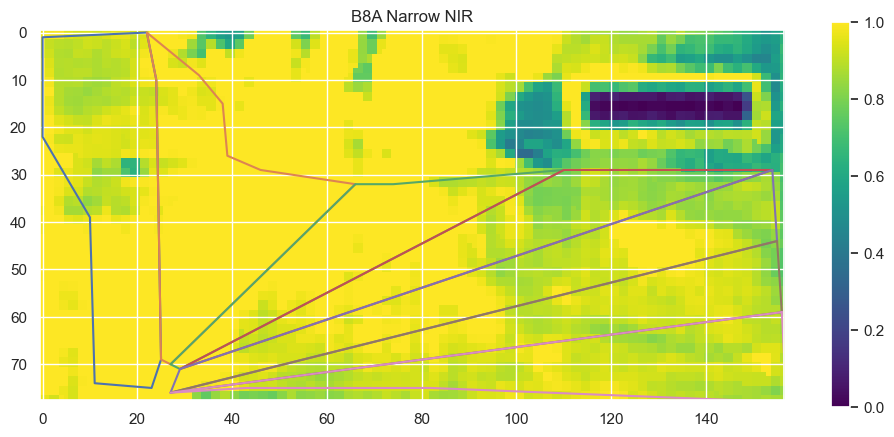

In [144]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(N_NIR, cmap="viridis")
plt.title("B8A Narrow NIR")
plt.colorbar()
plt.show()

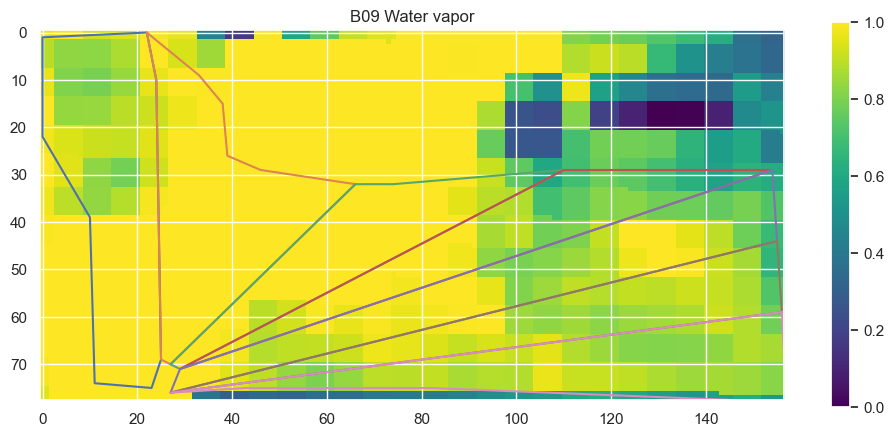

In [145]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(WV, cmap="viridis")
plt.title("B09 Water vapor")
plt.colorbar()
plt.show()

In [146]:
if "B10" in bands_dict:
    fig, ax = plt.subplots(figsize=(12, 5))
    for zagon in range(len(pasture_df)-1):

        ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

    plt.imshow(SWIR_C, cmap="viridis")
    plt.title("B10 SWIR C")
    plt.colorbar()
    plt.show()

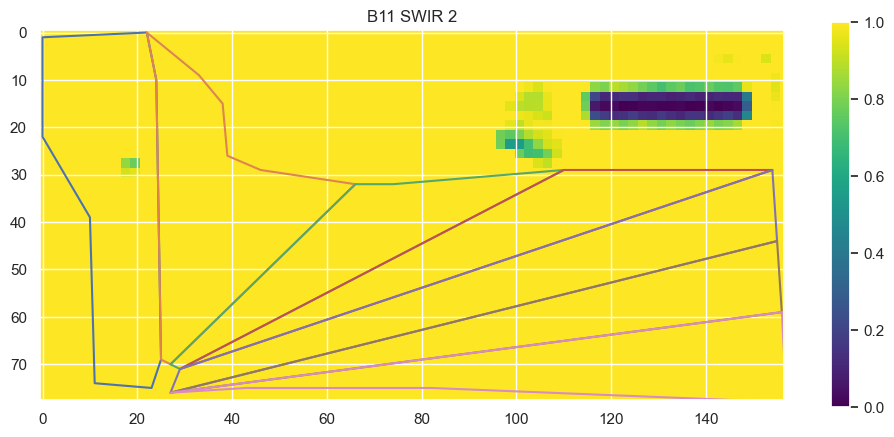

In [147]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(SWIR2, cmap="viridis")
plt.title("B11 SWIR 2")
plt.colorbar()
plt.show()

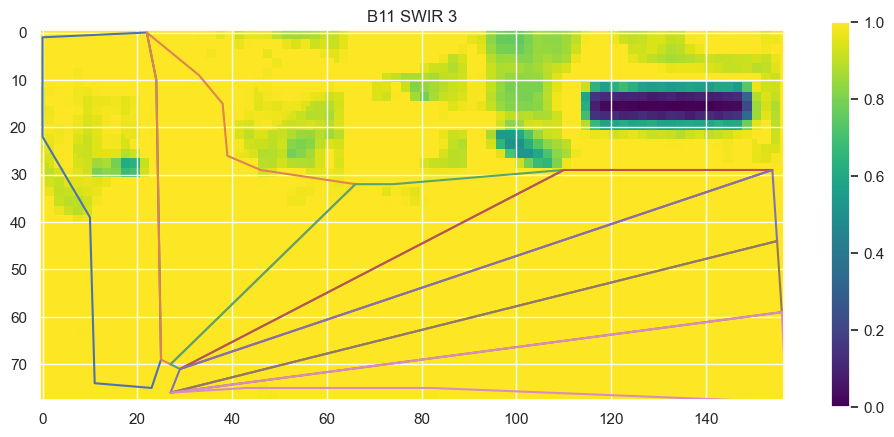

In [148]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(SWIR3, cmap="viridis")
plt.title("B11 SWIR 3")
plt.colorbar()
plt.show()

# Логическая интерпретация полученных данных

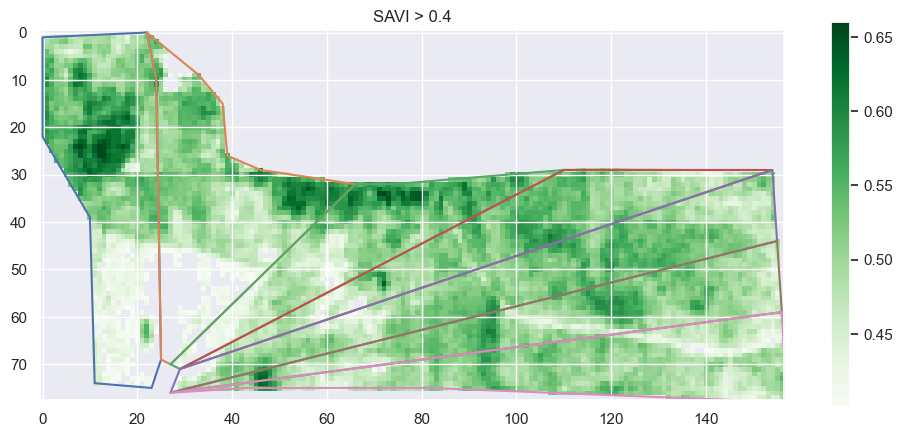

In [149]:
savi_thresh = 0.4
savi_filter = savi > savi_thresh
savi_mask = ~savi_filter
savi_meet = ma.masked_array(savi, mask=savi_mask)
savi_meet_pasture = ma.masked_array(savi_meet, mask=combined_mask.reshape(aoi_height, aoi_width))

fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(savi_meet_pasture, cmap="Greens")
plt.title(f"SAVI > {savi_thresh}")
plt.colorbar()
plt.show()

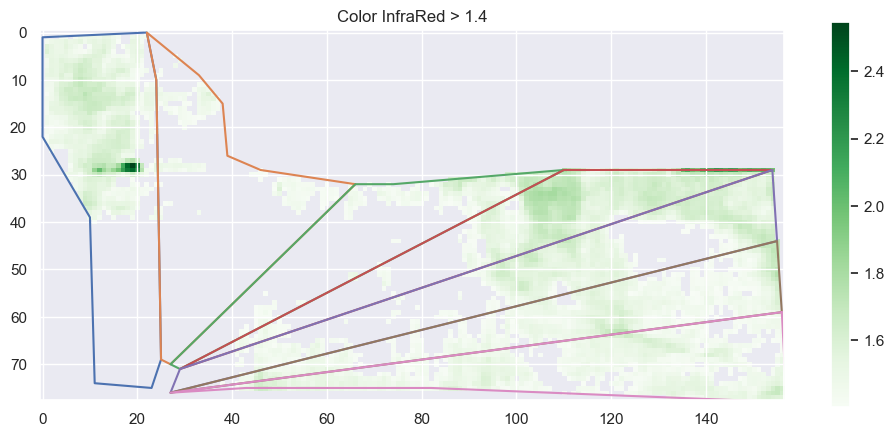

In [150]:
color_inf_thresh = 1.4
color_inf_filter = color_inf > color_inf_thresh
color_inf_mask = ~color_inf_filter
color_inf_meet = ma.masked_array(color_inf, mask=color_inf_mask)
color_inf_meet_pasture = ma.masked_array(color_inf_meet, mask=combined_mask.reshape(aoi_height, aoi_width))

fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(color_inf_meet_pasture, cmap="Greens")
plt.title(f"Color InfraRed > {color_inf_thresh}")
plt.colorbar()
plt.show()

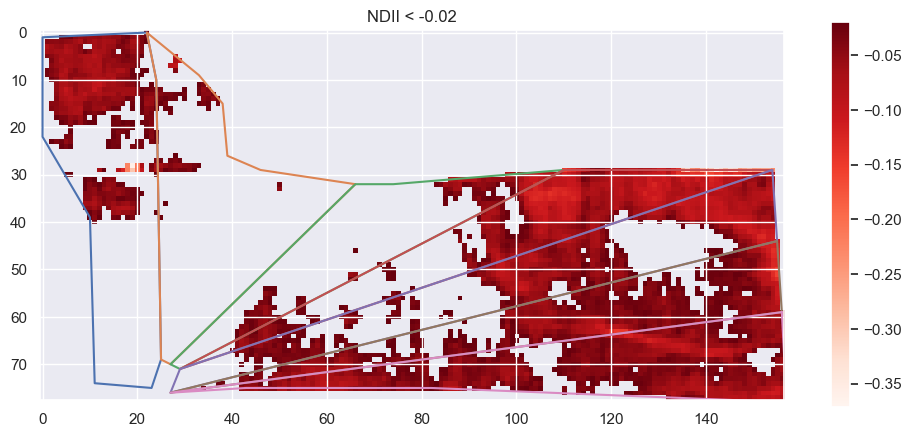

In [151]:
ndii_thresh = -0.02
ndii_filter = ndii < ndii_thresh
ndii_mask = ~ndii_filter
ndii_meet = ma.masked_array(ndii, mask=ndii_mask)
ndii_meet_pasture = ma.masked_array(ndii_meet, mask=combined_mask.reshape(aoi_height, aoi_width))

fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(ndii_meet_pasture, cmap="Reds")
plt.title(f"NDII < {ndii_thresh}")
plt.colorbar()
plt.show()

## Типичный диапазон NDII: от -1 до 1, причем более высокие значения указывают на большее водопоглощение и меньшее количество растительности
### Следовательно, выбранный порог (меньше) < -0,02 значит что в выявленных пикселях либо много растительности или низкое водопоглощение в виду наличия взрослой растительности
### Могу пологать что врослые растения могут потреблять меньше влаги так как им уже нет необходимости расти.

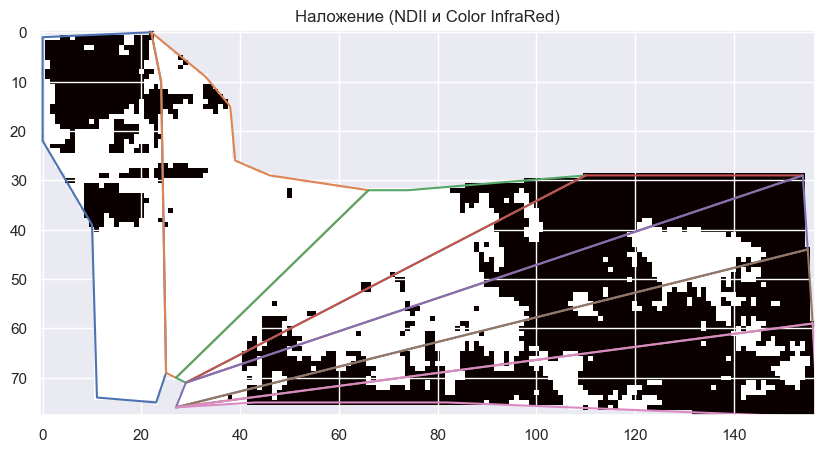

In [152]:
mapped_mask = ~ndii_mask & ~color_inf_mask
mapped_mask = ~mapped_mask
mapped_mask

fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])
    
mapped_mask_pasture = ma.masked_array(mapped_mask, mask=combined_mask.reshape(aoi_height, aoi_width))

plt.imshow(mapped_mask_pasture, cmap="hot")
plt.title("Наложение (NDII и Color InfraRed)")
plt.show()

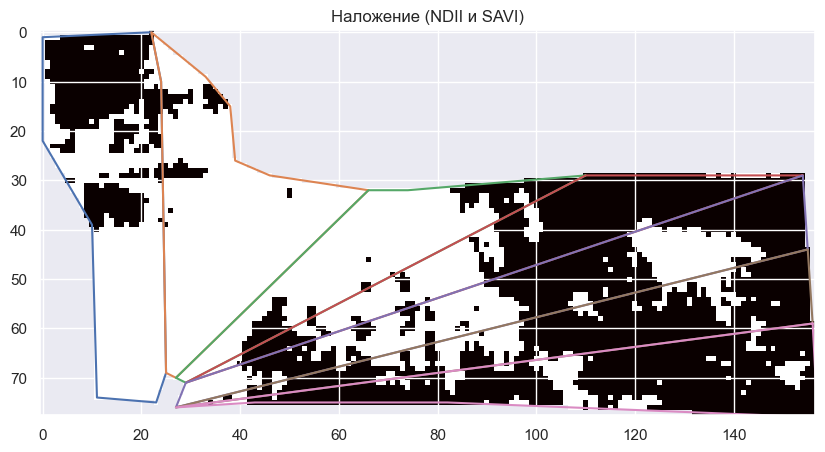

In [153]:
mapped_mask = ~ndii_mask & ~savi_mask
mapped_mask = ~mapped_mask
mapped_mask

fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])
    
mapped_mask_pasture = ma.masked_array(mapped_mask, mask=combined_mask.reshape(aoi_height, aoi_width))

plt.imshow(mapped_mask_pasture, cmap="hot")
plt.title("Наложение (NDII и SAVI)")
plt.show()